In [1087]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout()
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, recall_score, fbeta_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from scipy.stats import chi2_contingency
import math
import re
import pickle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [1088]:
#Function to calculate Cramer's V

def association(observed, method="cramer", correction=False, lambda_=None):

    arr = np.asarray(observed)
    if not np.issubdtype(arr.dtype, np.integer):
        raise ValueError("`observed` must be an integer array.")


    if len(arr.shape) != 2:
        raise ValueError("method only accepts 2d arrays")


    chi2_stat, p, dof, arr = chi2_contingency(arr, correction=correction,
                                 lambda_=lambda_)


    phi2 = chi2_stat / arr.sum()
    n_rows, n_cols = arr.shape
    if method == "cramer":
        value = phi2 / min(n_cols - 1, n_rows - 1)
    elif method == "tschuprow":
        value = phi2 / math.sqrt((n_rows - 1) * (n_cols - 1))
    elif method == 'pearson':
        value = phi2 / (1 + phi2)
    else:
        raise ValueError("Invalid argument value: 'method' argument must "
                         "be 'cramer', 'tschuprow', or 'pearson'")

#     print(value)
    return math.sqrt(value)

# Loading and cleaning the dataset

In [1140]:
data_raw = pd.read_csv('NaviData.csv')

#Replacing the dummy column names with actual column names from the provided dictionary. This will help in our analysis.
colDict=pd.read_excel('data_dictionary_v1.xlsx').set_index('Rename').to_dict()
data_raw.rename(columns = colDict['description'], inplace = True)

<b>The dataset was loaded and the dummy column names were replaced with actual column names from the provided dictionary for convenience purpouses.</b>

In [1090]:
display(data_raw.head(60))

decision_id     label  default  \
0   94dac214-e5d0-4758-b7ec-5a8e899b7f3e  modeling      0.0   
1   bcab40cd-4aaa-43d2-ae82-7d9ba2ded0a9  modeling      1.0   
2   c2f63ac4-e23c-40e7-8ef1-502c1d27df17  modeling      0.0   
3   dc8c2882-5868-470c-8669-9a7e87782a40  modeling      0.0   
4   e40e990a-e89c-43c5-b933-f2b096aa1d35  modeling      1.0   
5   e4445653-9ca9-4614-9f0e-73482910039f  modeling      0.0   
6   e529533f-1275-46cf-bb41-595f62ac6f9e  modeling      0.0   
7   0601a0d2-57c1-431f-9bbc-5027d75d448b  modeling      0.0   
8   0c0b86da-2f92-42e0-b594-ad1cbeb447ab  modeling      1.0   
9   0ef96202-8bd7-45ae-b64a-715ce6392b07  modeling      1.0   
10  0fded339-6589-4010-b2d0-be36b6d07dd1  modeling      0.0   
11  1347e37a-4e1d-455d-84d6-832d5f608328  modeling      1.0   
12  1cbd726a-719d-4afe-9a9b-2ad213928e4d  modeling      1.0   
13  26e6163c-aab3-4aff-9fb3-64987ba47239  modeling      1.0   
14  280add1e-23bc-444d-b2d5-ca0053670810  modeling      0.0   
15  2d832aa2-ed74-47d9-8084-480624c7cd43  modeling      0.0   
16  3c82df1e-7623-4bcc-96d0-a20781bf7d82  modeling      1.0   
17  4003340f-801d-4b62-a51a-d0c4808f0faa  modeling      0.0   
18  52d7c56a-5488-4c26-be94-a4fb950f61a4  modeling      1.0   
19  7703b9f9-b6b9-44ae-b454-7e6175230cc9  modeling      0.0   
20  78ff8438-ddbb-4166-a16c-e68f6d1b5567  modeling      0.0   
21  86861823-502b-4986-9e98-5f15f3dbf70d  modeling      0.0   
22  96fc8470-5fcc-40c0-9175-bcf4e48e955a  modeling      0.0   
23  ac2ab682-cb6a-43f9-b833-72ebe54fae58  modeling      1.0   
24  b1697b37-7204-4f0b-aa52-5d38a4b0dd5d  modeling      1.0   
25  b2ea5f77-7963-4e7c-aba5-a79311f16475  modeling      0.0   
26  c4bf8b9e-7d45-4b46-9115-5b50cad6b4fa  modeling      0.0   
27  da57ad89-ff68-446c-a15f-10c24b1dcef7  modeling      1.0   
28  df706d19-c768-4597-ac13-56ceded175dd  modeling      0.0   
29  ed90bc11-03d1-41e5-be06-1710d61eab50  modeling      0.0   
30  f6677309-16a9-424e-87f6-42d5f3b0d320  modeling      0.0   
31  f95295e9-5f45-4aed-8256-5c965522afa3  modeling      0.0   
32  f9711489-0570-4dd6-841e-e0cf06c40642  modeling      0.0   
33  fcac07cc-9f00-4817-bb61-437d00d0c878  modeling      1.0   
34  039d0562-1f3e-4bfe-be7d-15e4c86227c0  modeling      0.0   
35  0707635c-6a9c-453b-8d5a-f853ce4524aa  modeling      1.0   
36  1b42836a-32f0-43f2-a0b7-6cc8e3b45447  modeling      0.0   
37  27139a3f-5e98-4c60-9002-a201b2e772d6  modeling      0.0   
38  33a05966-f510-4852-8b57-3c5f09c4686e  modeling      0.0   
39  37024e1e-83a9-4496-8425-d746683850f8  modeling      1.0   
40  45d19f6d-dbd1-455f-b2dd-c8b2747118e6  modeling      1.0   
41  47a27876-e766-4347-a244-61e35eadea35  modeling      0.0   
42  59b15964-c796-44af-894b-a442753c89d8  modeling      0.0   
43  5e60755f-3543-4626-8d48-bbe5ac864eef  modeling      0.0   
44  5e790332-9516-4fca-8491-38c3465c59be  modeling      1.0   
45  6a5faf33-4c1f-4c93-b283-7ceda7f08912  modeling      0.0   
46  6d3de440-dd90-4589-acc1-947fe0b51d3a  modeling      1.0   
47  7912ff77-f726-4aaa-a4b5-50aee45ba78e  modeling      0.0   
48  86796a34-c9f3-47c1-ae0a-965b2f0b1d20  modeling      0.0   
49  8c8d6fd3-e113-4974-abb3-3159c8c0cd1b  modeling      0.0   
50  9119ef1b-1db9-48fe-a3b5-d548c9ee5d17  modeling      0.0   
51  9e20c5e0-2303-421d-ad25-42be787d6207  modeling      0.0   
52  a74cb595-8bef-4ab6-914b-e18da26abbe7  modeling      1.0   
53  a80f835b-b6bd-46c8-8d24-e586997a35a5  modeling      0.0   
54  abb0b9c1-ddde-4e9d-b77d-f5fc2a0071f9  modeling      1.0   
55  b9aea777-774e-4d58-ae81-d9aa51a100d0  modeling      0.0   
56  c552e961-6004-4030-a4cd-a03e297efb17  modeling      0.0   
57  d0fd7d8e-3b93-4b91-9c1b-ec979de496e6  modeling      0.0   
58  d5c4e6fc-82e4-4a32-86fa-df3bb0e751e2  modeling      0.0   
59  d659bc1e-45a9-4176-8df2-bdf9d0dd0f76  modeling      0.0   

    # NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)  \
0                                          0.0   
1                                          1.0   
2                                  

<b>We see that the data contains some mobile device related data. We will measure the association between each pair of these features using Cramer's V</b>

In [1091]:
data_cat_x=data_raw.loc[:,['default', 'brand', 'carrier', 'device_name', 'manufacturer', 'gms_version', 'network_type', 'screen_height', 'screen_width', 'screen_dpi']]
chi2_check = pd.DataFrame(columns=['column_name','default', 'brand', 'carrier', 'device_name', 'manufacturer', 'gms_version', 'network_type', 'screen_height', 'screen_width', 'screen_dpi'])


# loop over each column in the training set to calculate Cramer-V-statistic matrix
cross_cramer_v=[]
for column in data_cat_x.columns:
    values=[column]
    for innercolumn in data_cat_x.columns:
        cont_arr=pd.crosstab(data_cat_x[innercolumn], data_cat_x[column])
        cramer_v=association(cont_arr, method="cramer")
        values.append(round(cramer_v, 3))
    cross_cramer_v.append(values)
    
# convert the dictionary to a DF
cramer_v_result = pd.DataFrame(data = cross_cramer_v, columns=['column_name','default', 'brand', 'carrier', 'device_name', 'manufacturer', 'gms_version', 'network_type', 'screen_height', 'screen_width', 'screen_dpi']).set_index('column_name')
cramer_v_result

default  brand  carrier  device_name  manufacturer  \
column_name                                                         
default          1.000  0.327    0.132        0.450         0.328   
brand            0.327  1.000    0.188        1.000         0.984   
carrier          0.132  0.188    1.000        0.463         0.196   
device_name      0.450  1.000    0.463        1.000         1.000   
manufacturer     0.328  0.984    0.196        1.000         1.000   
gms_version      0.478  0.263    0.300        0.443         0.251   
network_type     0.123  0.209    0.170        0.448         0.187   
screen_height    0.311  0.293    0.223        0.688         0.290   
screen_width     0.074  0.209    0.112        0.728         0.216   
screen_dpi       0.075  0.327    0.123        0.894         0.328   

               gms_version  network_type  screen_height  screen_width  \
column_name                                                             
default              0.478         0.123          0.311         0.074   
brand                0.263         0.209          0.293         0.209   
carrier              0.300         0.170          0.223         0.112   
device_name          0.443         0.448          0.688         0.728   
manufacturer         0.251         0.187          0.290         0.216   
gms_version          1.000         0.498          0.305         0.525   
network_type         0.498         1.000          0.371         0.139   
screen_height        0.305         0.371          1.000         0.760   
screen_width         0.525         0.139          0.760         1.000   
screen_dpi           0.605         0.067          0.918         0.550   

               screen_dpi  
column_name                
default             0.075  
brand               0.327  
carrier             0.123  
device_name         0.894  
manufacturer        0.328  
gms_version         0.605  
network_type        0.067  
screen_height       0.918  
screen_width        0.550  
screen_dpi          1.000

<b>We see that gms_version is the feature among these with the highest association with the target. Also, all of the other ones share high association (Cramer's V > 0.2) with gms_version</b>

<b>Hence we will only retain gms_version and drop the other mobile-device related features</b>

In [1141]:
#Separating the rows to be used for modelling

data_oot=data_raw[data_raw['label']=='oot'].drop(columns=['label'])
data_raw=data_raw[data_raw['label']=='modeling'].drop(columns=['label'])

In [1142]:
#Dropping columns that have no logical bearing on the target

data_raw.drop(columns = ['decision_id', 'brand', 'carrier', 'device_name', 'manufacturer', 'network_type', 'screen_height', 'screen_width', 'screen_dpi'], inplace = True)
data_oot.drop(columns = ['brand', 'carrier', 'device_name', 'manufacturer', 'network_type', 'screen_height', 'screen_width', 'screen_dpi'], inplace = True)

In [1143]:
#Splitting the data into train and test splits

data, data_test = train_test_split(data_raw, test_size = 0.2, random_state = 56, stratify = data_raw['default'])
data_copy=data.copy()

In [350]:
#Checking columns with null values

sparse_cols = data.isnull().mean()
sparse_cols[sparse_cols>0.3]

AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS    0.322425
dtype: float64

<b>We see that only one column has more than 30% nulls. We are going to employ the Weight-of-Evidence based method which can inherently handle null values. So the null values were retained in case they contain any information, because missing values might be a signal as well</b>

# Exploratory data analysis, Feature Engineering and Feature Selection

We will explore the data, perform feature engineering wherever required and perform feature selection using correlation matrix and Information Values (IV) of the features.

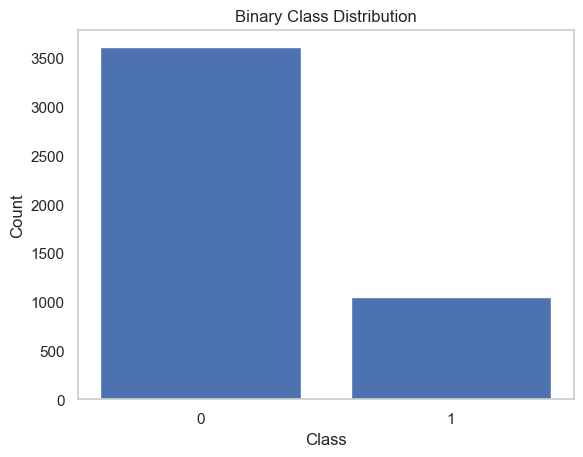

There are 1049 positive class instances and 3612 negative class instances in the data


In [983]:
class_counts = data_raw['default'].value_counts()

# Plot the binary class distribution
plt.bar(class_counts.index, class_counts.values)
plt.xticks(class_counts.index)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Binary Class Distribution')
plt.show()

print("There are %d positive class instances and %d negative class instances in the data" %(class_counts[1], class_counts[0]))

### Feature engineering on the 'gms_version' column

Let us have a look at the values of the gms_version column and decide what to do with it.

In [346]:
display(data['gms_version'].unique())

array(['21.02.14 (120406-352619232)', '20.50.16 (120406-351607135)',
       '20.36.15 (120400-333172415)', '20.45.16 (040408-344294571)',
       '20.36.15 (100300-333172415)', '20.45.16 (120300-344294571)',
       '20.50.16 (120408-351607135)', '20.39.15 (100400-335085812)',
       '20.47.14 (100306-349456378)', '20.36.15 (120306-333172415)',
       '20.50.16 (040308-351607135)', '20.50.16 (100306-351607135)', nan,
       '21.02.14 (040306-352619232)', '20.45.16 (150400-344294571)',
       '20.36.15 (100306-333172415)', '20.39.15 (040408-335085812)',
       '20.45.16 (040306-344294571)', '20.39.15 (100408-335085812)',
       '20.45.16 (100406-344294571)', '20.50.16 (040406-351607135)',
       '21.02.14 (120400-352619232)', '20.33.15 (040406-330018294)',
       '20.50.16 (100406-351607135)', '20.09.14 (040408-300565878)',
       '20.50.16 (120400-351607135)', '20.47.13 (040406-344095733)',
       '20.47.14 (120300-349456378)', '20.42.17 (100400-342117392)',
       '20.39.15 (120408-3350

<b>We see that the version numbers have ordinality, which might be useful. We will convert it into a continuous variable by simply removing the decimals. This will preserve the ordinality of the variable. </b>
    
<b>We will also create a new feature 'gms_sub_version' using the first part of the number within the brackets. The second part within the brackets is left out because perfectly it is correlated with the main gms version.</b>

In [1095]:
def process_gms_sub_version(gms: str):
#     print(gms)
    if(gms!=gms):
        return gms
    else:
        return(float((str(gms).split()[1][1:]).split('-')[0]))
def process_gms_version(gms: str):
    if(gms!=gms):
        return gms
    else:
        split=re.split(',|\.', gms.split(' ')[0])
        res=''
        for i in split:
            if(len(i)==1):
                res=res+'0'+i
            else:
                res=res+i
        return(float(res))
data['gms_sub_version']= data['gms_version'].apply(process_gms_sub_version)
data['gms_version'] = data['gms_version'].apply(process_gms_version)
display(data)

default  # NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)  \
523       0.0                                         2.0   
3656      0.0                                         NaN   
1543      0.0                                         4.0   
793       0.0                                         0.0   
345       0.0                                         0.0   
...       ...                                         ...   
2839      0.0                                         NaN   
1088      1.0                                         0.0   
2661      1.0                                         0.0   
1616      0.0                                         1.0   
4245      1.0                                         7.0   

      AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LAST 180 DAYS  \
523                                           138970.28       
3656                                           87399.76       
1543                                             416.67       
793                                            19338.31       
345                                           118295.29       
...                                                 ...       
2839                                           28074.17       
1088                                           16049.75       
2661                                          142852.82       
1616                                           96999.81       
4245                                         2173846.34       

      AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS  \
523                                           4252.50   
3656                                        467757.78   
1543                                          8842.10   
793                                           5217.54   
345                                           1014.67   
...                                               ...   
2839                                          6302.38   
1088                                           162.51   
2661                                            47.84   
1616                                          5970.88   
4245                                            40.55   

      # RECHARGES LAST 150-180 DAYS  count_debit_transactions_last_360_days  \
523                             0.0                                    43.0   
3656                            0.0                                    14.0   
1543                            0.0                                     6.0   
793                             0.0                                    39.0   
345                             0.0                                   156.0   
...                             ...                                     ...   
2839                            1.0                                    97.0   
1088                            0.0                                    68.0   
2661                            0.0                                   106.0   
1616                            0.0                                    84.0   
4245                            0.0                                   360.0   

      CUMULATIVE MAXIMUM BALANCE LAST 30 DAYS  \
523                                 107354.45   
3656                                712788.60   
1543                                      NaN   
793                                  25325.17   
345                                  66574.00   
...                                       ...   
2839                                      NaN   
1088                                  9179.38   
2661                                 59422.00   
1616                                 43782.32   
4245                                377674.66   

      # RECHARGES WITH RECHARGE AMOUNTS MORE THAN 200 LAST 30-60 DAYS  \
523                                                 0.0                 
3656                                                0.0                 
1543                                                0.0                 
7

### Removing multicollinearity

All of the relevant variables are continuous or ordinal variables. So we will plot the correlation chart of the data to detect and remove multicollinearity between the columns.

<Axes: >

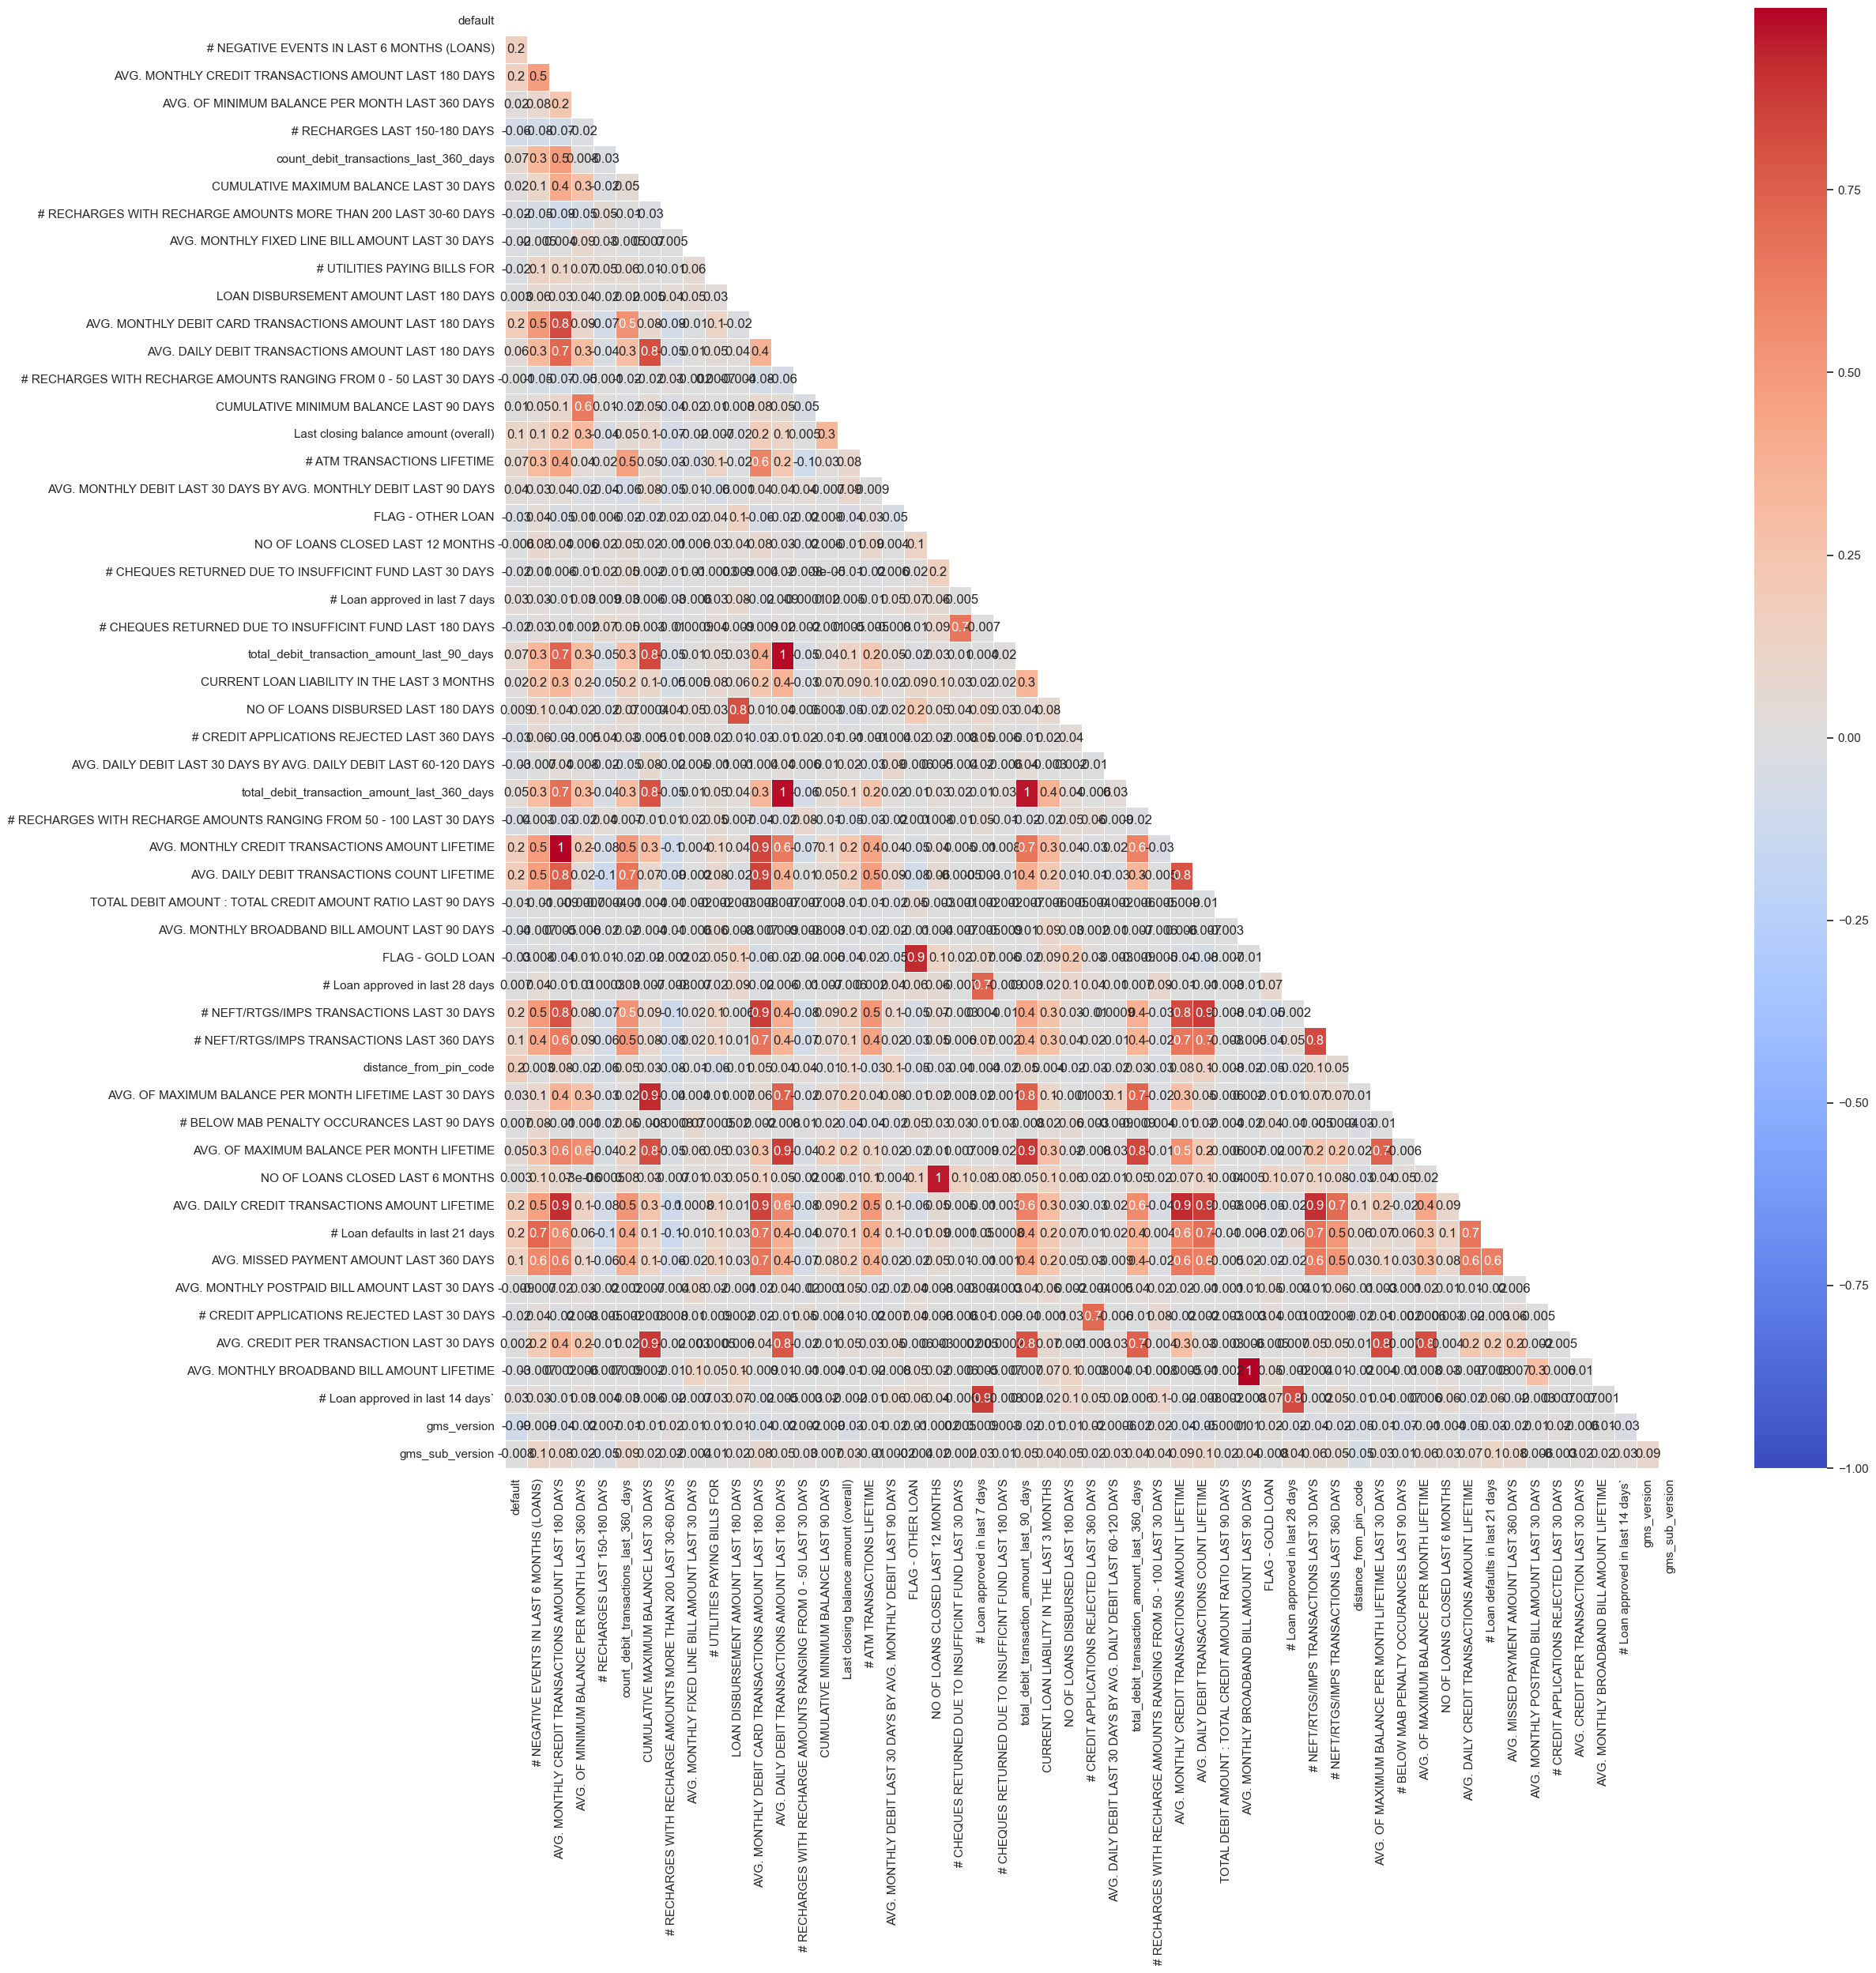

In [371]:
corr=data.corr()
mask = np.zeros_like(data.corr().fillna(0), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(data.corr(), mask=mask, annot=True,  cmap="coolwarm", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

<b>All feature-pairs with correlation scores of 0.8 or more were considered to be collinear. The decision to drop a particular column out of a pair was made on the basis of the number of other columns each of the two columns in the pair are highly correlated with.</b>

In [1096]:
#Columns to be dropped to remove multicollinearity

colsToBeDropped=['AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LAST 180 DAYS', 'CUMULATIVE MAXIMUM BALANCE LAST 30 DAYS', 'AVG. MONTHLY DEBIT CARD TRANSACTIONS AMOUNT LAST 180 DAYS', 'AVG. DAILY DEBIT TRANSACTIONS AMOUNT LAST 180 DAYS', 'NO OF LOANS CLOSED LAST 12 MONTHS', 'total_debit_transaction_amount_last_90_days', 'NO OF LOANS DISBURSED LAST 180 DAYS', 'FLAG - GOLD LOAN', '# NEFT/RTGS/IMPS TRANSACTIONS LAST 30 DAYS', 'AVG. OF MAXIMUM BALANCE PER MONTH LIFETIME LAST 30 DAYS', 'AVG. OF MAXIMUM BALANCE PER MONTH LIFETIME', 'AVG. MONTHLY BROADBAND BILL AMOUNT LIFETIME', '# Loan approved in last 14 days`', 'AVG. DAILY CREDIT TRANSACTIONS AMOUNT LIFETIME', '# CHEQUES RETURNED DUE TO INSUFFICINT FUND LAST 180 DAYS']
data.drop(columns=colsToBeDropped, inplace=True)

<Axes: >

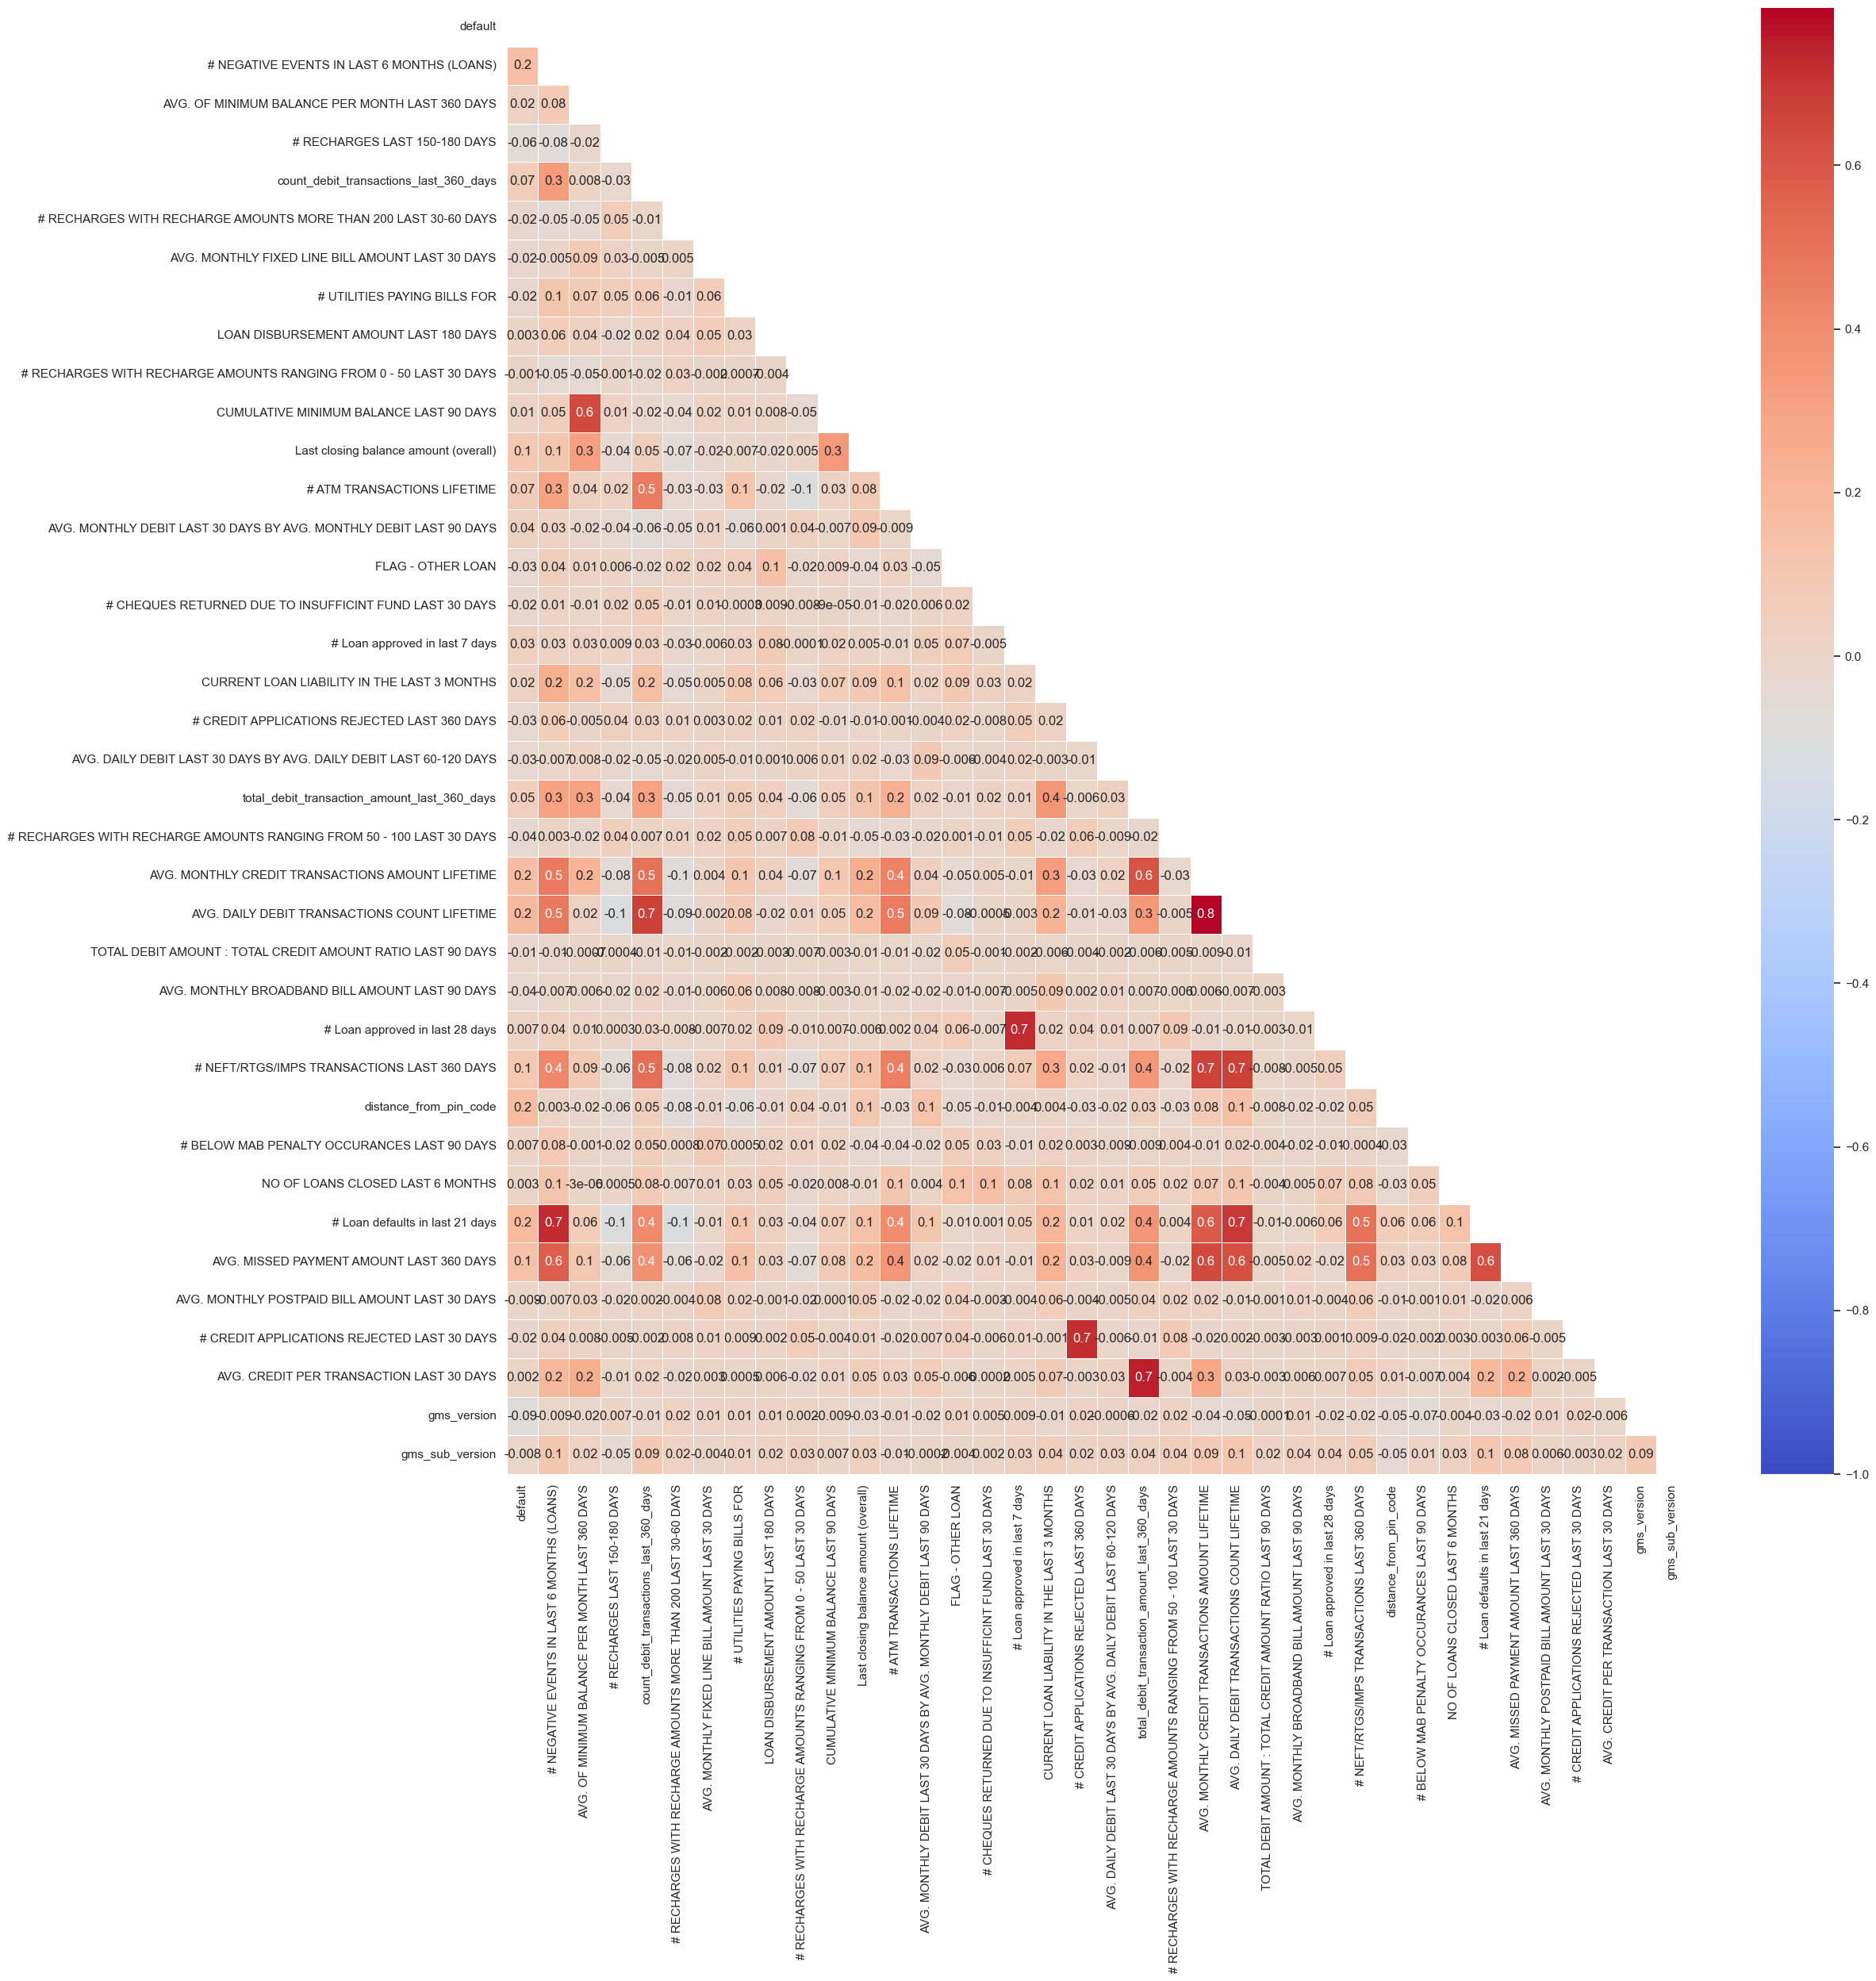

In [373]:
corr=data.corr()
mask = np.zeros_like(data.corr().fillna(0), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(data.corr(), mask=mask, annot=True,  cmap="coolwarm", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

<b>The correlation matrix for the remaining columns was plotted again and now we see that there are no columns with significant multicollinearity</b>

### Feature Selection based on Information Value (IV)

In [1079]:
def woe_continuous(inputdf, continuous_variabe_name, y_df, bins=None):
    df=inputdf.copy()
    if bins is None:
        df['col_buckets']=pd.qcut(df[continuous_variabe_name], 10, duplicates='drop')
    else:
        df['col_buckets']=pd.cut(df[continuous_variabe_name], bins)
    df['col_buckets']=(df['col_buckets'].cat.add_categories('missing values').fillna('missing values'))
    df[continuous_variabe_name]=df['col_buckets']
    df.drop(columns=['col_buckets'], inplace=True)
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False, dropna=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False, dropna=False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_good']=df.apply(lambda x: 0 if x['n_obs']==0 else (1-x['prop_good']), axis=1)
    df['prop_n_obs'] = np.maximum(df['n_obs'], 0.5) / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = np.maximum(df['n_good'], 0.5) / df['n_good'].sum()
    df['prop_n_bad'] = np.maximum(df['n_bad'], 0.5) / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    df=pd.concat([df[df[continuous_variabe_name]=='missing values'], df[df[continuous_variabe_name]!='missing values']])
    return df

def woe_categorical(inputdf, cat_variabe_name, y_df):
    df=inputdf.copy()
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False, dropna=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False, dropna=False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_good']=df.apply(lambda x: 0 if x['n_obs']==0 else (1-x['prop_good']), axis=1) 
    df['prop_n_obs'] = np.maximum(df['n_obs'], 0.5) / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = np.maximum(df['n_good'], 0.5) / df['n_good'].sum()
    df['prop_n_bad'] = np.maximum(df['n_bad'], 0.5) / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

<b>The above functions calculate the Information Value (IV) for each variable and the Weight of Evidence of each category/bin of each variable. For this the continuous variables were binned into appropriate categories using qcut. The method qcut is used because the variables are not normally distributed and heavy presence of outliers was observed.</b>

In [378]:
sns.set()
def plot_by_woe(inputdf_WoE, rotation_of_x_axis_labels = 90):
    df_WoE=inputdf_WoE.copy()
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

<b> The above function plots the WoE plot for a variable</b>

In [1080]:
cols = data.columns
for column in cols[~cols.isin(['default'])]:
    if(data.nunique()[column]>10):
        woe_results_iv=woe_continuous(data, column, data['default'])
    else:
        woe_results_iv=woe_categorical(data, column, data['default'])
    display(woe_results_iv)

# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)  n_obs  prop_good  prop_n_obs  \
5                             missing values    748   0.840909    0.200644   
0                              (-0.001, 1.0]   2007   0.812157    0.538358   
1                                 (1.0, 2.0]    374   0.711230    0.100322   
2                                 (2.0, 3.0]    138   0.710145    0.037017   
3                                 (3.0, 5.0]    188   0.632979    0.050429   
4                                (5.0, 58.0]    273   0.538462    0.073230   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
5   629.0  119.0     0.217722    0.141836  0.428553  0.211484  
0  1630.0  377.0     0.564209    0.449344  0.227635  0.211484  
1   266.0  108.0     0.092073    0.128725 -0.335090  0.211484  
2    98.0   40.0     0.033922    0.047676 -0.340367  0.211484  
3   119.0   69.0     0.041191    0.082241 -0.691438  0.211484  
4   147.0  126.0     0.050883    0.150179 -1.082304  0.211484

AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS  n_obs  prop_good  \
10                                  missing values    123   0.853659   
0                                 (-0.001, 70.472]    361   0.695291   
1                                (70.472, 593.676]    360   0.805556   
2                              (593.676, 1713.698]    361   0.811634   
3                             (1713.698, 3459.924]    360   0.833333   
4                              (3459.924, 5541.79]    361   0.778393   
5                              (5541.79, 8110.656]    360   0.780556   
6                             (8110.656, 13281.15]    361   0.778393   
7                            (13281.15, 21845.488]    360   0.730556   
8                            (21845.488, 48963.34]    360   0.783333   
9                            (48963.34, 3117544.2]    361   0.725762   

    prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10    0.032994   105.0   18.0     0.036345    0.021454  0.527134  0.059274  
0     0.096835   251.0  110.0     0.086881    0.131108 -0.411482  0.059274  
1     0.096567   290.0   70.0     0.100381    0.083433  0.184931  0.059274  
2     0.096835   293.0   68.0     0.101419    0.081049  0.224210  0.059274  
3     0.096567   300.0   60.0     0.103842    0.071514  0.372983  0.059274  
4     0.096835   281.0   80.0     0.097265    0.095352  0.019873  0.059274  
5     0.096567   281.0   79.0     0.097265    0.094160  0.032452  0.059274  
6     0.096835   281.0   80.0     0.097265    0.095352  0.019873  0.059274  
7     0.096567   263.0   97.0     0.091035    0.115614 -0.239012  0.059274  
8     0.096567   282.0   78.0     0.097612    0.092968  0.048743  0.059274  
9     0.096835   262.0   99.0     0.090689    0.117998 -0.263230  0.059274

# RECHARGES LAST 150-180 DAYS  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0                            6.0      1   0.000000    0.000268     0.0    1.0   
1                            3.0     25   0.760000    0.006706    19.0    6.0   
2                            0.0   3225   0.764961    0.865075  2467.0  758.0   
3                            1.0    224   0.808036    0.060086   181.0   43.0   
4                            NaN    167   0.856287    0.044796   143.0   24.0   
5                            2.0     73   0.904110    0.019582    66.0    7.0   
6                            5.0      6   1.000000    0.001609     6.0    0.0   
7                            4.0      7   1.000000    0.001878     7.0    0.0   

   prop_n_good  prop_n_bad       WoE        IV  
0     0.000173    0.001192 -1.929602  0.037571  
1     0.006577    0.007151 -0.083775  0.037571  
2     0.853929    0.903456 -0.056380  0.037571  
3     0.062651    0.051251  0.200842  0.037571  
4     0.049498    0.028605  0.548336  0.037571  
5     0.022845    0.008343  1.007290  0.037571  
6     0.002077    0.000596  1.248452  0.037571  
7     0.002423    0.000596  1.402602  0.037571

count_debit_transactions_last_360_days  n_obs  prop_good  prop_n_obs  \
10                         missing values    117   0.846154    0.031384   
0                          (-0.001, 14.0]    372   0.793011    0.099785   
1                            (14.0, 30.0]    359   0.816156    0.096298   
2                            (30.0, 48.0]    366   0.811475    0.098176   
3                            (48.0, 67.0]    352   0.821023    0.094421   
4                            (67.0, 84.0]    367   0.741144    0.098444   
5                           (84.0, 100.0]    352   0.676136    0.094421   
6                          (100.0, 131.0]    368   0.817935    0.098712   
7                          (131.0, 171.0]    359   0.788301    0.096298   
8                          (171.0, 255.0]    355   0.802817    0.095225   
9                          (255.0, 797.0]    361   0.656510    0.096835   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10    99.0   18.0     0.034268    0.021454  0.468293  0.103226  
0    295.0   77.0     0.102111    0.091776  0.106715  0.103226  
1    293.0   66.0     0.101419    0.078665  0.254063  0.103226  
2    297.0   69.0     0.102804    0.082241  0.223171  0.103226  
3    289.0   63.0     0.100035    0.075089  0.286837  0.103226  
4    272.0   95.0     0.094150    0.113230 -0.184530  0.103226  
5    238.0  114.0     0.082381    0.135876 -0.500383  0.103226  
6    301.0   67.0     0.104188    0.079857  0.265963  0.103226  
7    283.0   76.0     0.097958    0.090584  0.078259  0.103226  
8    285.0   70.0     0.098650    0.083433  0.167539  0.103226  
9    237.0  124.0     0.082035    0.147795 -0.588676  0.103226

# RECHARGES WITH RECHARGE AMOUNTS MORE THAN 200 LAST 30-60 DAYS  n_obs  \
0                                                7.0                    1   
1                                                4.0                    2   
2                                                0.0                 2805   
3                                                1.0                  628   
4                                                2.0                  109   
5                                                NaN                  167   
6                                                3.0                   16   

   prop_good  prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE  \
0   0.000000    0.000268     0.0    1.0     0.000173    0.001192 -1.929602   
1   0.500000    0.000536     1.0    1.0     0.000346    0.001192 -1.236455   
2   0.764706    0.752414  2145.0  660.0     0.742471    0.786651 -0.057800   
3   0.791401    0.168455   497.0  131.0     0.172032    0.156138  0.096938   
4   0.807339    0.029238    88.0   21.0     0.030460    0.025030  0.196359   
5   0.856287    0.044796   143.0   24.0     0.049498    0.028605  0.548336   
6   0.937500    0.004292    15.0    1.0     0.005192    0.001192  1.471595   

         IV  
0  0.025515  
1  0.025515  
2  0.025515  
3  0.025515  
4  0.025515  
5  0.025515  
6  0.025515

AVG. MONTHLY FIXED LINE BILL AMOUNT LAST 30 DAYS  n_obs  prop_good  \
2                                   missing values    205   0.853659   
0                                  (-308.001, 0.0]   3502   0.769560   
1                                    (0.0, 5744.0]     21   0.904762   

   prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
2    0.054989   175.0   30.0     0.060575    0.035757  0.527134  0.018226  
0    0.939378  2695.0  807.0     0.932849    0.961859 -0.030625  0.018226  
1    0.005633    19.0    2.0     0.006577    0.002384  1.014837  0.018226

# UTILITIES PAYING BILLS FOR  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
4               missing values    167   0.856287    0.044796   143.0   24.0   
0                (-0.001, 1.0]   2264   0.764576    0.607296  1731.0  533.0   
1                   (1.0, 2.0]    598   0.817726    0.160408   489.0  109.0   
2                   (2.0, 3.0]    407   0.678133    0.109174   276.0  131.0   
3                  (3.0, 49.0]    292   0.856164    0.078326   250.0   42.0   

   prop_n_good  prop_n_bad       WoE        IV  
4     0.049498    0.028605  0.548336  0.073715  
0     0.599169    0.635280 -0.058522  0.073715  
1     0.169263    0.129917  0.264560  0.073715  
2     0.095535    0.156138 -0.491251  0.073715  
3     0.086535    0.050060  0.547336  0.073715

LOAN DISBURSEMENT AMOUNT LAST 180 DAYS  n_obs  prop_good  prop_n_obs  \
5                         missing values    395   0.868354    0.105955   
0                     (-100000.001, 0.0]   2322   0.768303    0.622854   
1                           (0.0, 100.0]     52   0.519231    0.013948   
2                       (100.0, 15000.0]    372   0.723118    0.099785   
3                   (15000.0, 57900.772]    253   0.743083    0.067865   
4                 (57900.772, 4480000.0]    334   0.832335    0.089592   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
5   343.0   52.0     0.118726    0.061979  0.650032  0.082641  
0  1784.0  538.0     0.617515    0.641240 -0.037700  0.082641  
1    27.0   25.0     0.009346    0.029797 -1.159494  0.082641  
2   269.0  103.0     0.093112    0.122765 -0.276473  0.082641  
3   188.0   65.0     0.065074    0.077473 -0.174400  0.082641  
4   278.0   56.0     0.096227    0.066746  0.365814  0.082641

# RECHARGES WITH RECHARGE AMOUNTS RANGING FROM 0 - 50 LAST 30 DAYS  n_obs  \
2                                     missing values                    167   
0                                      (-0.001, 1.0]                   3241   
1                                        (1.0, 19.0]                    320   

   prop_good  prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE  \
2   0.856287    0.044796   143.0   24.0     0.049498    0.028605  0.548336   
0   0.769824    0.869367  2495.0  746.0     0.863621    0.889154 -0.029137   
1   0.784375    0.085837   251.0   69.0     0.086881    0.082241  0.054891   

         IV  
2  0.012455  
0  0.012455  
1  0.012455

CUMULATIVE MINIMUM BALANCE LAST 90 DAYS  n_obs  prop_good  prop_n_obs  \
10                          missing values    171   0.853801    0.045869   
0                          (-0.001, 2.444]    356   0.755618    0.095494   
1                          (2.444, 17.928]    356   0.780899    0.095494   
2                         (17.928, 66.432]    355   0.816901    0.095225   
3                        (66.432, 133.634]    356   0.702247    0.095494   
4                        (133.634, 416.15]    356   0.873596    0.095494   
5                        (416.15, 920.188]    355   0.771831    0.095225   
6                        (920.188, 2055.0]    379   0.738786    0.101663   
7                        (2055.0, 5859.99]    332   0.807229    0.089056   
8                      (5859.99, 19703.18]    356   0.775281    0.095494   
9                   (19703.18, 1496645.47]    356   0.693820    0.095494   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10   146.0   25.0     0.050537    0.029797  0.528276  0.096825  
0    269.0   87.0     0.093112    0.103695 -0.107652  0.096825  
1    278.0   78.0     0.096227    0.092968  0.034457  0.096825  
2    290.0   65.0     0.100381    0.077473  0.259039  0.096825  
3    250.0  106.0     0.086535    0.126341 -0.378433  0.096825  
4    311.0   45.0     0.107650    0.053635  0.696675  0.096825  
5    274.0   81.0     0.094843    0.096544 -0.017776  0.096825  
6    280.0   99.0     0.096919    0.117998 -0.196785  0.096825  
7    268.0   64.0     0.092766    0.076281  0.195649  0.096825  
8    276.0   80.0     0.095535    0.095352  0.001919  0.096825  
9    247.0  109.0     0.085497    0.129917 -0.418415  0.096825

Last closing balance amount (overall)  n_obs  prop_good  prop_n_obs  \
10                        missing values    117   0.846154    0.031384   
0                    (-66129.001, 105.0]    362   0.729282    0.097103   
1                        (105.0, 594.78]    361   0.833795    0.096835   
2                      (594.78, 1727.78]    361   0.819945    0.096835   
3                      (1727.78, 3573.0]    361   0.808864    0.096835   
4                       (3573.0, 7307.0]    361   0.864266    0.096835   
5                      (7307.0, 13037.0]    361   0.822715    0.096835   
6                     (13037.0, 20054.0]    367   0.784741    0.098444   
7                    (20054.0, 33507.67]    355   0.766197    0.095225   
8                    (33507.67, 91553.0]    361   0.731302    0.096835   
9                   (91553.0, 974381.86]    361   0.565097    0.096835   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10    99.0   18.0     0.034268    0.021454  0.468293  0.193609  
0    264.0   98.0     0.091381    0.116806 -0.245473  0.193609  
1    301.0   60.0     0.104188    0.071514  0.376311  0.193609  
2    296.0   65.0     0.102458    0.077473  0.279517  0.193609  
3    292.0   69.0     0.101073    0.082241  0.206192  0.193609  
4    312.0   49.0     0.107996    0.058403  0.614728  0.193609  
5    297.0   64.0     0.102804    0.076281  0.298394  0.193609  
6    288.0   79.0     0.099688    0.094160  0.057058  0.193609  
7    272.0   83.0     0.094150    0.098927 -0.049494  0.193609  
8    264.0   97.0     0.091381    0.115614 -0.235217  0.193609  
9    204.0  157.0     0.070613    0.187128 -0.974581  0.193609

# ATM TRANSACTIONS LIFETIME  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
8              missing values    117   0.846154    0.031384    99.0   18.0   
0               (-0.001, 1.0]   1182   0.776650    0.317060   918.0  264.0   
1                  (1.0, 3.0]    423   0.794326    0.113466   336.0   87.0   
2                  (3.0, 5.0]    283   0.819788    0.075912   232.0   51.0   
3                  (5.0, 8.0]    299   0.782609    0.080204   234.0   65.0   
4                 (8.0, 13.0]    373   0.868633    0.100054   324.0   49.0   
5                (13.0, 19.0]    354   0.714689    0.094957   253.0  101.0   
6                (19.0, 33.0]    347   0.775216    0.093079   269.0   78.0   
7               (33.0, 169.0]    350   0.640000    0.093884   224.0  126.0   

   prop_n_good  prop_n_bad       WoE      IV  
8     0.034268    0.021454  0.468293  0.1066  
0     0.317757    0.314660  0.009793  0.1066  
1     0.116303    0.103695  0.114748  0.1066  
2     0.080305    0.060787  0.278457  0.1066  
3     0.080997    0.077473  0.044479  0.1066  
4     0.112150    0.058403  0.652468  0.1066  
5     0.087574    0.120381 -0.318186  0.1066  
6     0.093112    0.092968  0.001548  0.1066  
7     0.077535    0.150179 -0.661091  0.1066

AVG. MONTHLY DEBIT LAST 30 DAYS BY AVG. MONTHLY DEBIT LAST 90 DAYS  n_obs  \
10                                     missing values                    172   
0                                       (-0.001, 0.3]                    365   
1                                         (0.3, 0.65]                    366   
2                                        (0.65, 0.87]                    358   
3                                        (0.87, 1.05]                    355   
4                                        (1.05, 1.24]                    337   
5                                        (1.24, 1.46]                    366   
6                                        (1.46, 1.72]                    343   
7                                         (1.72, 1.9]                    408   
8                                         (1.9, 2.17]                    305   
9                                         (2.17, 3.0]                    353   

    prop_good  prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE  \
10   0.831395    0.046137   143.0   29.0     0.049498    0.034565  0.359094   
0    0.775342    0.097908   283.0   82.0     0.097958    0.097735  0.002273   
1    0.816940    0.098176   299.0   67.0     0.103496    0.079857  0.259296   
2    0.801676    0.096030   287.0   71.0     0.099342    0.084625  0.160347   
3    0.780282    0.095225   277.0   78.0     0.095881    0.092968  0.030854   
4    0.798220    0.090397   269.0   68.0     0.093112    0.081049  0.138749   
5    0.792350    0.098176   290.0   76.0     0.100381    0.090584  0.102693   
6    0.769679    0.092006   264.0   79.0     0.091381    0.094160 -0.029954   
7    0.678922    0.109442   277.0  131.0     0.095881    0.156138 -0.487635   
8    0.675410    0.081813   206.0   99.0     0.071305    0.117998 -0.503699   
9    0.832861    0.094689   294.0   59.0     0.101765    0.070322  0.369587   

          IV  
10  0.081229  
0   0.081229  
1   0.081229  
2   0.081229  
3   0.081229  
4   0.081229  
5   0.081229  
6   0.081229  
7   0.081229  
8   0.081229  
9   0.081229

FLAG - OTHER LOAN  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
0                0.0   3053   0.760563    0.818938  2322.0  731.0   
1                1.0    280   0.800000    0.075107   224.0   56.0   
2                NaN    395   0.868354    0.105955   343.0   52.0   

   prop_n_good  prop_n_bad       WoE        IV  
0     0.803738    0.871275 -0.080684  0.043954  
1     0.077535    0.066746  0.149839  0.043954  
2     0.118726    0.061979  0.650032  0.043954

# CHEQUES RETURNED DUE TO INSUFFICINT FUND LAST 30 DAYS  n_obs  prop_good  \
0                                                2.0            1   1.000000   
1                                                0.0         3599   0.772437   
2                                                1.0           11   0.818182   
3                                                NaN          117   0.846154   

   prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    0.000268     1.0    0.0     0.000346    0.000596 -0.543308  0.006531  
1    0.965397  2780.0  819.0     0.962271    0.976162 -0.014333  0.006531  
2    0.002951     9.0    2.0     0.003115    0.002384  0.267622  0.006531  
3    0.031384    99.0   18.0     0.034268    0.021454  0.468293  0.006531

# Loan approved in last 7 days  n_obs  prop_good  prop_n_obs  n_good  \
0                             2.0     29   0.655172    0.007779    19.0   
1                             4.0      1   1.000000    0.000268     1.0   
2                             0.0   3303   0.764759    0.885998  2526.0   
3                             NaN    395   0.868354    0.105955   343.0   

   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0   10.0     0.006577    0.011919 -0.594601  0.043176  
1    0.0     0.000346    0.000596 -0.543308  0.043176  
2  777.0     0.874351    0.926103 -0.057503  0.043176  
3   52.0     0.118726    0.061979  0.650032  0.043176

CURRENT LOAN LIABILITY IN THE LAST 3 MONTHS  n_obs  prop_good  prop_n_obs  \
9                              missing values    395   0.868354    0.105955   
0                          (-600417.861, 0.0]    917   0.814613    0.245976   
1                                 (0.0, 24.6]     83   0.807229    0.022264   
2                              (24.6, 1500.0]    334   0.838323    0.089592   
3                            (1500.0, 4682.0]    333   0.744745    0.089324   
4                            (4682.0, 8000.0]    337   0.729970    0.090397   
5                          (8000.0, 14796.36]    329   0.729483    0.088251   
6                       (14796.36, 28889.852]    333   0.711712    0.089324   
7                        (28889.852, 82980.0]    336   0.800595    0.090129   
8                       (82980.0, 4639988.16]    331   0.640483    0.088788   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
9   343.0   52.0     0.118726    0.061979  0.650032  0.136411  
0   747.0  170.0     0.258567    0.202622  0.243812  0.136411  
1    67.0   16.0     0.023191    0.019070  0.195649  0.136411  
2   280.0   54.0     0.096919    0.064362  0.409351  0.136411  
3   248.0   85.0     0.085843    0.101311 -0.165678  0.136411  
4   246.0   91.0     0.085151    0.108462 -0.241983  0.136411  
5   240.0   89.0     0.083074    0.106079 -0.244452  0.136411  
6   237.0   96.0     0.082035    0.114422 -0.332743  0.136411  
7   269.0   67.0     0.093112    0.079857  0.153564  0.136411  
8   212.0  119.0     0.073382    0.141836 -0.658992  0.136411

# CREDIT APPLICATIONS REJECTED LAST 360 DAYS  n_obs  prop_good  prop_n_obs  \
0                                           0.0   3512   0.769077    0.942060   
1                                           3.0      2   1.000000    0.000536   
2                                           2.0     10   0.800000    0.002682   
3                                           NaN    117   0.846154    0.031384   
4                                           1.0     87   0.908046    0.023337   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
0  2701.0  811.0     0.934926    0.966627 -0.033346  0.025894  
1     2.0    0.0     0.000692    0.000596  0.149839  0.025894  
2     8.0    2.0     0.002769    0.002384  0.149839  0.025894  
3    99.0   18.0     0.034268    0.021454  0.468293  0.025894  
4    79.0    8.0     0.027345    0.009535  1.053551  0.025894

AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS  n_obs  \
10                                     missing values                   1188   
0                                      (-0.001, 0.31]                    261   
1                                       (0.31, 0.638]                    247   
2                                       (0.638, 0.97]                    257   
3                                        (0.97, 1.43]                    253   
4                                        (1.43, 2.07]                    255   
5                                        (2.07, 3.16]                    252   
6                                        (3.16, 5.47]                    254   
7                                      (5.47, 10.606]                    253   
8                                      (10.606, 24.3]                    255   
9                                   (24.3, 171209.05]                    253   

    prop_good  prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE  \
10   0.703704    0.318670   836.0  352.0     0.289373    0.419547 -0.371458   
0    0.831418    0.070011   217.0   44.0     0.075112    0.052443  0.359253   
1    0.850202    0.066255   210.0   37.0     0.072690    0.044100  0.499735   
2    0.859922    0.068938   221.0   36.0     0.076497    0.042908  0.578189   
3    0.861660    0.067865   218.0   35.0     0.075459    0.041716  0.592692   
4    0.819608    0.068401   209.0   46.0     0.072343    0.054827  0.277238   
5    0.765873    0.067597   193.0   59.0     0.066805    0.070322 -0.051302   
6    0.830709    0.068133   211.0   43.0     0.073036    0.051251  0.354203   
7    0.750988    0.067865   190.0   63.0     0.065767    0.075089 -0.132566   
8    0.721569    0.068401   184.0   71.0     0.063690    0.084625 -0.284199   
9    0.790514    0.067865   200.0   53.0     0.069228    0.063170  0.091570   

          IV  
10  0.130697  
0   0.130697  
1   0.130697  
2   0.130697  
3   0.130697  
4   0.130697  
5   0.130697  
6   0.130697  
7   0.130697  
8   0.130697  
9   0.130697

total_debit_transaction_amount_last_360_days  n_obs  prop_good  prop_n_obs  \
10                               missing values    117   0.846154    0.031384   
0                            (-0.001, 44541.67]    362   0.784530    0.097103   
1                           (44541.67, 86796.0]    361   0.770083    0.096835   
2                           (86796.0, 137740.5]    361   0.808864    0.096835   
3                         (137740.5, 192945.66]    361   0.783934    0.096835   
4                        (192945.66, 262893.91]    361   0.803324    0.096835   
5                        (262893.91, 352665.48]    361   0.789474    0.096835   
6                        (352665.48, 523800.22]    361   0.867036    0.096835   
7                        (523800.22, 789457.88]    362   0.762431    0.097103   
8                       (789457.88, 1435224.14]    360   0.700000    0.096567   
9                     (1435224.14, 68167442.88]    361   0.656510    0.096835   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10    99.0   18.0     0.034268    0.021454  0.468293  0.101896  
0    284.0   78.0     0.098304    0.092968  0.055810  0.101896  
1    278.0   83.0     0.096227    0.098927 -0.027674  0.101896  
2    292.0   69.0     0.101073    0.082241  0.206192  0.101896  
3    283.0   78.0     0.097958    0.092968  0.052283  0.101896  
4    290.0   71.0     0.100381    0.084625  0.170746  0.101896  
5    285.0   76.0     0.098650    0.090584  0.085301  0.101896  
6    313.0   48.0     0.108342    0.057211  0.638547  0.101896  
7    276.0   86.0     0.095535    0.102503 -0.070401  0.101896  
8    252.0  108.0     0.087227    0.128725 -0.389157  0.101896  
9    237.0  124.0     0.082035    0.147795 -0.588676  0.101896

# RECHARGES WITH RECHARGE AMOUNTS RANGING FROM 50 - 100 LAST 30 DAYS  \
0                                                4.0                      
1                                                0.0                      
2                                                1.0                      
3                                                NaN                      
4                                                3.0                      
5                                                2.0                      

   n_obs  prop_good  prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad  \
0      6   0.666667    0.001609     4.0    2.0     0.001385    0.002384   
1   3413   0.767653    0.915504  2620.0  793.0     0.906888    0.945173   
2    115   0.843478    0.030848    97.0   18.0     0.033576    0.021454   
3    167   0.856287    0.044796   143.0   24.0     0.049498    0.028605   
4      3   1.000000    0.000805     3.0    0.0     0.001038    0.000596   
5     24   0.916667    0.006438    22.0    2.0     0.007615    0.002384   

        WoE        IV  
0 -0.543308  0.025333  
1 -0.041349  0.025333  
2  0.447884  0.025333  
3  0.548336  0.025333  
4  0.555304  0.025333  
5  1.161440  0.025333

AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LIFETIME  n_obs  prop_good  \
10                                   missing values    117   0.846154   
0                                 (-0.001, 7203.68]    362   0.765193   
1                               (7203.68, 13637.93]    362   0.798343   
2                              (13637.93, 20925.38]    360   0.830556   
3                               (20925.38, 31639.5]    361   0.853186   
4                               (31639.5, 49021.29]    361   0.806094   
5                              (49021.29, 76024.36]    361   0.831025   
6                              (76024.36, 121910.6]    361   0.797784   
7                              (121910.6, 209310.7]    361   0.770083   
8                             (209310.7, 363015.03]    361   0.695291   
9                          (363015.03, 13417653.98]    361   0.578947   

    prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10    0.031384    99.0   18.0     0.034268    0.021454  0.468293  0.175981  
0     0.097103   277.0   85.0     0.095881    0.101311 -0.055089  0.175981  
1     0.097103   289.0   73.0     0.100035    0.087008  0.139512  0.175981  
2     0.096567   299.0   61.0     0.103496    0.072706  0.353115  0.175981  
3     0.096835   308.0   53.0     0.106611    0.063170  0.523353  0.175981  
4     0.096835   291.0   70.0     0.100727    0.083433  0.188373  0.175981  
5     0.096835   300.0   61.0     0.103842    0.072706  0.356454  0.175981  
6     0.096835   288.0   73.0     0.099688    0.087008  0.136046  0.175981  
7     0.096835   278.0   83.0     0.096227    0.098927 -0.027674  0.175981  
8     0.096835   251.0  110.0     0.086881    0.131108 -0.411482  0.175981  
9     0.096835   209.0  152.0     0.072343    0.181168 -0.918001  0.175981

AVG. DAILY DEBIT TRANSACTIONS COUNT LIFETIME  n_obs  prop_good  prop_n_obs  \
10                               missing values    117   0.846154    0.031384   
0                                (-0.001, 0.08]    377   0.806366    0.101127   
1                                  (0.08, 0.18]    376   0.821809    0.100858   
2                                  (0.18, 0.27]    332   0.774096    0.089056   
3                                  (0.27, 0.43]    369   0.823848    0.098981   
4                                  (0.43, 0.65]    356   0.837079    0.095494   
5                                  (0.65, 0.91]    372   0.779570    0.099785   
6                                  (0.91, 1.32]    347   0.772334    0.093079   
7                                  (1.32, 1.89]    370   0.767568    0.099249   
8                                  (1.89, 3.28]    365   0.767123    0.097908   
9                                 (3.28, 14.83]    347   0.564841    0.093079   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10    99.0   18.0     0.034268    0.021454  0.468293  0.149358  
0    304.0   73.0     0.105227    0.087008  0.190113  0.149358  
1    309.0   67.0     0.106957    0.079857  0.292194  0.149358  
2    257.0   75.0     0.088958    0.089392 -0.004867  0.149358  
3    304.0   65.0     0.105227    0.077473  0.306185  0.149358  
4    298.0   58.0     0.103150    0.069130  0.400195  0.149358  
5    290.0   82.0     0.100381    0.097735  0.026707  0.149358  
6    268.0   79.0     0.092766    0.094160 -0.014916  0.149358  
7    284.0   86.0     0.098304    0.102503 -0.041828  0.149358  
8    280.0   85.0     0.096919    0.101311 -0.044317  0.149358  
9    196.0  151.0     0.067844    0.179976 -0.975620  0.149358

TOTAL DEBIT AMOUNT : TOTAL CREDIT AMOUNT RATIO LAST 90 DAYS  n_obs  \
10                                     missing values             177   
0                                      (-0.001, 0.71]             357   
1                                         (0.71, 0.9]             371   
2                                         (0.9, 0.96]             371   
3                                        (0.96, 0.99]             331   
4                                        (0.99, 1.02]             377   
5                                        (1.02, 1.08]             345   
6                                        (1.08, 1.18]             341   
7                                        (1.18, 1.36]             358   
8                                        (1.36, 1.86]             347   
9                                     (1.86, 24220.5]             353   

    prop_good  prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE  \
10   0.836158    0.047479   148.0   29.0     0.051229    0.034565  0.393461   
0    0.739496    0.095762   264.0   93.0     0.091381    0.110846 -0.193105   
1    0.673854    0.099517   250.0  121.0     0.086535    0.144219 -0.510785   
2    0.698113    0.099517   259.0  112.0     0.089650    0.133492 -0.398126   
3    0.679758    0.088788   225.0  106.0     0.077882    0.126341 -0.483794   
4    0.803714    0.101127   303.0   74.0     0.104881    0.088200  0.173213   
5    0.852174    0.092543   294.0   51.0     0.101765    0.060787  0.515299   
6    0.829912    0.091470   283.0   58.0     0.097958    0.069130  0.348549   
7    0.843575    0.096030   302.0   56.0     0.104534    0.066746  0.448620   
8    0.801153    0.093079   278.0   69.0     0.096227    0.082241  0.157060   
9    0.801700    0.094689   283.0   70.0     0.097958    0.083433  0.160497   

          IV  
10  0.136212  
0   0.136212  
1   0.136212  
2   0.136212  
3   0.136212  
4   0.136212  
5   0.136212  
6   0.136212  
7   0.136212  
8   0.136212  
9   0.136212

AVG. MONTHLY BROADBAND BILL AMOUNT LAST 90 DAYS  n_obs  prop_good  \
1                                  missing values    508   0.820866   
0                                (-0.001, 4500.0]   3220   0.767702   

   prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
1    0.136266   417.0   91.0     0.144341    0.108462  0.285772  0.011727  
0    0.863734  2472.0  748.0     0.855659    0.891538 -0.041075  0.011727

# Loan approved in last 28 days  n_obs  prop_good  prop_n_obs  n_good  \
0                              4.0      4   0.750000    0.001073     3.0   
1                              0.0   3273   0.763214    0.877951  2498.0   
2                              2.0     56   0.803571    0.015021    45.0   
3                              NaN    395   0.868354    0.105955   343.0   

   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    1.0     0.001038    0.001192 -0.137843  0.041236  
1  775.0     0.864659    0.923719 -0.066072  0.041236  
2   11.0     0.015576    0.013111  0.172312  0.041236  
3   52.0     0.118726    0.061979  0.650032  0.041236

# NEFT/RTGS/IMPS TRANSACTIONS LAST 360 DAYS  n_obs  prop_good  prop_n_obs  \
4                              missing values    117   0.846154    0.031384   
0                               (-0.001, 2.0]   2639   0.800303    0.707886   
1                                  (2.0, 5.0]    315   0.673016    0.084496   
2                                 (5.0, 15.0]    306   0.781046    0.082082   
3                               (15.0, 279.0]    351   0.646724    0.094152   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
4    99.0   18.0     0.034268    0.021454  0.468293  0.090864  
0  2112.0  527.0     0.731049    0.628129  0.151735  0.090864  
1   212.0  103.0     0.073382    0.122765 -0.514598  0.090864  
2   239.0   67.0     0.082728    0.079857  0.035316  0.090864  
3   227.0  124.0     0.078574    0.147795 -0.631787  0.090864

distance_from_pin_code  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
10            missing values    612   0.712418    0.164163   436.0  176.0   
0           (29.174, 768.76]    312   0.836538    0.083691   261.0   51.0   
1         (768.76, 1387.491]    312   0.858974    0.083691   268.0   44.0   
2       (1387.491, 2141.998]    311   0.813505    0.083423   253.0   58.0   
3       (2141.998, 3103.893]    312   0.846154    0.083691   264.0   48.0   
4       (3103.893, 4892.158]    311   0.861736    0.083423   268.0   43.0   
5       (4892.158, 7670.291]    312   0.846154    0.083691   264.0   48.0   
6       (7670.291, 13562.05]    311   0.813505    0.083423   253.0   58.0   
7      (13562.05, 27594.106]    312   0.714744    0.083691   223.0   89.0   
8    (27594.106, 139506.633]    311   0.672026    0.083423   209.0  102.0   
9   (139506.633, 2146686.62]    312   0.608974    0.083691   190.0  122.0   

    prop_n_good  prop_n_bad       WoE        IV  
10     0.150917    0.209774 -0.329297  0.217382  
0      0.090343    0.060787  0.396240  0.217382  
1      0.092766    0.052443  0.570342  0.217382  
2      0.087574    0.069130  0.236491  0.217382  
3      0.091381    0.057211  0.468293  0.217382  
4      0.092766    0.051251  0.593332  0.217382  
5      0.091381    0.057211  0.468293  0.217382  
6      0.087574    0.069130  0.236491  0.217382  
7      0.077189    0.106079 -0.317920  0.217382  
8      0.072343    0.121573 -0.519094  0.217382  
9      0.065767    0.145411 -0.793452  0.217382

# BELOW MAB PENALTY OCCURANCES LAST 90 DAYS  n_obs  prop_good  prop_n_obs  \
0                                          4.0      4   0.250000    0.001073   
1                                          1.0     37   0.675676    0.009925   
2                                          3.0     10   0.700000    0.002682   
3                                          0.0   3511   0.772714    0.941792   
4                                          NaN    117   0.846154    0.031384   
5                                          2.0     49   0.897959    0.013144   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
0     1.0    3.0     0.000346    0.003576 -2.335067  0.025681  
1    25.0   12.0     0.008654    0.014303 -0.502486  0.025681  
2     7.0    3.0     0.002423    0.003576 -0.389157  0.025681  
3  2713.0  798.0     0.939079    0.951132 -0.012753  0.025681  
4    99.0   18.0     0.034268    0.021454  0.468293  0.025681  
5    44.0    5.0     0.015230    0.005959  0.938297  0.025681

NO OF LOANS CLOSED LAST 6 MONTHS  n_obs  prop_good  prop_n_obs  n_good  \
0                               5.0      1   0.000000    0.000268     0.0   
1                               4.0      2   0.500000    0.000536     1.0   
2                              21.0      1   1.000000    0.000268     1.0   
3                               1.0    185   0.713514    0.049624   132.0   
4                               0.0   3120   0.765705    0.836910  2389.0   
5                               NaN    395   0.868354    0.105955   343.0   
6                               2.0     16   0.937500    0.004292    15.0   
7                               3.0      8   1.000000    0.002146     8.0   

   n_bad  prop_n_good  prop_n_bad       WoE        IV  
0    1.0     0.000173    0.001192 -1.929602  0.057239  
1    1.0     0.000346    0.001192 -1.236455  0.057239  
2    0.0     0.000346    0.000596 -0.543308  0.057239  
3   53.0     0.045691    0.063170 -0.323945  0.057239  
4  731.0     0.826930    0.871275 -0.052238  0.057239  
5   52.0     0.118726    0.061979  0.650032  0.057239  
6    1.0     0.005192    0.001192  1.471595  0.057239  
7    0.0     0.002769    0.000596  1.536134  0.057239

# Loan defaults in last 21 days  n_obs  prop_good  prop_n_obs  n_good  \
3                  missing values    748   0.840909    0.200644   629.0   
0                   (-0.001, 1.0]   2624   0.788491    0.703863  2069.0   
1                      (1.0, 2.0]    147   0.598639    0.039431    88.0   
2                     (2.0, 25.0]    209   0.492823    0.056062   103.0   

   n_bad  prop_n_good  prop_n_bad       WoE        IV  
3  119.0     0.217722    0.141836  0.428553  0.184948  
0  555.0     0.716165    0.661502  0.079398  0.184948  
1   59.0     0.030460    0.070322 -0.836656  0.184948  
2  106.0     0.035652    0.126341 -1.265165  0.184948

AVG. MISSED PAYMENT AMOUNT LAST 360 DAYS  n_obs  prop_good  prop_n_obs  \
4                           missing values    748   0.840909    0.200644   
0                        (-70569.501, 0.0]   2106   0.809592    0.564914   
1                           (0.0, 1276.76]    278   0.791367    0.074571   
2                       (1276.76, 7662.67]    302   0.589404    0.081009   
3                     (7662.67, 326828.98]    294   0.534014    0.078863   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
4   629.0  119.0     0.217722    0.141836  0.428553  0.252134  
0  1705.0  401.0     0.590170    0.477950  0.210904  0.252134  
1   220.0   58.0     0.076151    0.069130  0.096730  0.252134  
2   178.0  124.0     0.061613    0.147795 -0.874953  0.252134  
3   157.0  137.0     0.054344    0.163290 -1.100190  0.252134

AVG. MONTHLY POSTPAID BILL AMOUNT LAST 30 DAYS  n_obs  prop_good  \
2                                 missing values    534   0.810861   
0                                (-221.001, 0.0]   3063   0.763957   
1                                 (0.0, 55000.0]    131   0.885496   

   prop_n_obs  n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
2    0.143240   433.0  101.0     0.149879    0.120381  0.219162  0.027694  
0    0.821620  2340.0  723.0     0.809969    0.861740 -0.061958  0.027694  
1    0.035139   116.0   15.0     0.040152    0.017878  0.809085  0.027694

# CREDIT APPLICATIONS REJECTED LAST 30 DAYS  n_obs  prop_good  prop_n_obs  \
0                                          2.0      4   0.750000    0.001073   
1                                          0.0   3553   0.770616    0.953058   
2                                          NaN    117   0.846154    0.031384   
3                                          1.0     54   0.907407    0.014485   

   n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
0     3.0    1.0     0.001038    0.001192 -0.137843  0.018112  
1  2738.0  815.0     0.947733    0.971395 -0.024660  0.018112  
2    99.0   18.0     0.034268    0.021454  0.468293  0.018112  
3    49.0    5.0     0.016961    0.005959  1.045927  0.018112

AVG. CREDIT PER TRANSACTION LAST 30 DAYS  n_obs  prop_good  prop_n_obs  \
10                           missing values    452   0.767699    0.121245   
0                           (0.099, 722.11]    328   0.798780    0.087983   
1                          (722.11, 1587.5]    328   0.823171    0.087983   
2                         (1587.5, 2476.75]    327   0.828746    0.087715   
3                        (2476.75, 3369.96]    343   0.798834    0.092006   
4                       (3369.96, 4458.665]    312   0.798077    0.083691   
5                       (4458.665, 5826.11]    328   0.774390    0.087983   
6                       (5826.11, 8188.105]    327   0.816514    0.087715   
7                      (8188.105, 12143.14]    328   0.777439    0.087983   
8                     (12143.14, 21065.485]    327   0.685015    0.087715   
9                    (21065.485, 720170.92]    328   0.658537    0.087983   

    n_good  n_bad  prop_n_good  prop_n_bad       WoE        IV  
10   347.0  105.0     0.120111    0.125149 -0.041091  0.081995  
0    262.0   66.0     0.090689    0.078665  0.142235  0.081995  
1    270.0   58.0     0.093458    0.069130  0.301524  0.081995  
2    271.0   56.0     0.093804    0.066746  0.340312  0.081995  
3    274.0   69.0     0.094843    0.082241  0.142567  0.081995  
4    249.0   63.0     0.086189    0.075089  0.137863  0.081995  
5    254.0   74.0     0.087920    0.088200 -0.003186  0.081995  
6    267.0   60.0     0.092420    0.071514  0.256449  0.081995  
7    255.0   73.0     0.088266    0.087008  0.014349  0.081995  
8    224.0  103.0     0.077535    0.122765 -0.459538  0.081995  
9    216.0  112.0     0.074766    0.133492 -0.579675  0.081995

gms_version  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
7          missing values    188   0.515957    0.050429    97.0   91.0   
0  (110974.999, 203615.0]    633   0.557662    0.169796   353.0  280.0   
1    (203615.0, 203915.0]    204   0.573529    0.054721   117.0   87.0   
2    (203915.0, 204516.0]    478   0.700837    0.128219   335.0  143.0   
3    (204516.0, 204713.0]    138   0.826087    0.037017   114.0   24.0   
4    (204713.0, 204714.0]    625   0.851200    0.167650   532.0   93.0   
5    (204714.0, 205016.0]   1329   0.917983    0.356491  1220.0  109.0   
6    (205016.0, 210214.0]    133   0.909774    0.035676   121.0   12.0   

   prop_n_good  prop_n_bad       WoE        IV  
7     0.033576    0.108462 -1.172604  0.795752  
0     0.122188    0.333731 -1.004777  0.795752  
1     0.040498    0.103695 -0.940189  0.795752  
2     0.115957    0.170441 -0.385169  0.795752  
3     0.039460    0.028605  0.321690  0.795752  
4     0.184147    0.110846  0.507589  0.795752  
5     0.422291    0.129917  1.178803  0.795752  
6     0.041883    0.014303  1.074429  0.795752

gms_sub_version  n_obs  prop_good  prop_n_obs  n_good  n_bad  \
8        missing values    188   0.515957    0.050429    97.0   91.0   
0    (445.999, 40406.0]    825   0.795152    0.221298   656.0  169.0   
1   (40406.0, 100306.0]    306   0.725490    0.082082   222.0   84.0   
2  (100306.0, 100406.0]    537   0.754190    0.144045   405.0  132.0   
3  (100406.0, 100408.0]    220   0.809091    0.059013   178.0   42.0   
4  (100408.0, 120400.0]    803   0.833126    0.215397   669.0  134.0   
5  (120400.0, 120406.0]    219   0.767123    0.058745   168.0   51.0   
6  (120406.0, 120408.0]    558   0.767025    0.149678   428.0  130.0   
7  (120408.0, 150408.0]     72   0.916667    0.019313    66.0    6.0   

   prop_n_good  prop_n_bad       WoE        IV  
8     0.033576    0.108462 -1.172604  0.146762  
0     0.227068    0.201430  0.119807  0.146762  
1     0.076843    0.100119 -0.264594  0.146762  
2     0.140187    0.157330 -0.115370  0.146762  
3     0.061613    0.050060  0.207659  0.146762  
4     0.231568    0.159714  0.371489  0.146762  
5     0.058152    0.060787 -0.044317  0.146762  
6     0.148148    0.154946 -0.044866  0.146762  
7     0.022845    0.007151  1.161440  0.146762

<b>The IV values generated above were used to select features for our model. A threshold IV value of 0.05 was used as the cutoff and the columns below were selected on the basis of this.</b>

In [1097]:
data=data.loc[:,['default', '# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)', 'CUMULATIVE MINIMUM BALANCE LAST 90 DAYS', 'AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS', 'count_debit_transactions_last_360_days', 'Last closing balance amount (overall)', '# ATM TRANSACTIONS LIFETIME', 'AVG. MONTHLY DEBIT LAST 30 DAYS BY AVG. MONTHLY DEBIT LAST 90 DAYS', '# NEFT/RTGS/IMPS TRANSACTIONS LAST 360 DAYS', 'CURRENT LOAN LIABILITY IN THE LAST 3 MONTHS', 'AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS',  'AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LIFETIME', 'AVG. DAILY DEBIT TRANSACTIONS COUNT LIFETIME', 'TOTAL DEBIT AMOUNT : TOTAL CREDIT AMOUNT RATIO LAST 90 DAYS', 'distance_from_pin_code', '# Loan defaults in last 21 days', 'AVG. MISSED PAYMENT AMOUNT LAST 360 DAYS', 'gms_version', 'gms_sub_version']]

### Feature engineering using WoE values

We see that all of the features above turned out to be continuous variables. We will bin these variables and replace the value of each bin with the WoE value for the same. The steps that were followed for this are as follows:

<ul>
    <li>The WoE plot for each variable was plotted</li>
     <li>In order to remove noise and to establish monotonicity wherever possible, adjacent bins with similar WoE values or with values that break monotonicity were merged</li>
     <li>Each of the resultant bins were updated with their respective WoE values</li>
    </ul>

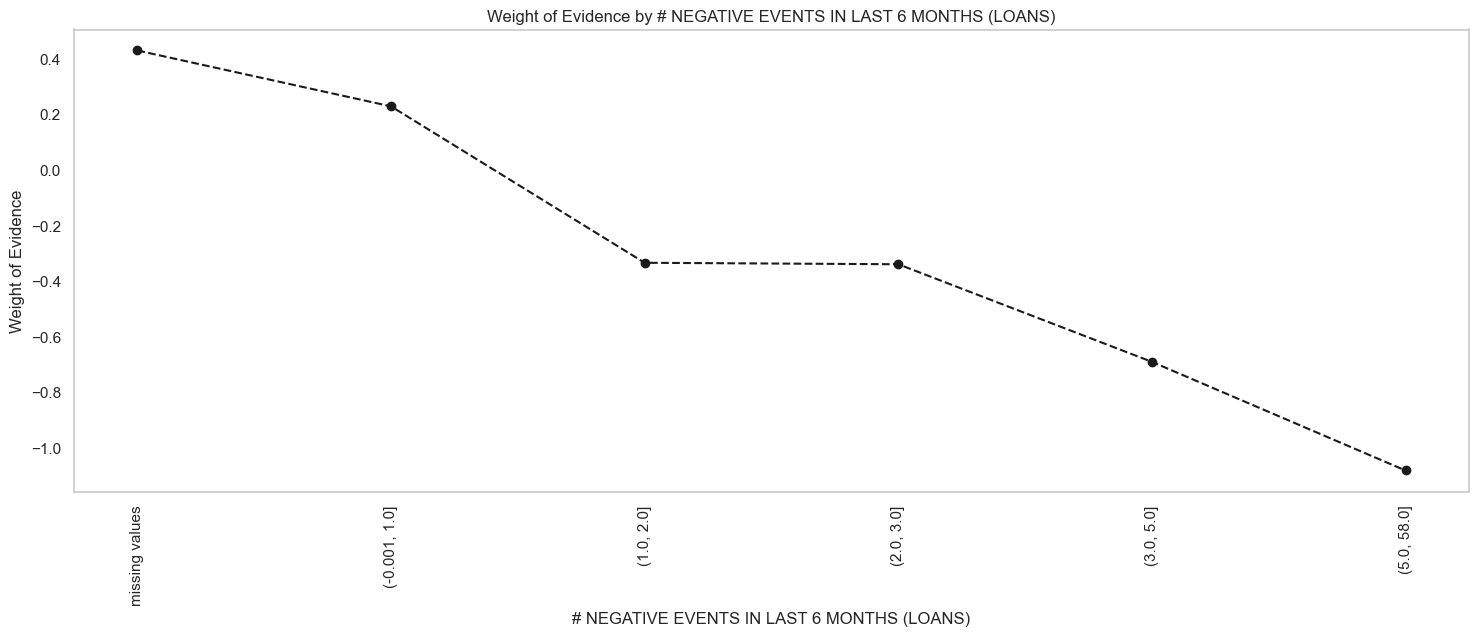

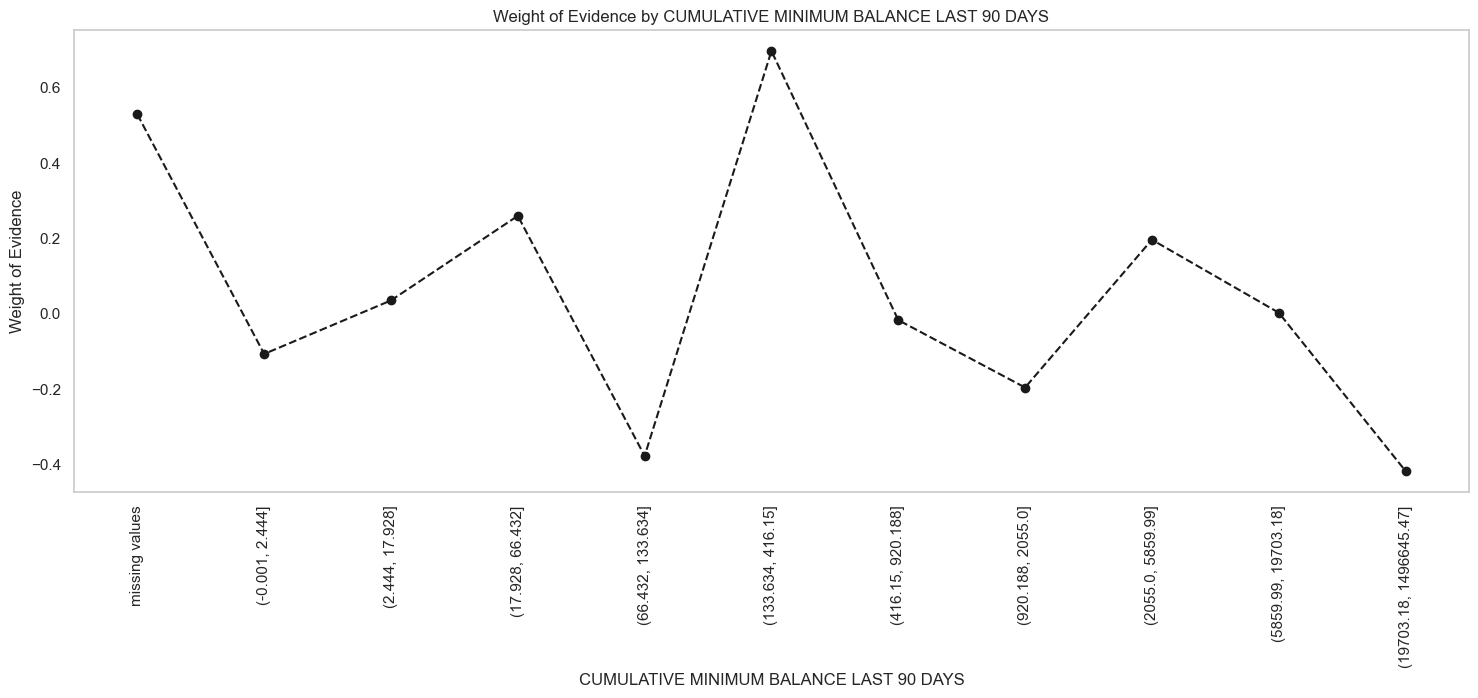

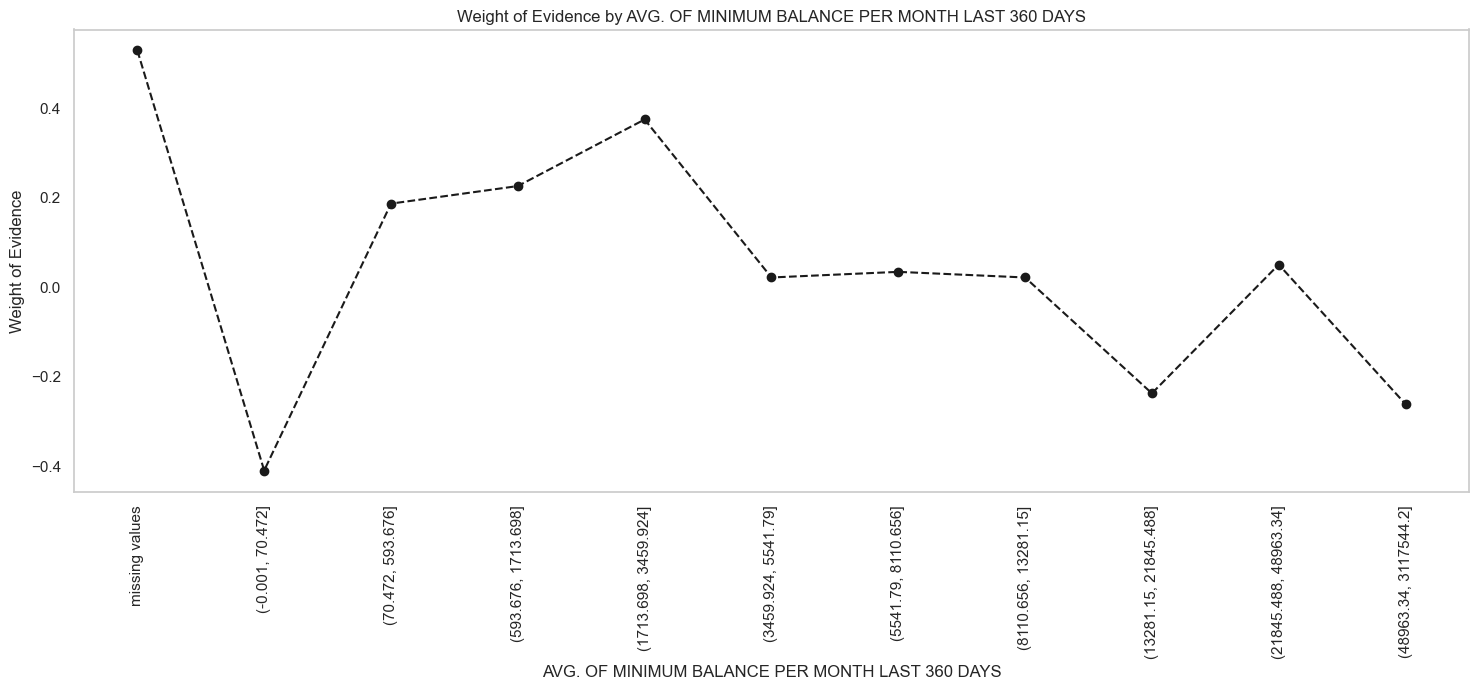

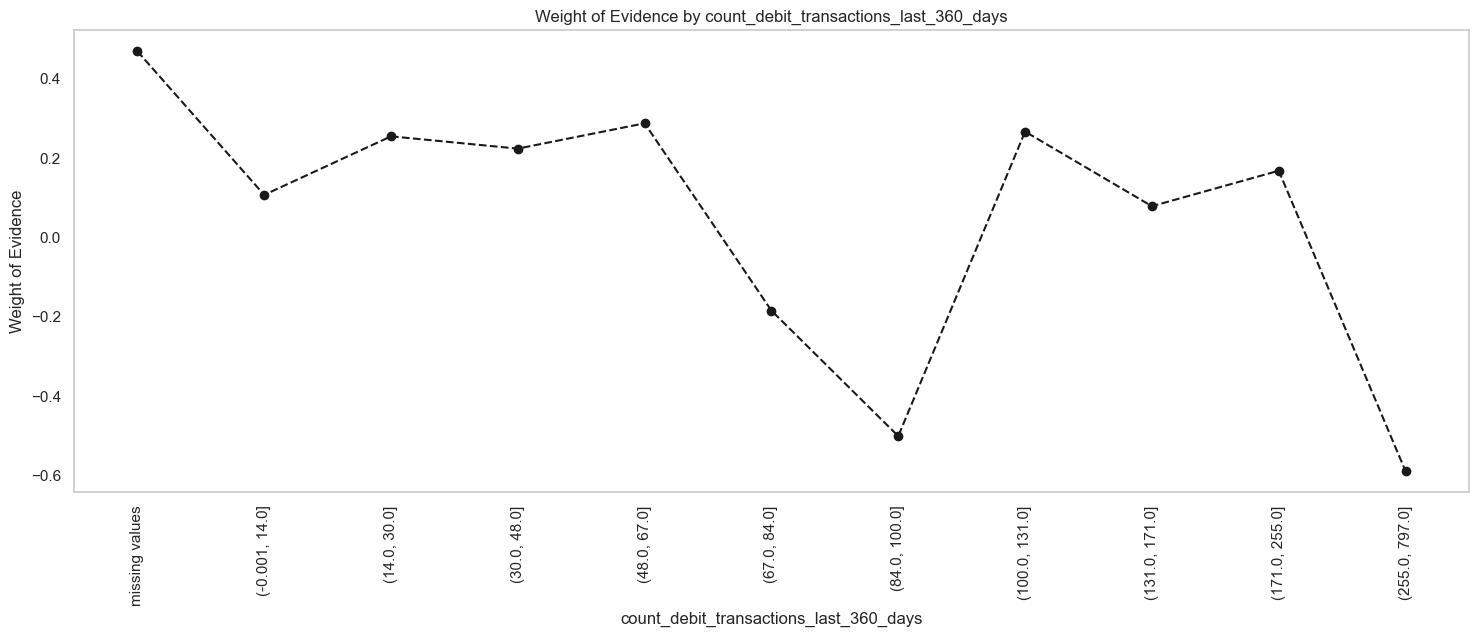

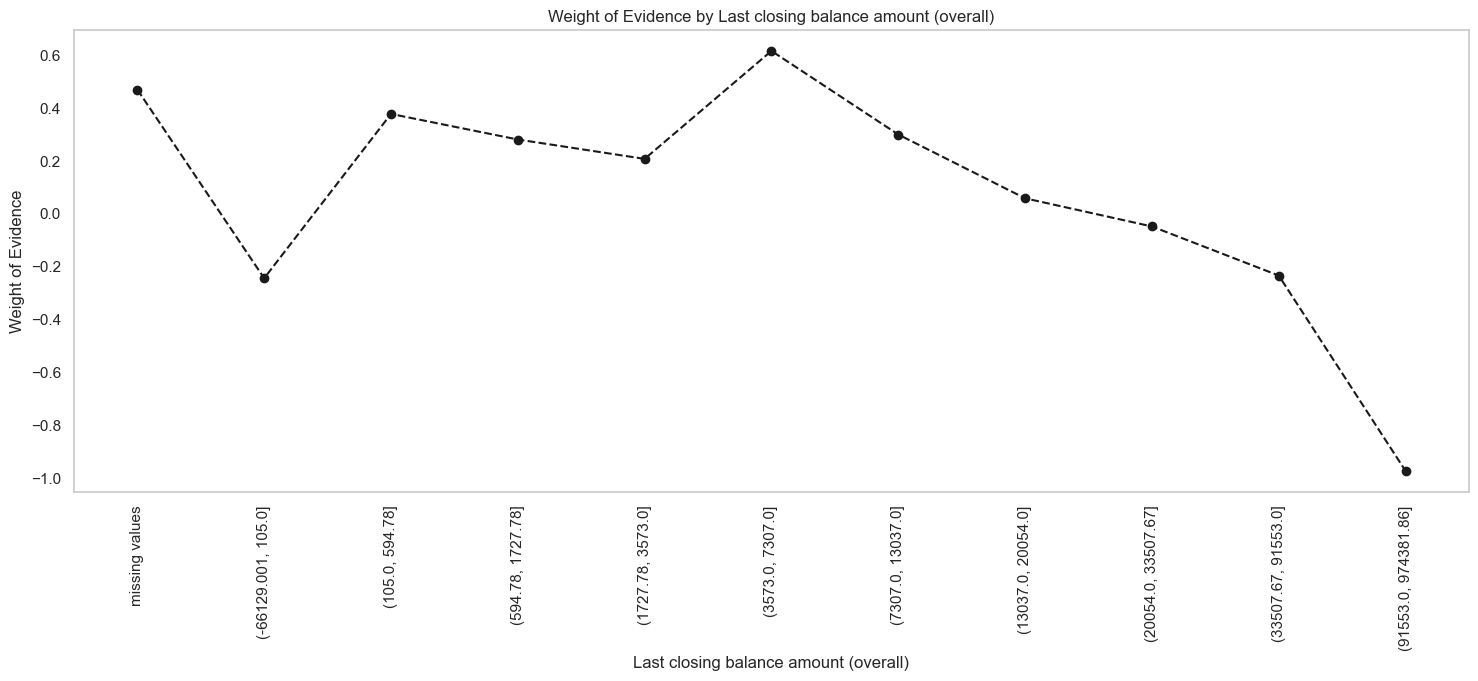

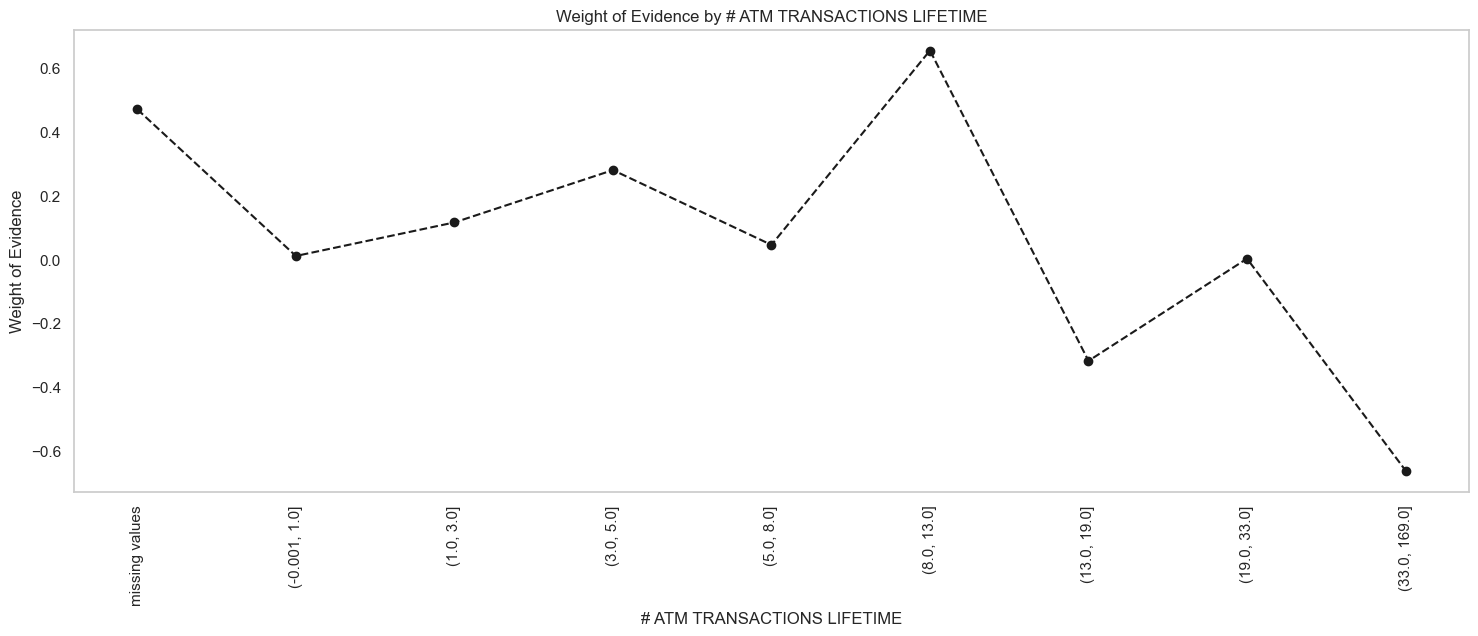

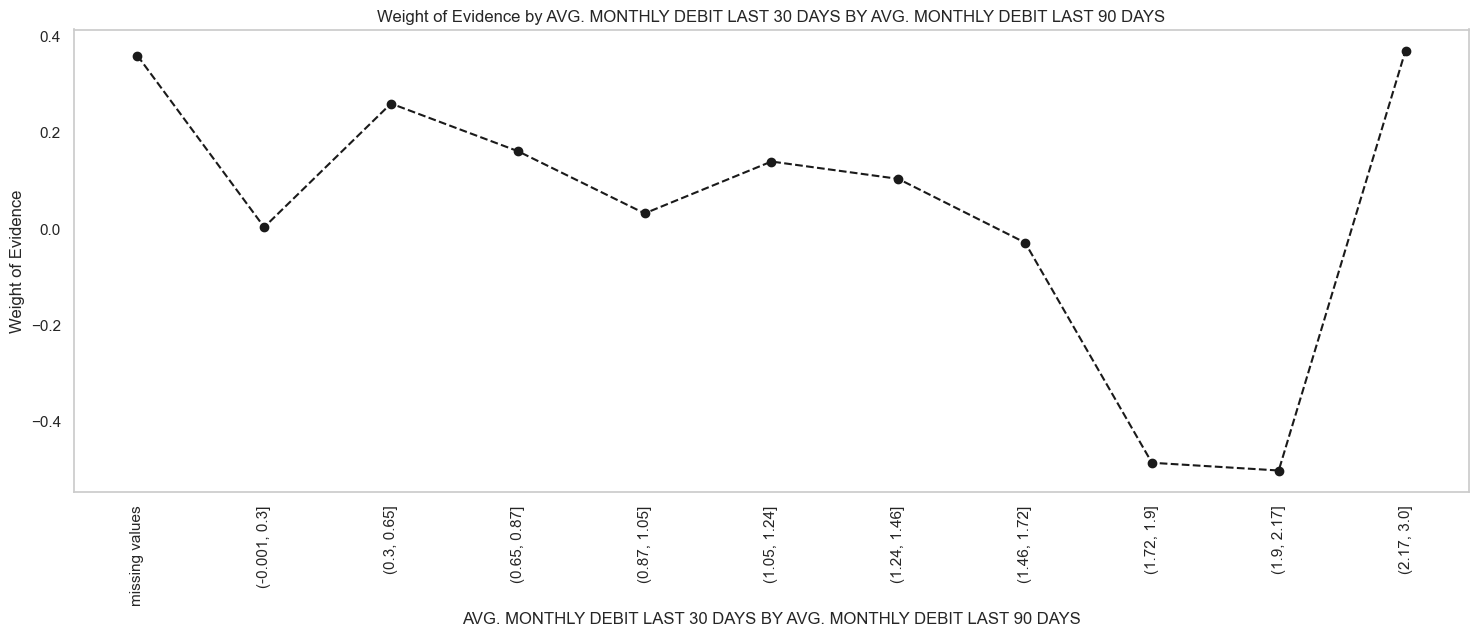

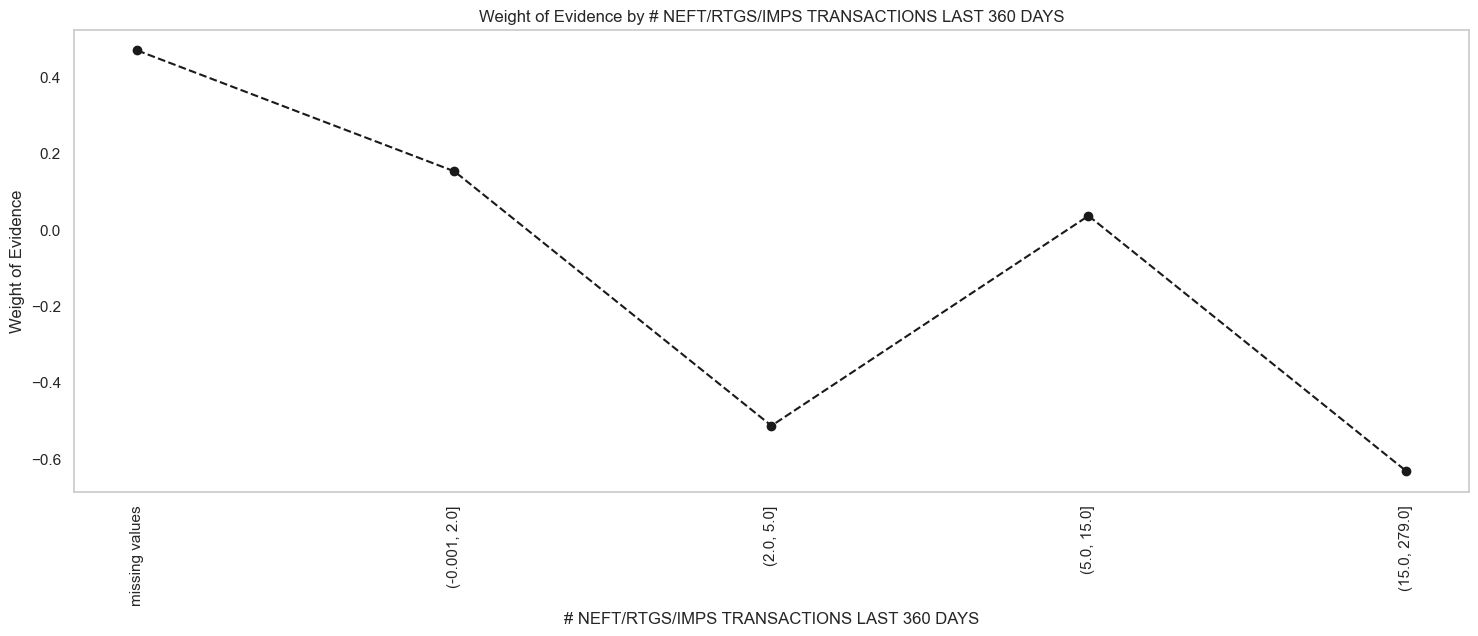

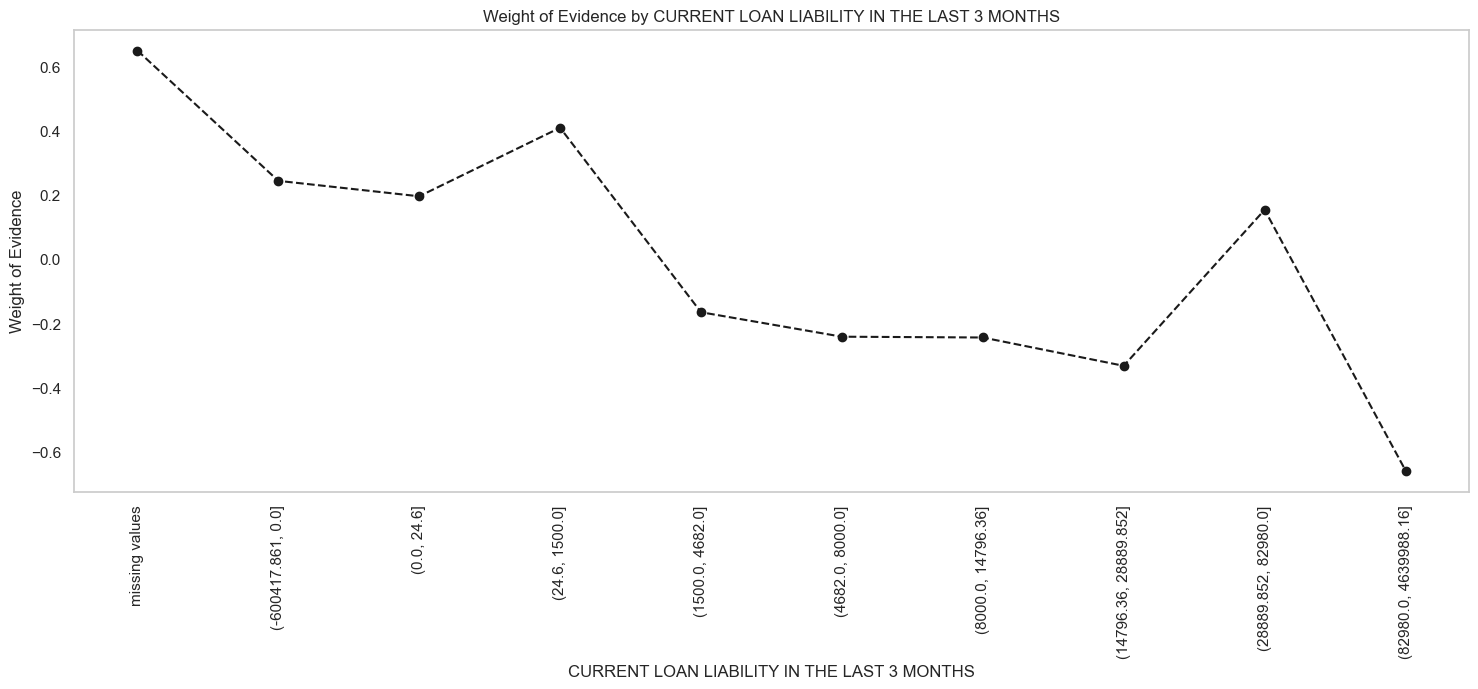

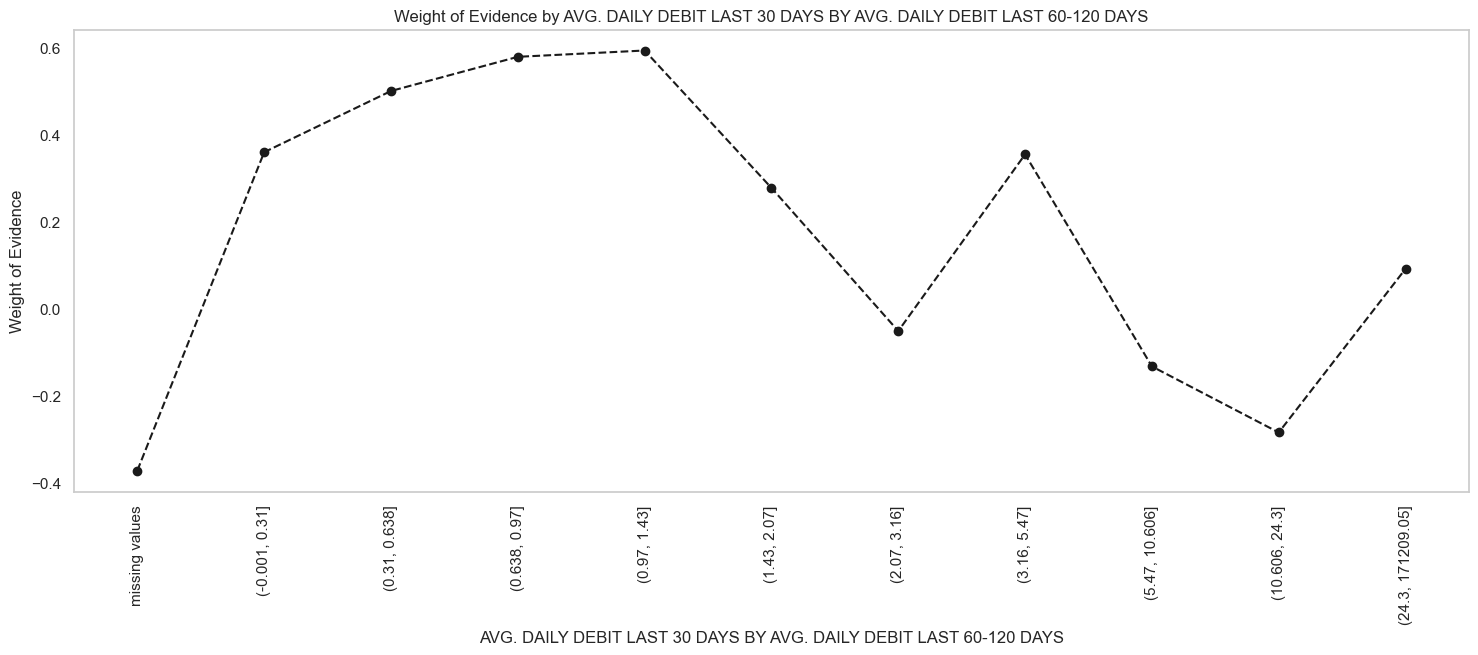

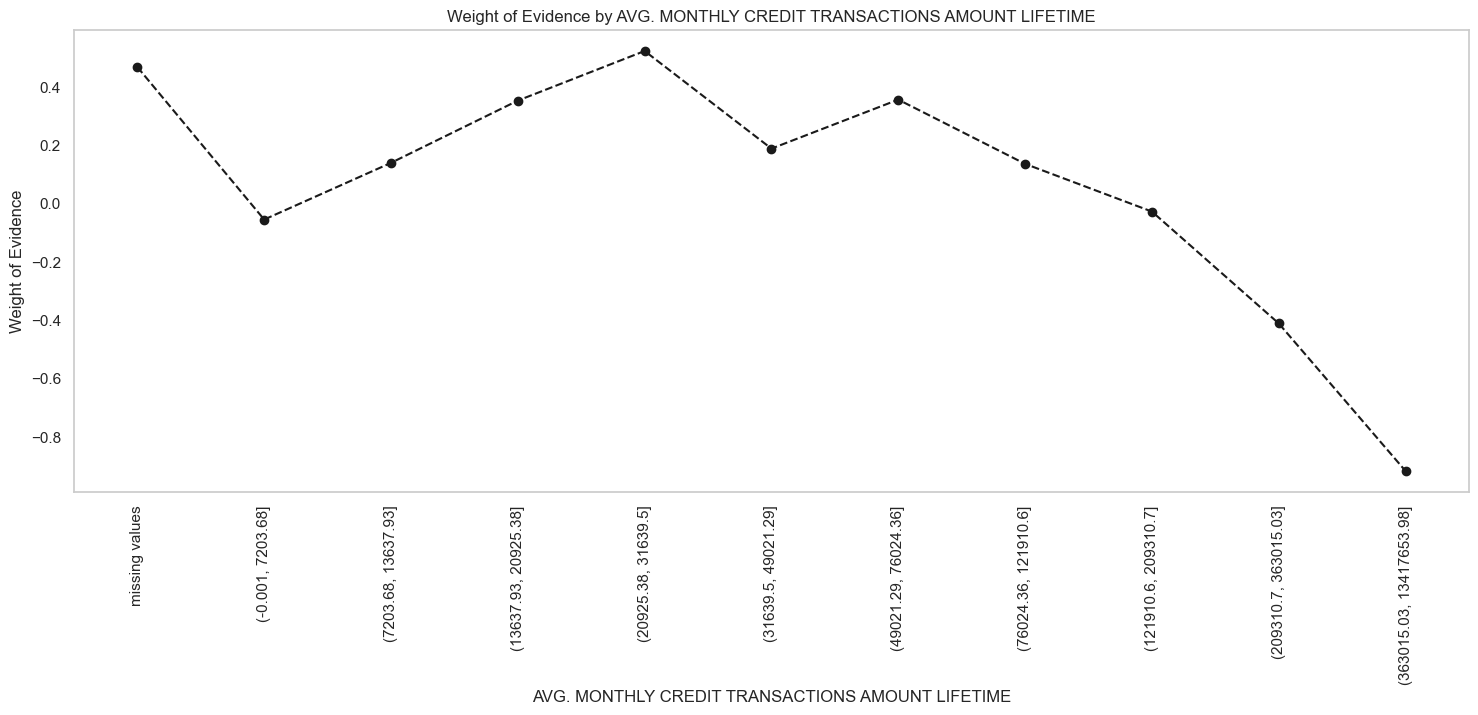

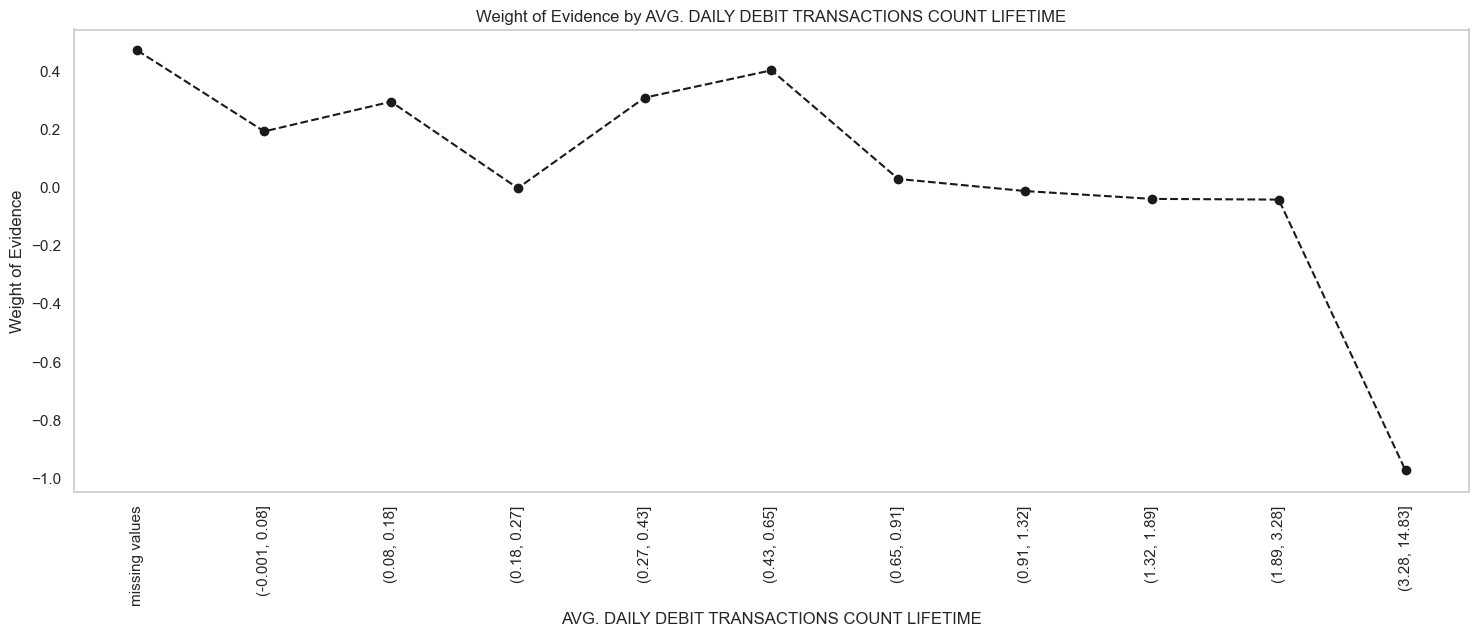

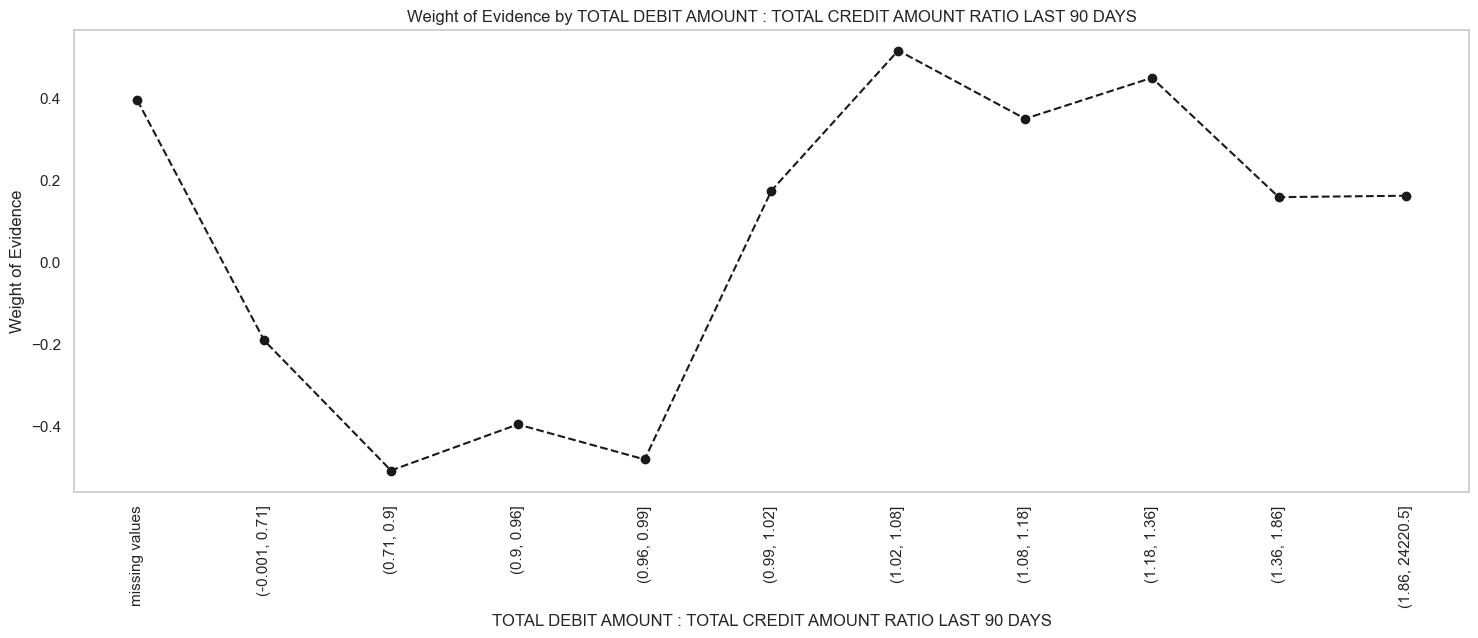

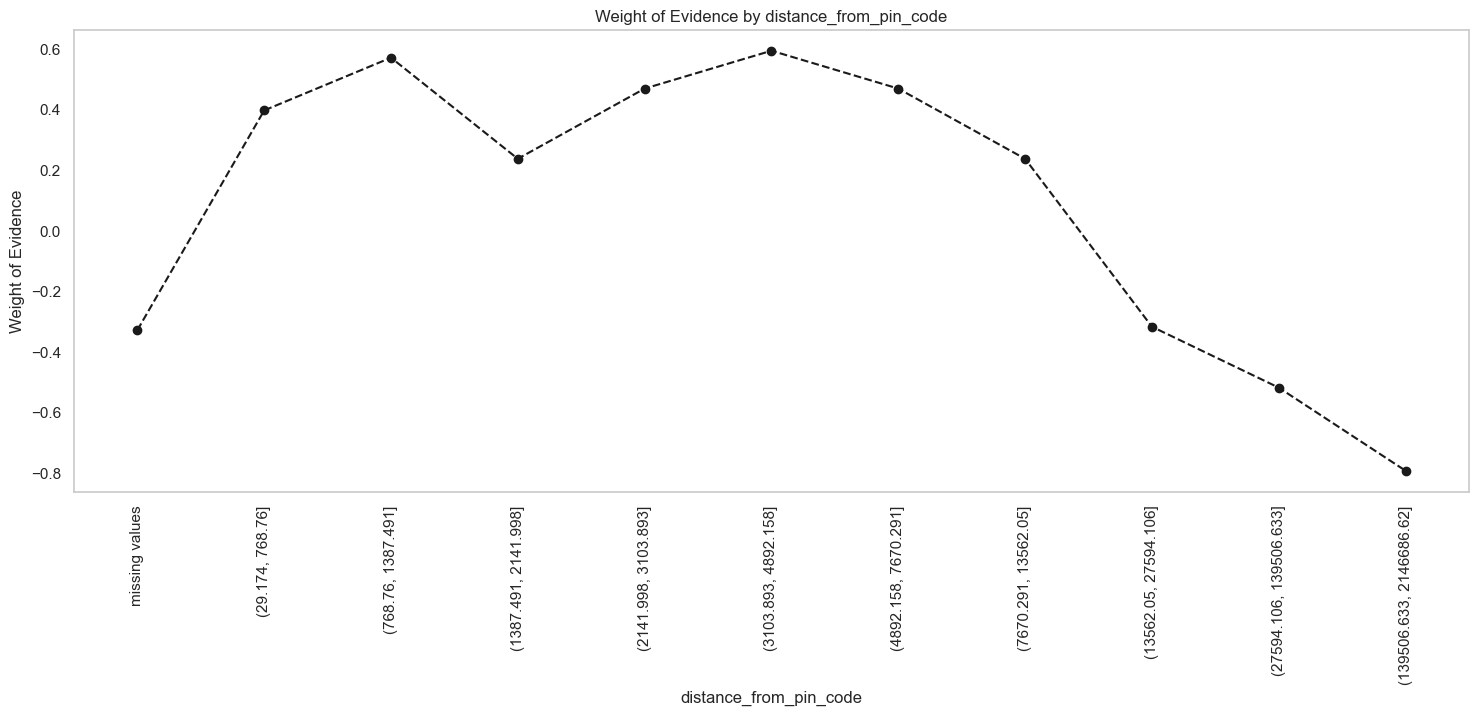

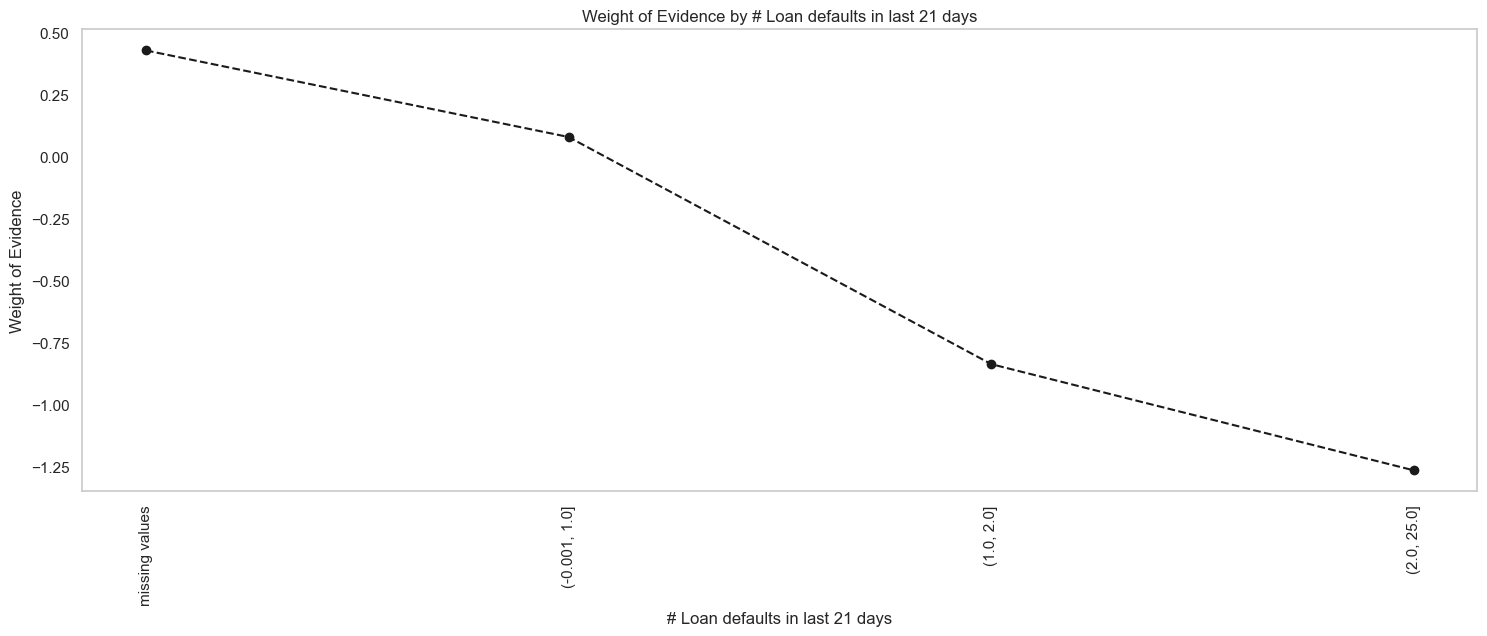

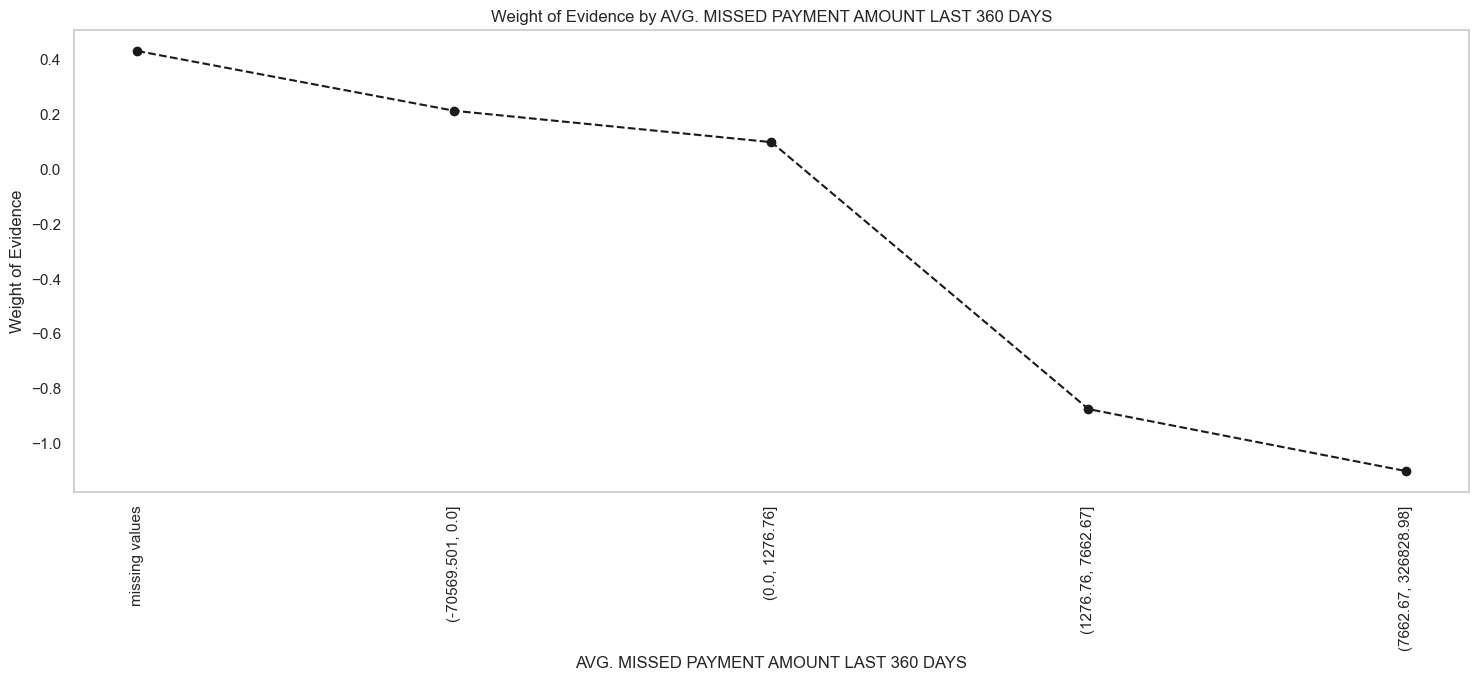

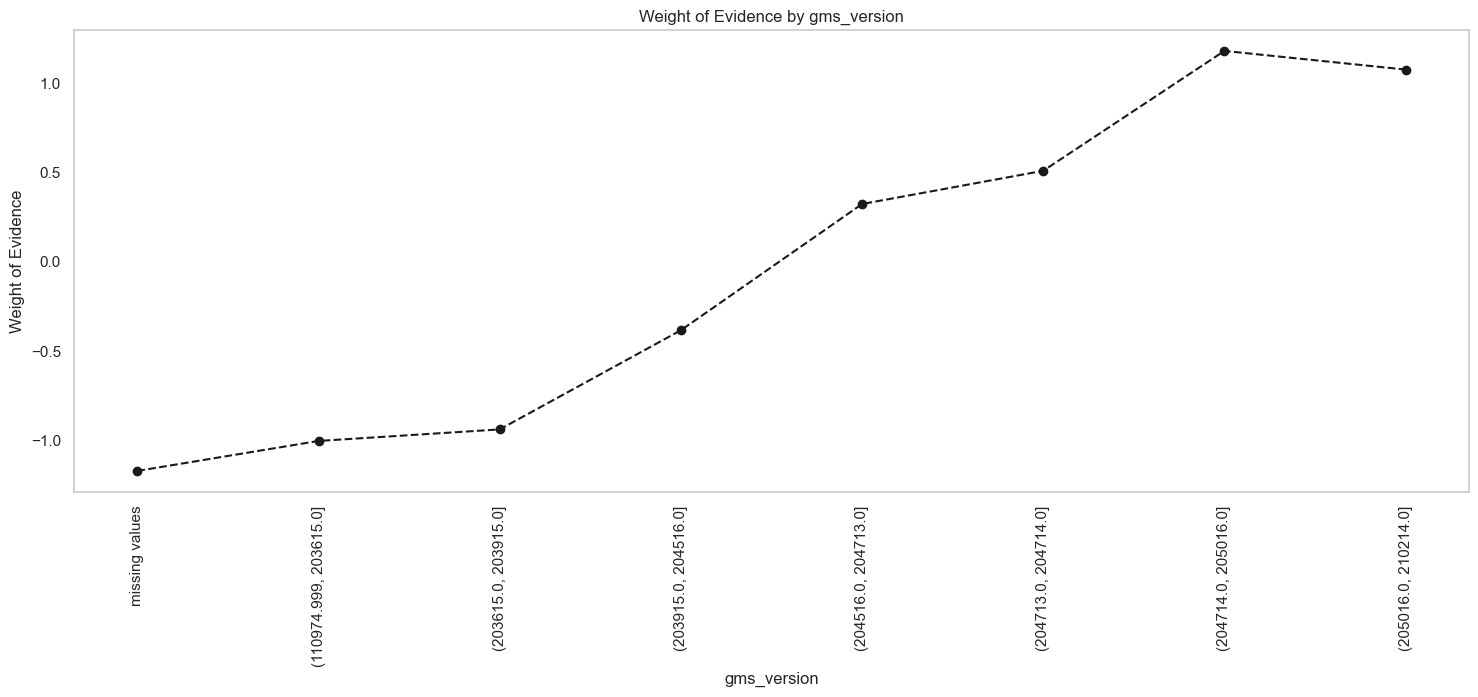

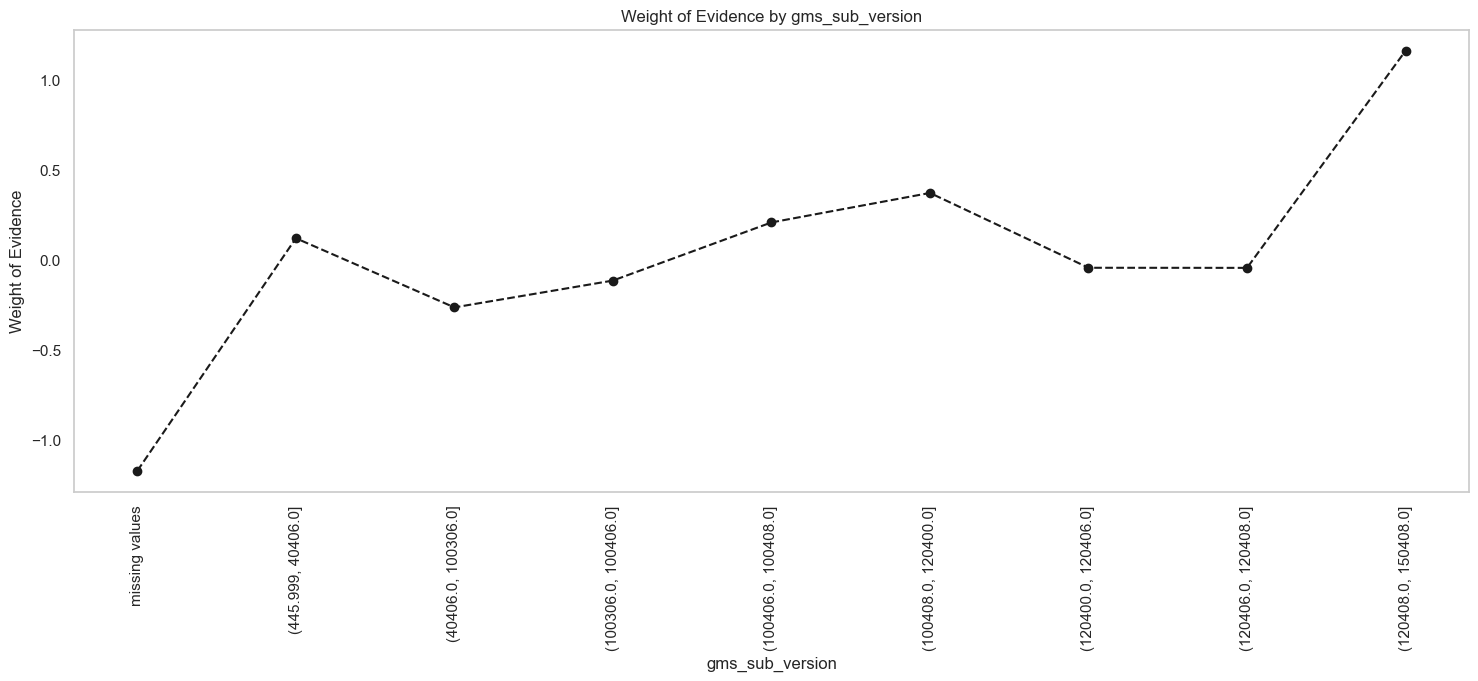

In [1098]:
cols = data.columns
for column in cols[~cols.isin(['default'])]:
    if(data.nunique()[column]>10):
        woe_results_iv=woe_continuous(data, column, data['default'])
    else:
        woe_results_iv=woe_categorical(data, column, data['default'])
    plot_by_woe(woe_results_iv)

<b>The initial WoE plots were plotted above</b>

In [1099]:
def WoETransform(woe_data):
    cols=woe_data.columns
    binsDict={'# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)': [-0.01, 1, 3, 5, float("inf")],
              'CUMULATIVE MINIMUM BALANCE LAST 90 DAYS': [-0.01, 150, 450, 18300, float("inf")],
              'gms_version': [-0.01, 203915, 204516, 204713, 204714, float("inf")],
              'gms_sub_version': [-0.01, 100406, 120408, float("inf")],
              'AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS': [-0.01, 70, 700, 1800, 3600, 13000, 50000, float("inf")],
              'count_debit_transactions_last_360_days': [-0.01, 70, 85, 100, 130, 250, float("inf")],
              'AVG. MONTHLY DEBIT LAST 30 DAYS BY AVG. MONTHLY DEBIT LAST 90 DAYS': [-0.01, 1.7, 1.88, 2.15, 3, float("inf")],
              '# NEFT/RTGS/IMPS TRANSACTIONS LAST 360 DAYS': [-0.01, 2, 5, 15, float("inf")],
             'Last closing balance amount (overall)': [-float("inf"), 100, 3700, 7500, 13000, 35000, float("inf")],
             '# ATM TRANSACTIONS LIFETIME': [-0.01, 3, 8, 13, 33, float("inf")],
             'CURRENT LOAN LIABILITY IN THE LAST 3 MONTHS': [-float("inf"), 40, 15000, 30000, 80000, float("inf")],
             'AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS': [-0.01, 1.5, 2, 5, float("inf")],
             'AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LIFETIME': [-0.01, 7000, 13000, 32000, 125000, 200000, 375000, float("inf")],
             'AVG. DAILY DEBIT TRANSACTIONS COUNT LIFETIME': [-0.01, 0.27, 0.43, 0.65, 3.28, float("inf")],
             'TOTAL DEBIT AMOUNT : TOTAL CREDIT AMOUNT RATIO LAST 90 DAYS': [-0.01, 0.96, 1, 1.02, 1.36, float("inf")],
             'distance_from_pin_code': [0, 2000, 150000, float("inf")],
             '# Loan defaults in last 21 days': [-0.01, 1, 2, float("inf")],
             'AVG. MISSED PAYMENT AMOUNT LAST 360 DAYS': [-float("inf"), 1300, 7500, float("inf")]
             }
    for column in cols[~cols.isin(['default'])]: 
        woe_results_feat_eng=woe_continuous(woe_data, column, woe_data['default'], bins=binsDict[column])
        plot_by_woe(woe_results_feat_eng)
        woe_data['binstemp']=pd.cut(woe_data[column], binsDict[column])
        woe_data['binstemp']=(woe_data['binstemp'].cat.add_categories('missing values').fillna('missing values'))
        woe_results_feat_eng.rename(columns={column:'CurrentCol'}, inplace=True)
        woe_data=woe_data.merge(woe_results_feat_eng.loc[:,['CurrentCol', 'WoE']], left_on='binstemp', right_on='CurrentCol')
        woe_data.drop(columns=['binstemp', 'CurrentCol', column], inplace=True)
        woe_data.rename(columns={'WoE':column}, inplace=True)
    return woe_data

<b>The above code merges the appropriate bins on the basis of the criteria discussed above. </b>

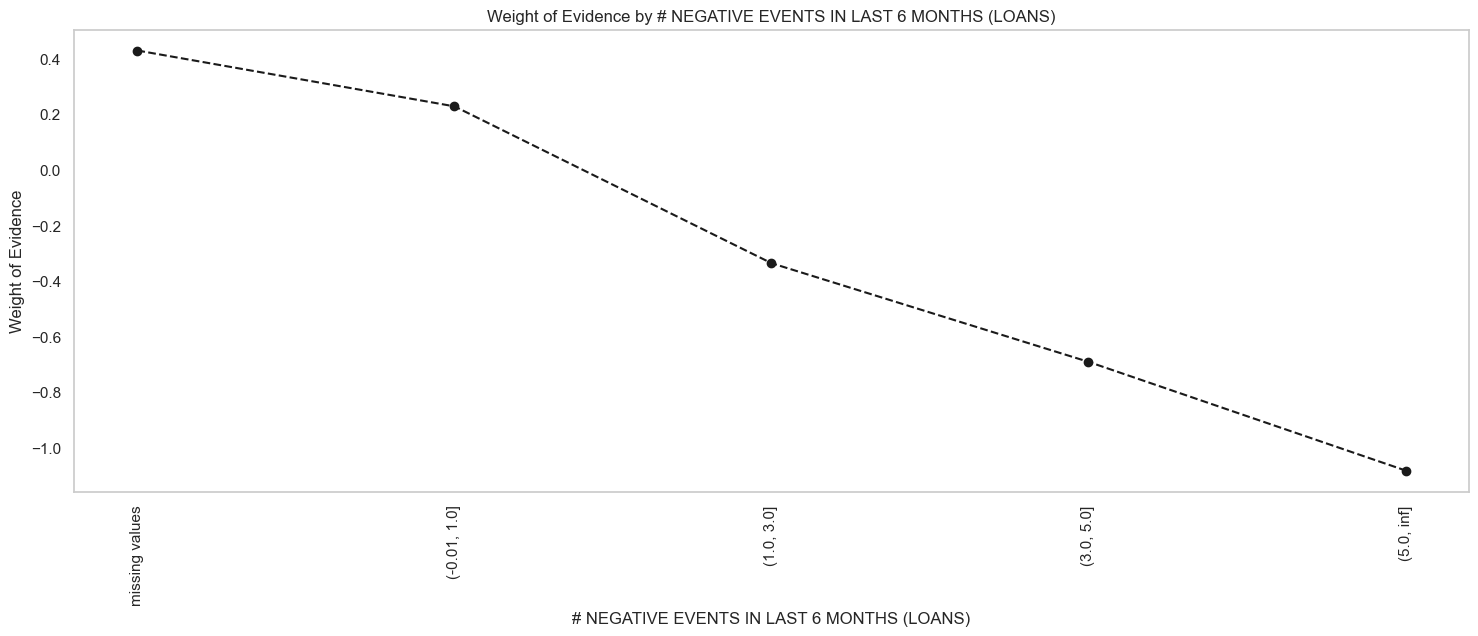

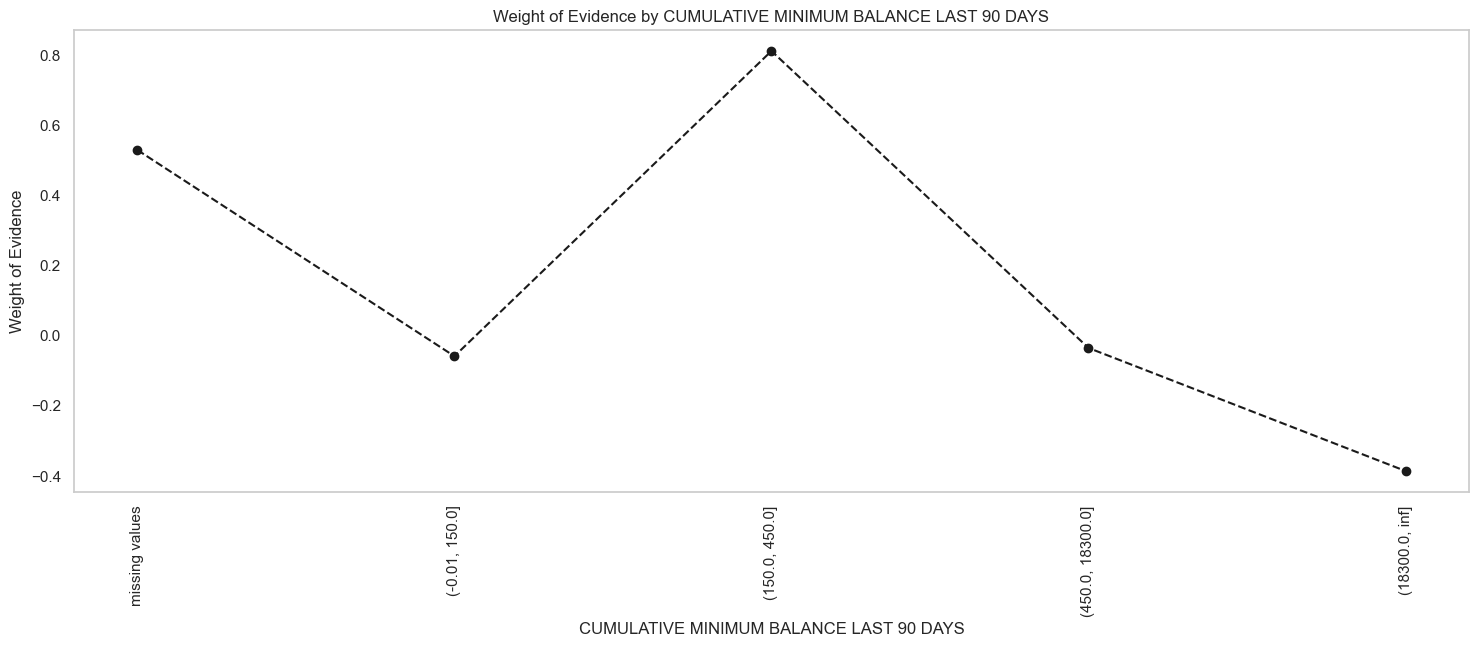

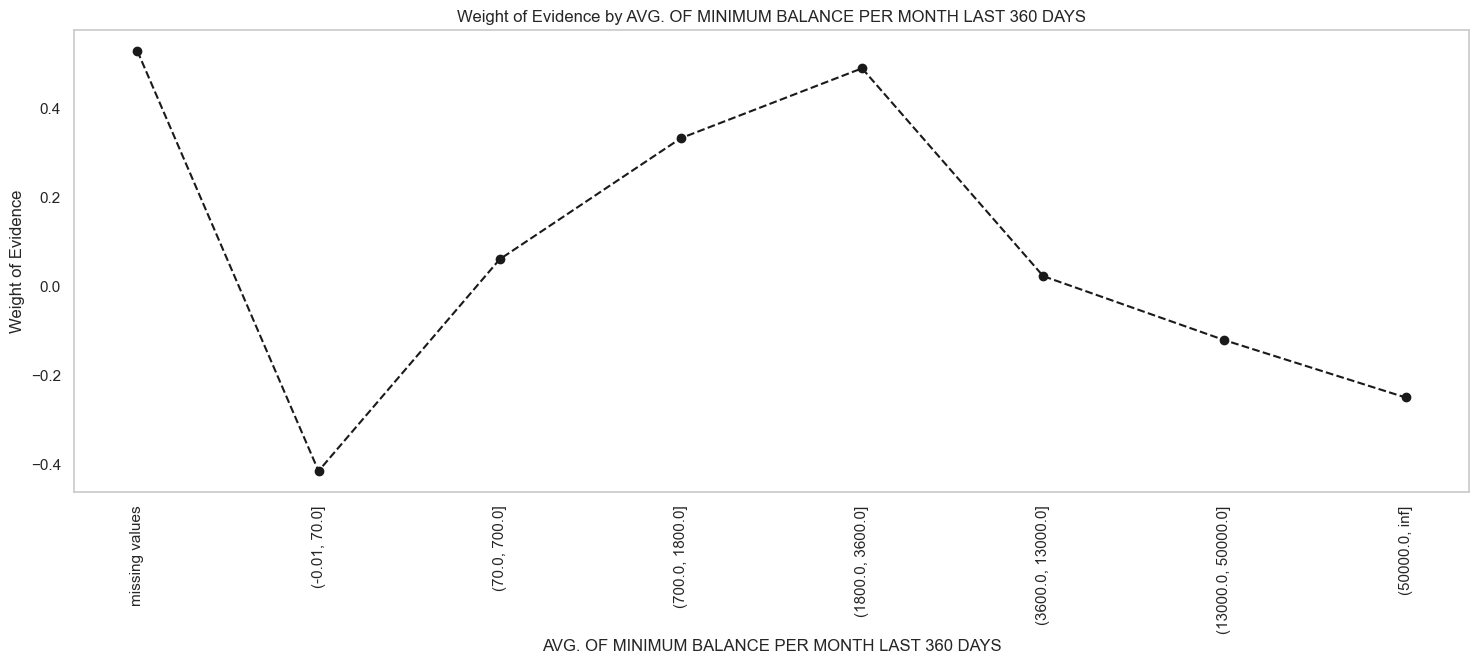

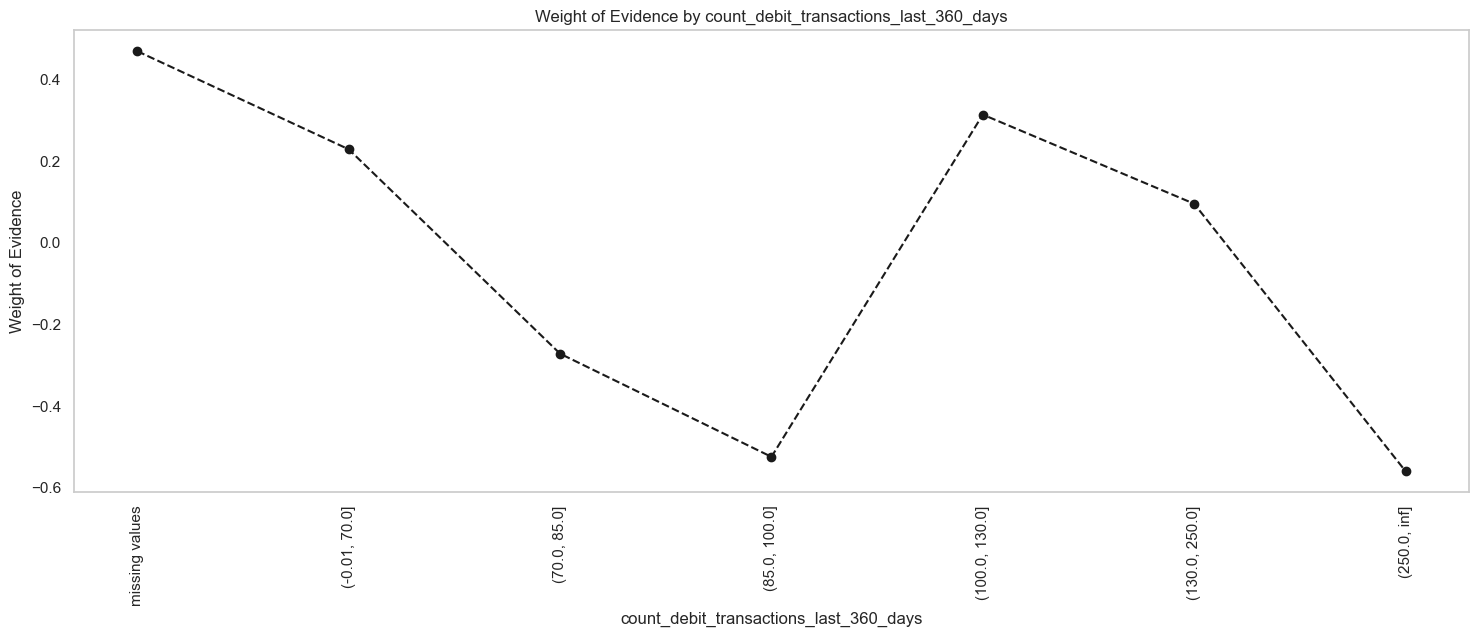

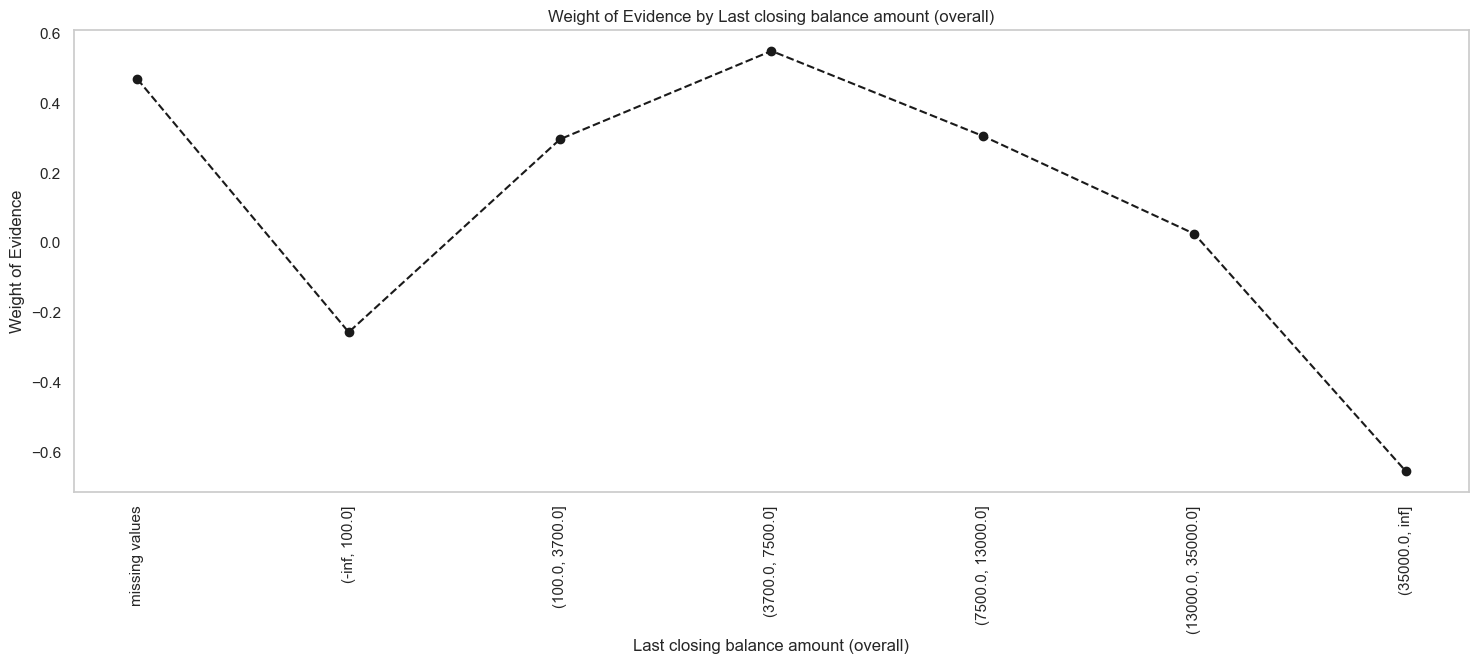

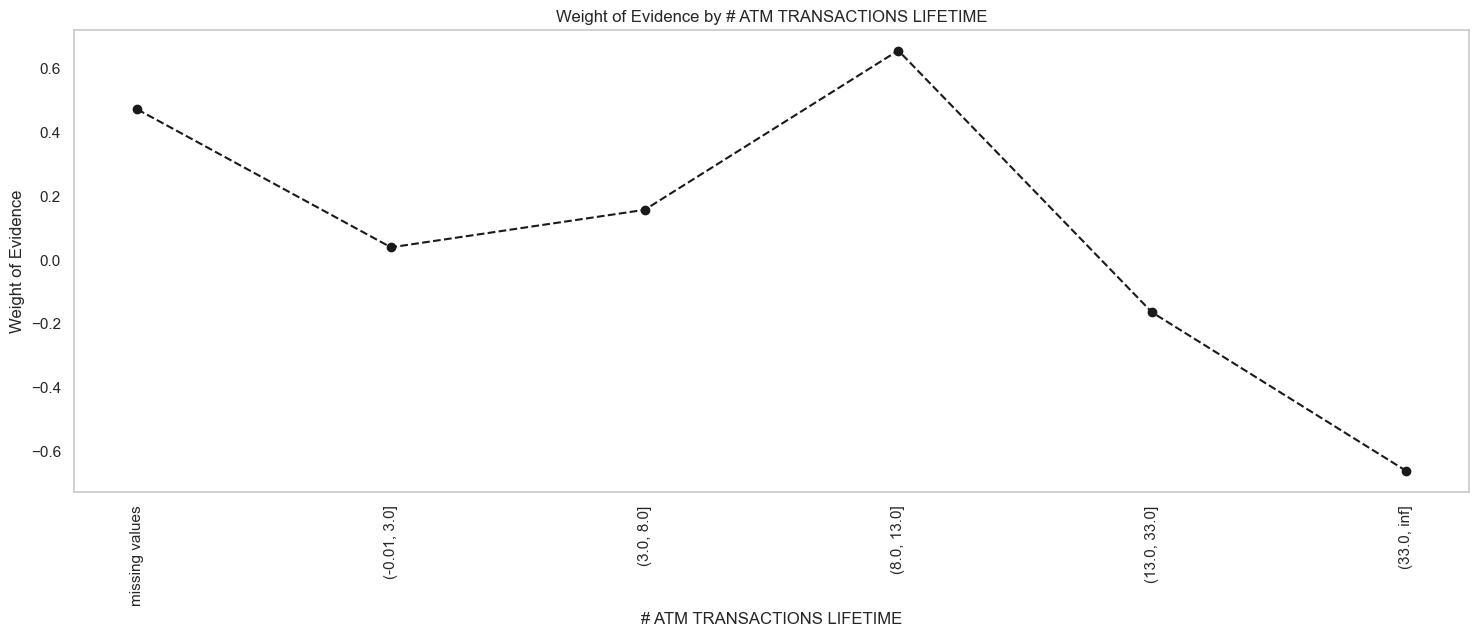

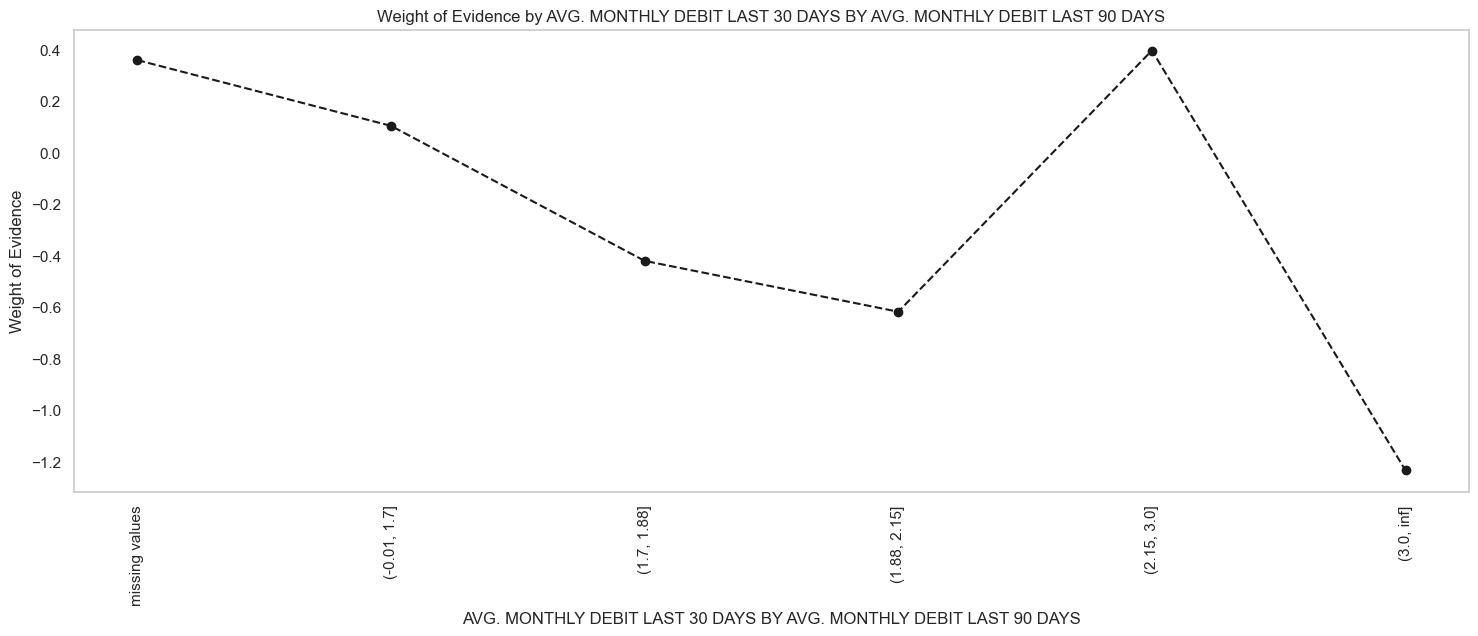

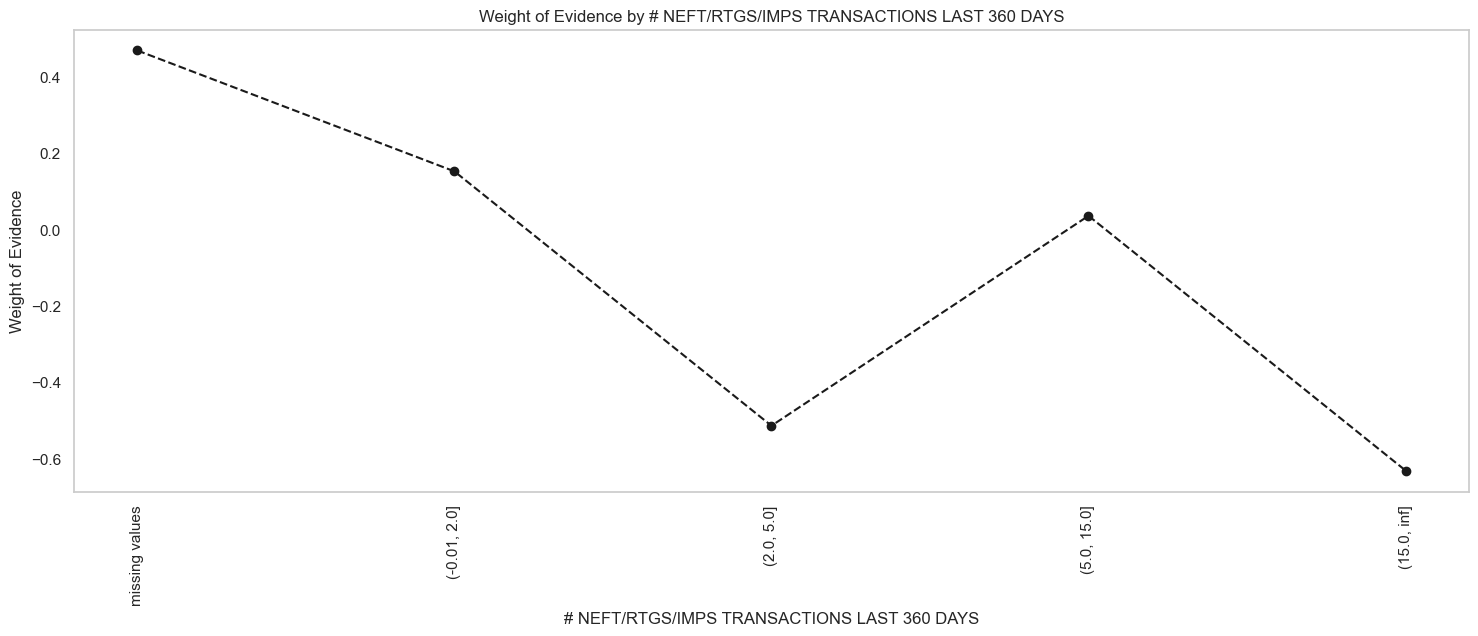

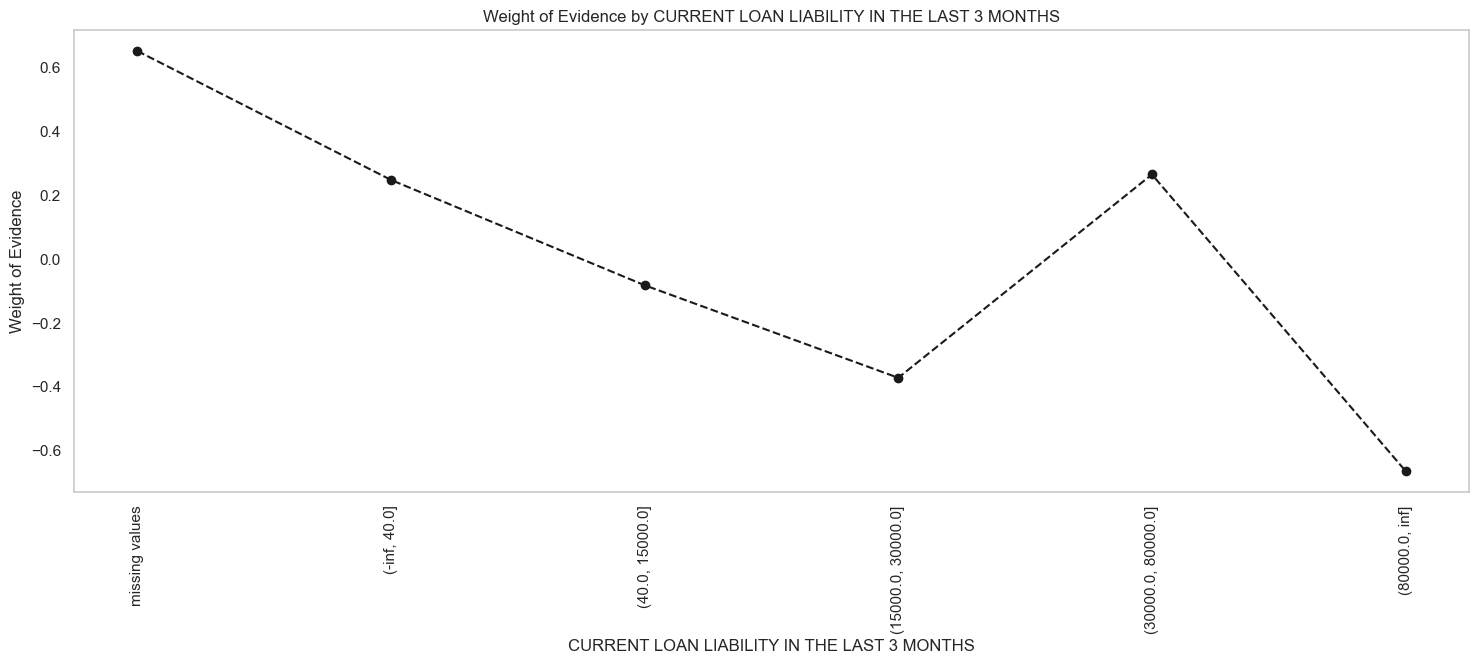

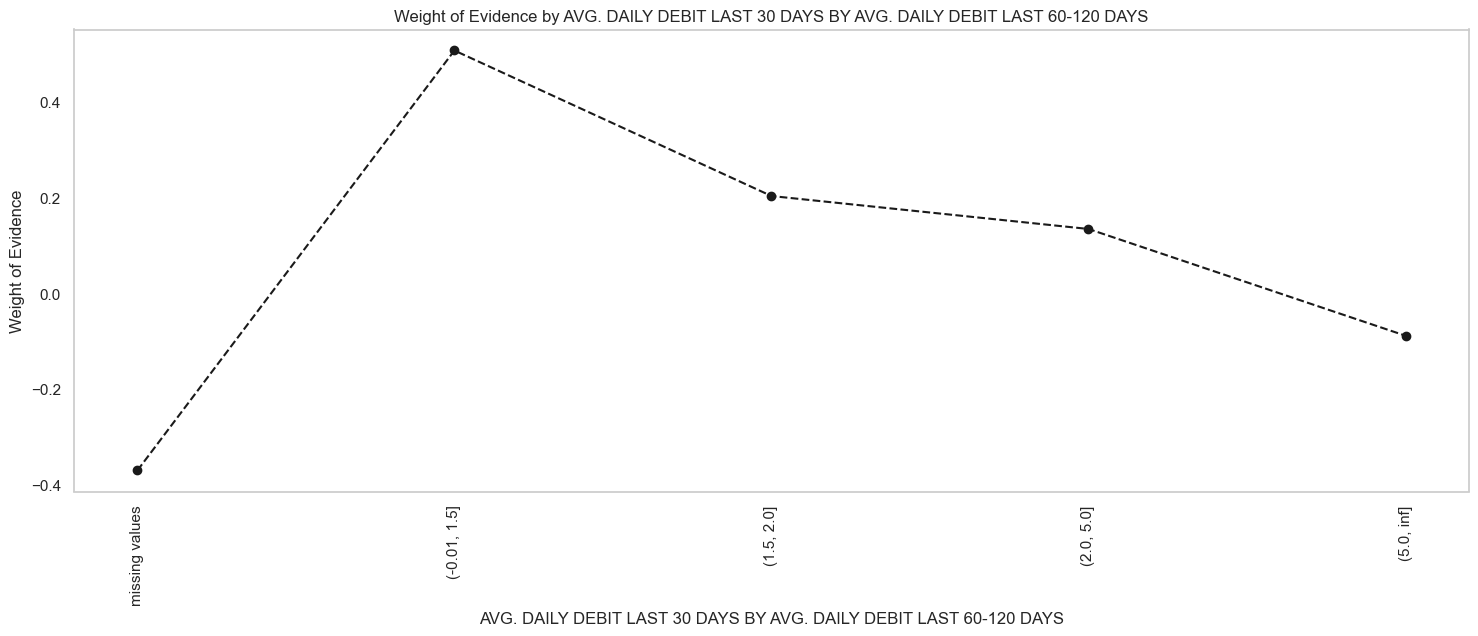

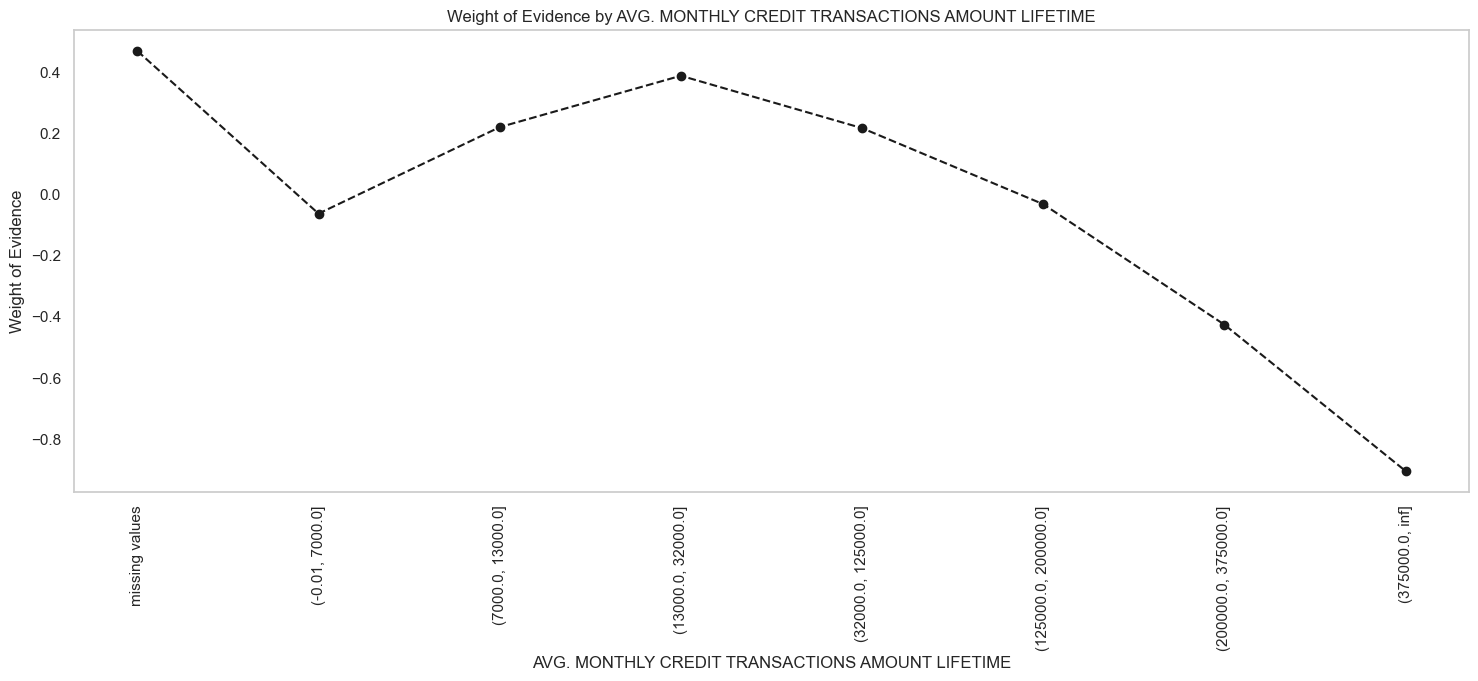

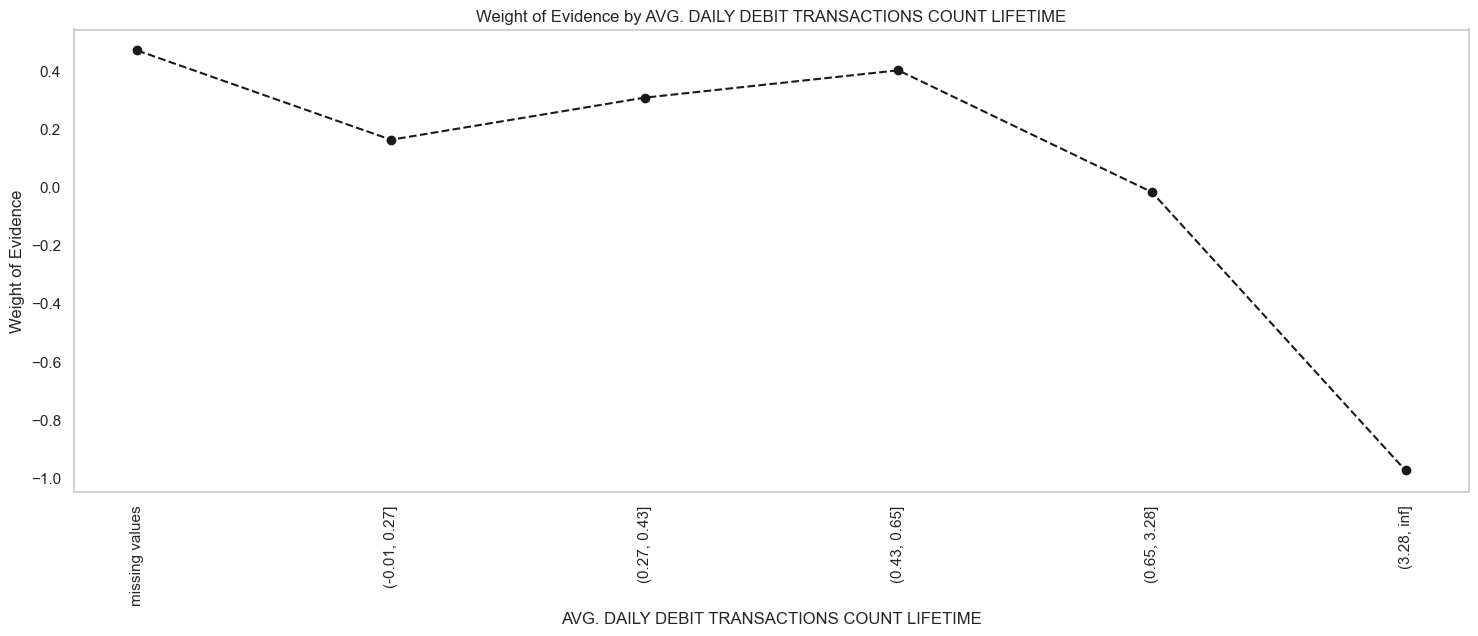

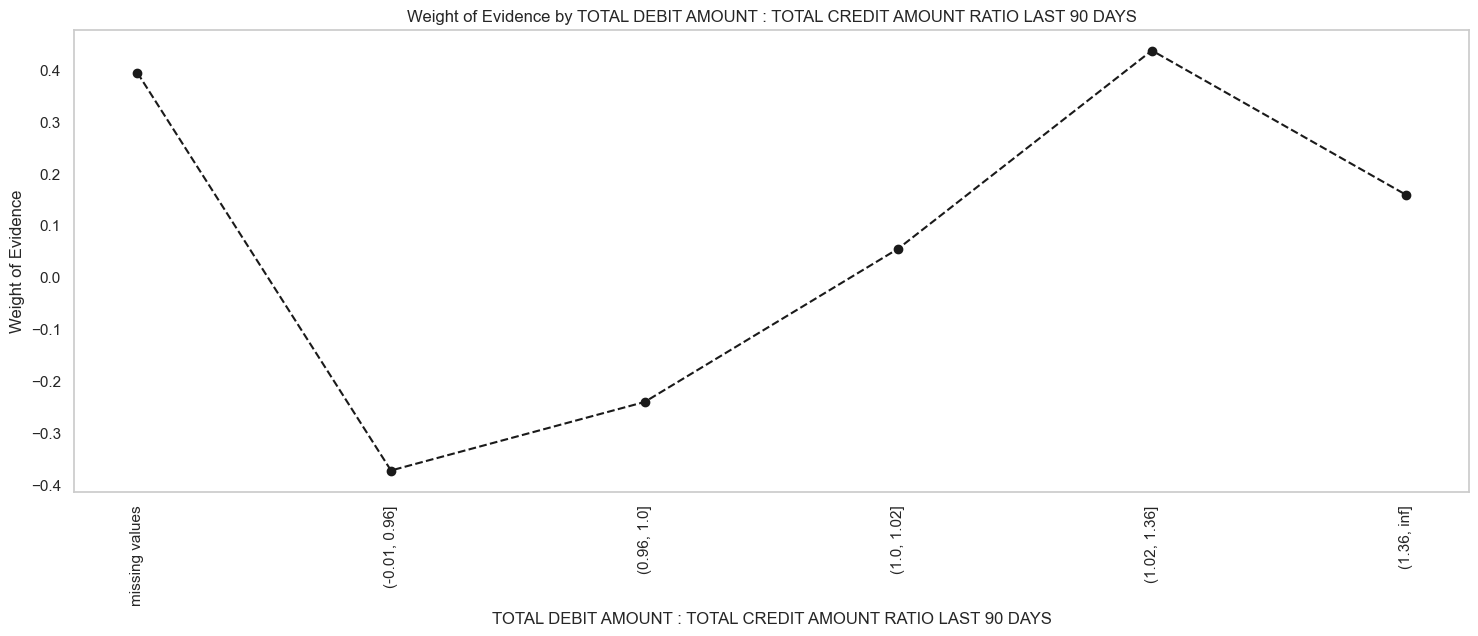

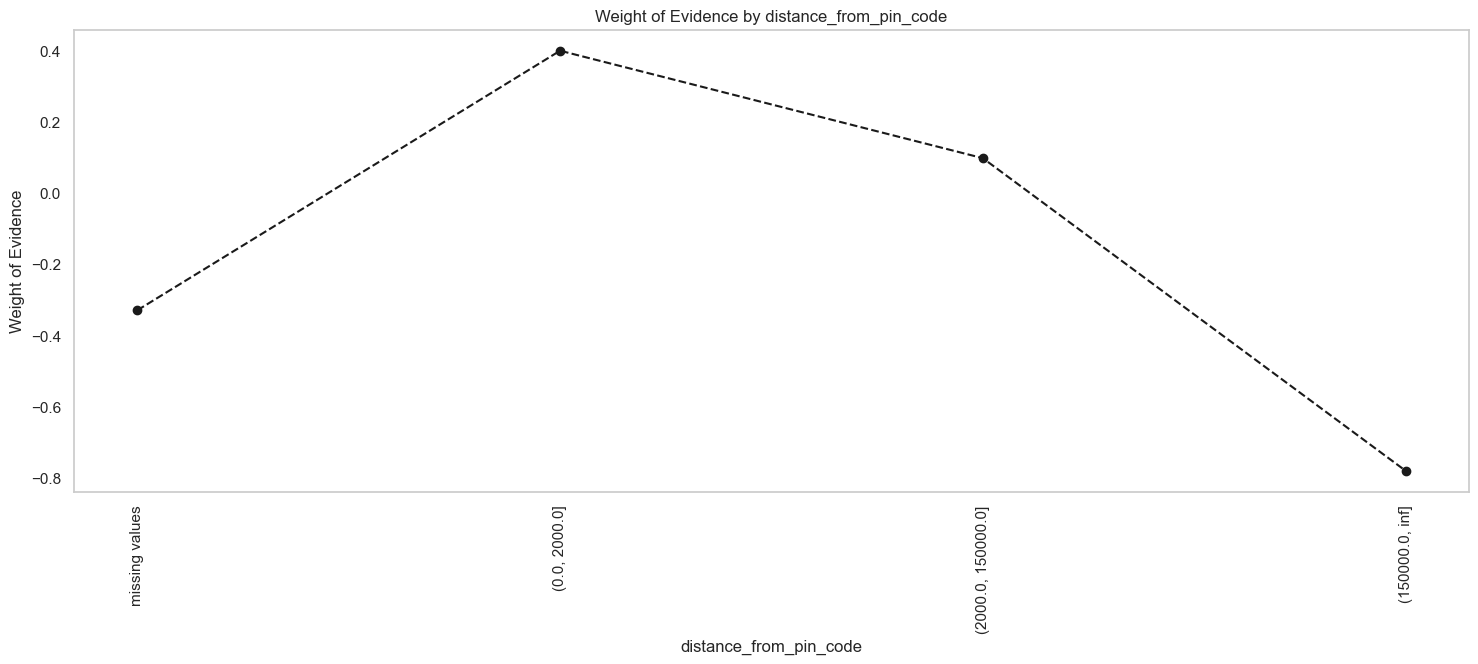

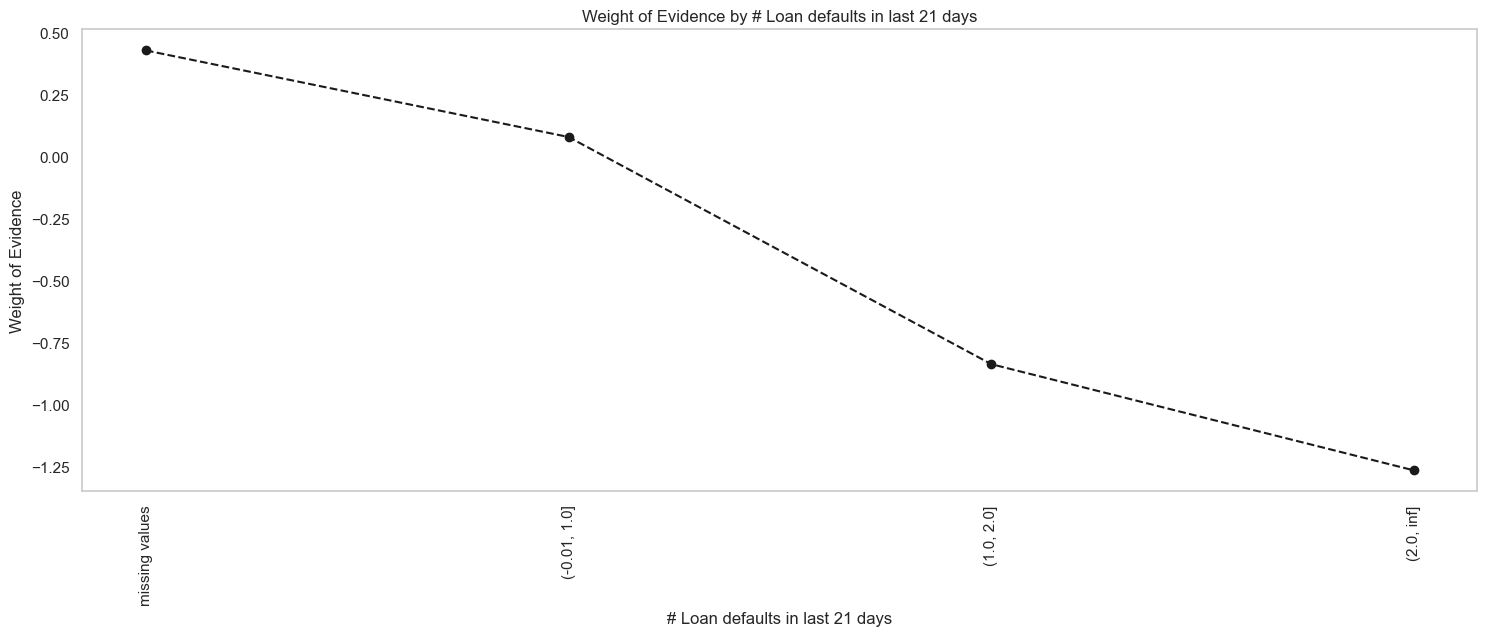

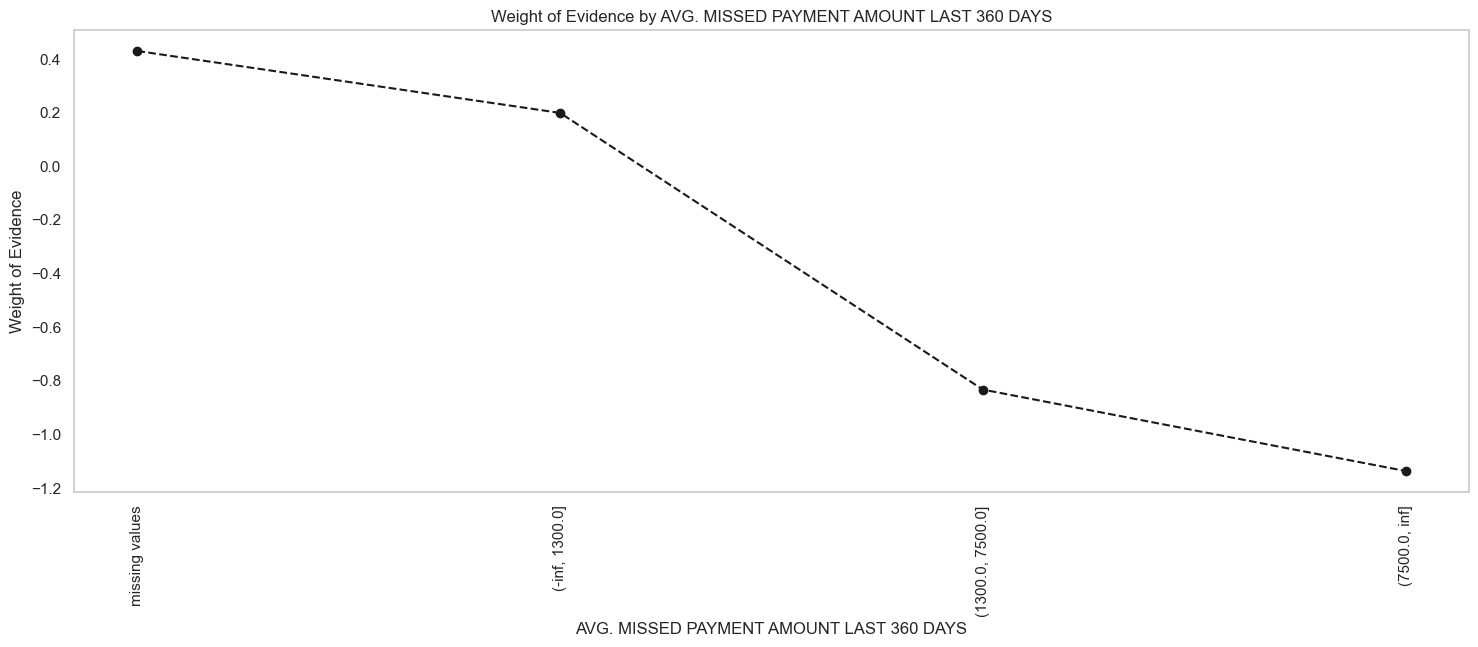

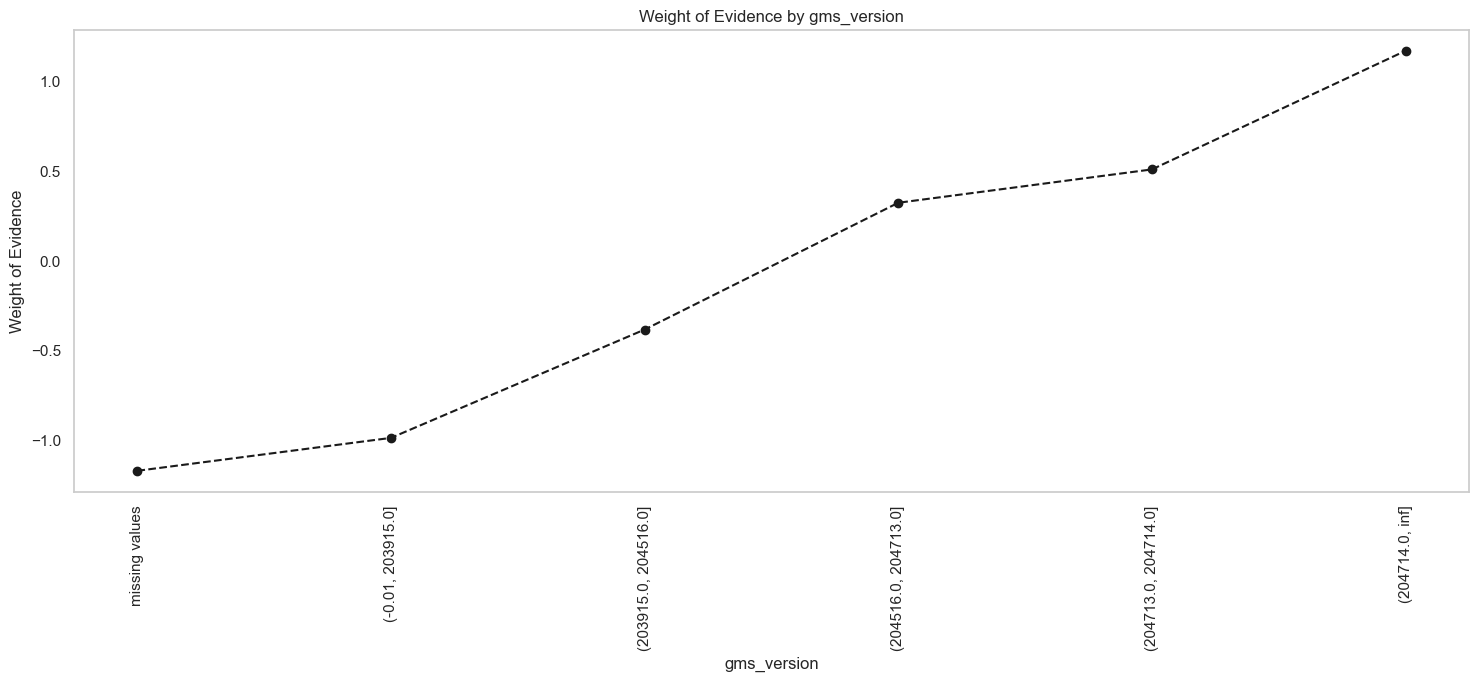

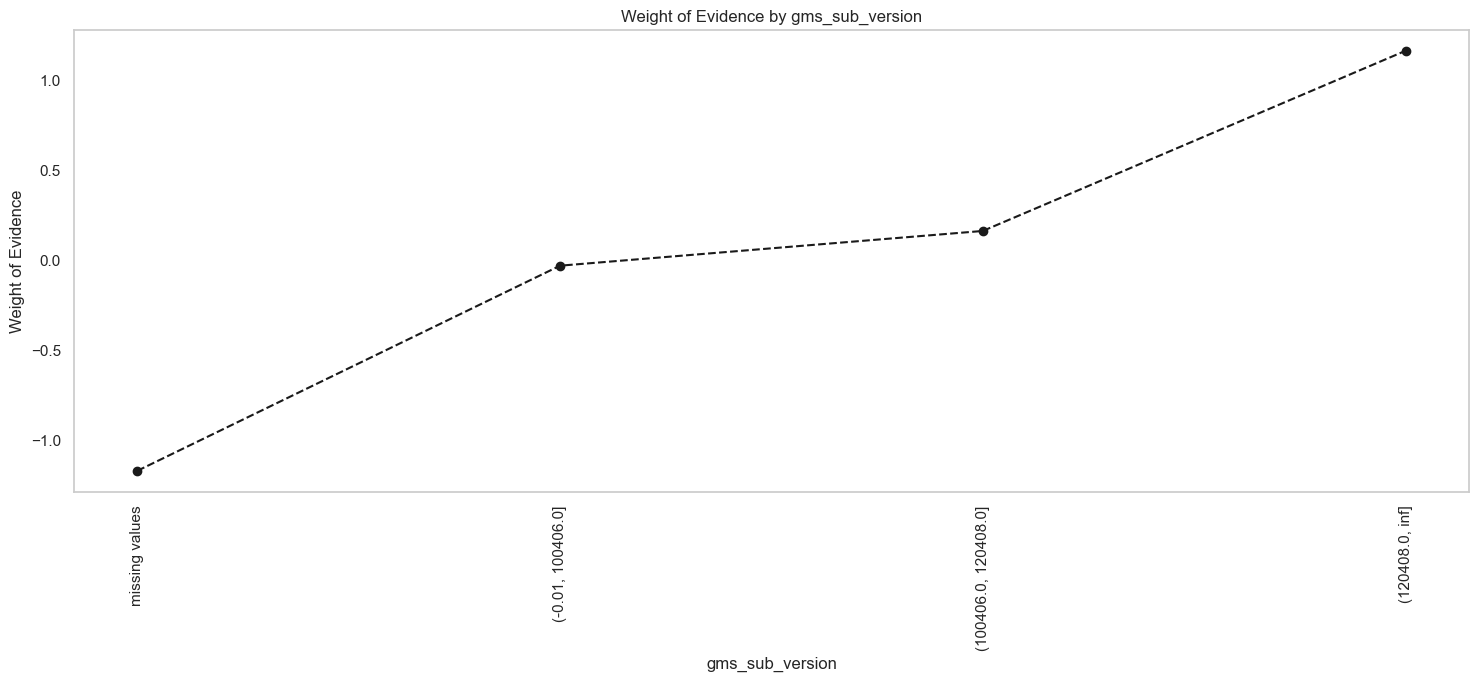

In [1100]:
data=WoETransform(data)

<b>Here we see the final WoE plots.
<p>Please note that the final bin in each variable is the category for missing values which we had retained to check or information, if any (since the WoE method can handle missing values very easily). We see that the missing values category is quite informative in most of these cases</p><p> <b><u>Please note that these bins for missing values do not break monotonicity even though they appear to do so, because they are simply a non-ordinal bin in each variable</u></b></p></b>

# Data Pipeline Creation and Model Building

We will first create the class that will be used to create the data processing pipeline. We will include all the data processing / feature engineering functions above in this class as well. Note that we have not included the feature selection procedure in the pipelines because that involved a lot of subjective analysis.

After this we will fit a Logistic Regression model on the transformed data.

In [1104]:
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, binDict=None, binData=None): # no *args or *kargs
        self.binDict=binDict
        self.binData=binData
        pass
    def woe_continuous(self, inputdf, continuous_variabe_name, y_df, bins=None):
        df=inputdf.copy()
        if bins is None:
            df['col_buckets']=pd.qcut(df[continuous_variabe_name], 10, duplicates='drop')
        else:
            df['col_buckets']=pd.cut(df[continuous_variabe_name], bins)
        df['col_buckets']=(df['col_buckets'].cat.add_categories('missing values').fillna('missing values'))
        df[continuous_variabe_name]=df['col_buckets']
        df.drop(columns=['col_buckets'], inplace=True)
        df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
        df = pd.concat([df.groupby(df.columns.values[0], as_index = False, dropna=False)[df.columns.values[1]].count(),
                        df.groupby(df.columns.values[0], as_index = False, dropna=False)[df.columns.values[1]].mean()], axis = 1)
        df = df.iloc[:, [0, 1, 3]]
        df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
        df['prop_good']=df.apply(lambda x: 0 if x['n_obs']==0 else (1-x['prop_good']), axis=1)
        df['prop_n_obs'] = np.maximum(df['n_obs'], 0.5) / df['n_obs'].sum()
        df['n_good'] = df['prop_good'] * df['n_obs']
        df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
        df['prop_n_good'] = np.maximum(df['n_good'], 0.5) / df['n_good'].sum()
        df['prop_n_bad'] = np.maximum(df['n_bad'], 0.5) / df['n_bad'].sum()
        df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
        df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
        df['IV'] = df['IV'].sum()
        return df
    def fit(self, X, y=None):
        self.X=X
        cols=X.columns
        binsDict={'# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)': [-0.01, 1, 3, 5, float("inf")],
              'CUMULATIVE MINIMUM BALANCE LAST 90 DAYS': [-0.01, 150, 450, 18300, float("inf")],
              'gms_version': [-0.01, 203915, 204516, 204713, 204714, float("inf")],
              'gms_sub_version': [-0.01, 100406, 120408, float("inf")],
              'AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS': [-0.01, 70, 700, 1800, 3600, 13000, 50000, float("inf")],
              'count_debit_transactions_last_360_days': [-0.01, 70, 85, 100, 130, 250, float("inf")],
              'AVG. MONTHLY DEBIT LAST 30 DAYS BY AVG. MONTHLY DEBIT LAST 90 DAYS': [-0.01, 1.7, 1.88, 2.15, 3, float("inf")],
              '# NEFT/RTGS/IMPS TRANSACTIONS LAST 360 DAYS': [-0.01, 2, 5, 15, float("inf")],
             'Last closing balance amount (overall)': [-float("inf"), 100, 3700, 7500, 13000, 35000, float("inf")],
             '# ATM TRANSACTIONS LIFETIME': [-0.01, 3, 8, 13, 33, float("inf")],
             'CURRENT LOAN LIABILITY IN THE LAST 3 MONTHS': [-float("inf"), 40, 1600, 15000, 30000, 80000, float("inf")],
             'AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS': [-0.01, 1.5, 2, 5, float("inf")],
             'AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LIFETIME': [-0.01, 7000, 13000, 20000, 32000, 125000, 200000, 375000, float("inf")],
             'AVG. DAILY DEBIT TRANSACTIONS COUNT LIFETIME': [-0.01, 0.27, 0.43, 0.65, 3.28, float("inf")],
             'TOTAL DEBIT AMOUNT : TOTAL CREDIT AMOUNT RATIO LAST 90 DAYS': [-0.01, 0.96, 1, 1.02, 1.36, float("inf")],
             'distance_from_pin_code': [0, 2000, 13500, 150000, float("inf")],
             '# Loan defaults in last 21 days': [-0.01, 1, 2, float("inf")],
             'AVG. MISSED PAYMENT AMOUNT LAST 360 DAYS': [-float("inf"), 1300, 7500, float("inf")]
                 }
        self.binData=pd.DataFrame()
        for column in cols[~cols.isin(['default'])]:
            woe_results_feat_eng=self.woe_continuous(X.drop(columns=['default']), column, X['default'], bins=binsDict[column])
            binDataFrame=woe_results_feat_eng.loc[:,[column, 'WoE']]
            binDataFrame['column']=column
            binDataFrame.rename(columns={column : 'bins'}, inplace=True)
            binDataFrame['bins']=binDataFrame['bins'].apply(lambda x: str(x))
            self.binData=pd.concat([self.binData, binDataFrame])
            self.X['binstemp']=pd.cut(self.X[column], binsDict[column])
            self.X['binstemp']=(self.X['binstemp'].cat.add_categories('missing values').fillna('missing values'))
            woe_results_feat_eng.rename(columns={column:'CurrentCol'}, inplace=True)
            self.X=self.X.merge(woe_results_feat_eng.loc[:,['CurrentCol', 'WoE']], left_on='binstemp', right_on='CurrentCol')
            self.X.drop(columns=['binstemp', 'CurrentCol', column], inplace=True)
            self.X.rename(columns={'WoE':column}, inplace=True)
        self.binDict=binsDict
        self.binData.set_index(['column', 'bins'], inplace=True)
        return self
    def transform(self, X):
        return(self.X)
        

In [1134]:
class columnFilter(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or *kargs
        pass
    def process_gms_sub_version(self, gms: str):
#     print(gms)
        if(gms!=gms):
            return gms
        else:
            return(float((gms.split()[1][1:]).split('-')[0]))
    def process_gms_version(gms: str):
        if(gms!=gms):
            return gms
        else:
            split=re.split(',|\.', gms.split(' ')[0])
            res=''
            for i in split:
                if(len(i)==1):
                    res=res+'0'+i
                else:
                    res=res+i
            return(float(res))
    def fit(self, X, y=None):
        
        return self
    def transform(self, X):
        X['gms_sub_version']= X['gms_version'].apply(self.process_gms_sub_version)
        X['gms_version'] = X['gms_version'].apply(process_gms_version)
        return(X.loc[:,['default', 'gms_version', 'gms_sub_version', '# NEGATIVE EVENTS IN LAST 6 MONTHS (LOANS)', 'CUMULATIVE MINIMUM BALANCE LAST 90 DAYS', 'AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS', 'count_debit_transactions_last_360_days', 'Last closing balance amount (overall)', '# ATM TRANSACTIONS LIFETIME', 'AVG. MONTHLY DEBIT LAST 30 DAYS BY AVG. MONTHLY DEBIT LAST 90 DAYS', '# NEFT/RTGS/IMPS TRANSACTIONS LAST 360 DAYS', 'CURRENT LOAN LIABILITY IN THE LAST 3 MONTHS', 'AVG. DAILY DEBIT LAST 30 DAYS BY AVG. DAILY DEBIT LAST 60-120 DAYS',  'AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LIFETIME', 'AVG. DAILY DEBIT TRANSACTIONS COUNT LIFETIME', 'TOTAL DEBIT AMOUNT : TOTAL CREDIT AMOUNT RATIO LAST 90 DAYS', 'distance_from_pin_code', '# Loan defaults in last 21 days', 'AVG. MISSED PAYMENT AMOUNT LAST 360 DAYS']])
        

<b>We have now made provisions to include all the data preprocessing and feature engineering steps done previously in the notebook in the pipeline</b>

In [1106]:
#Setting class-weight to balanced helps deal with the class imbalance

woe_transform = WoE_Binning()
filterColumns=columnFilter()
pipeline = Pipeline(steps=[('filter', filterColumns), ('woe', woe_transform)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
lrparameters={'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'C': [100, 10, 1.0, 0.1, 0.01], 'class_weight': ['balanced'], 'random_state': [40], 'max_iter': [1000]}
cvlr = GridSearchCV(LogisticRegression(), lrparameters, scoring='roc_auc', n_jobs=-1, verbose=3, cv=9)
transformed_Data=pipeline.fit_transform(data_copy.copy())
X_train=transformed_Data.drop(columns=['default'])
y_train=transformed_Data['default']

cvlr.fit(X_train,y_train)
print(cvlr.best_params_)
print("Best score found: %4f" % cvlr.best_score_)

Fitting 9 folds for each of 30 candidates, totalling 270 fits
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 40, 'solver': 'saga'}
Best score found: 0.772348


<b>We used a Logistic Regression model with balanced class weight (to combat class imbalance). We transformed the original data after the train-test split using the preprocessing and feature selection pipeline and then fit the model using stratified cross validation (in cognizance of the class imbalance).</b>

<b>We performed grid search for hyperparameter tuning and found an aucroc score of 0.77 with the optimal combination of hyperparameters.</b>

In [920]:
print('Training set AUCROC for the Logistic Regression model: %.4f' % roc_auc_score(y_train, cvlr.predict(X_train)))

Training set AUCROC for the Logistic Regression model: 0.7154


# Model evaluation

The following steps will be followed here:
<ul>
    <li>Create a separate pipeline for the test data. We will be careful to use the WoE values and bins from the training set here in order to prevent data leakage</li>
    <li>Plot the ROC and Precision-Recall curves</li>
    <li>Calculate the optimal decision function</li>
    <li>Evaluate the model on various evaluation metrics.</li>

In [1107]:
#Fetching the bins and WoE values from the training set pipeline and creating a pipeline to apply it on the training set

fit_pipeline=pipeline.fit(data_copy.copy()).named_steps['woe']
binDict=fit_pipeline.binDict
binData=fit_pipeline.binData

class woe_out_of_sample(BaseEstimator, TransformerMixin):
    def __init__(self, binDict, binData): # no *args or *kargs
        self.binDict=binDict
        self.binData=binData
        
    def fit(self, X, y=None):
        
        return self
    def transform(self, X):
        cols=X.columns
        for col in cols[~cols.isin(['default'])]: 
            X[col]=pd.cut(X[col], bins=self.binDict[col])
            X[col]=(X[col].cat.add_categories('missing values').fillna('missing values'))
            X[col]=X[col].astype("str")
            X[col]=X[col].apply(lambda x, col=col, binData=self.binData: binData.loc[col, x])
#         print(X)
        return X

In [1108]:
#Applying the pipeline and preparing the test data for evaluation

woe_oos = woe_out_of_sample(binDict, binData)
pipeline_test_lr = Pipeline(steps=[('filter', filterColumns), ('woe_test', woe_oos)])
transformed_Test_Data=pipeline_test_lr.fit_transform(data_test.copy())
X_test=transformed_Test_Data.drop(columns=['default'])
y_test=transformed_Test_Data['default']
y_pred=cvlr.predict(X_test)
y_pred_proba=pd.DataFrame(cvlr.predict_proba(X_test))

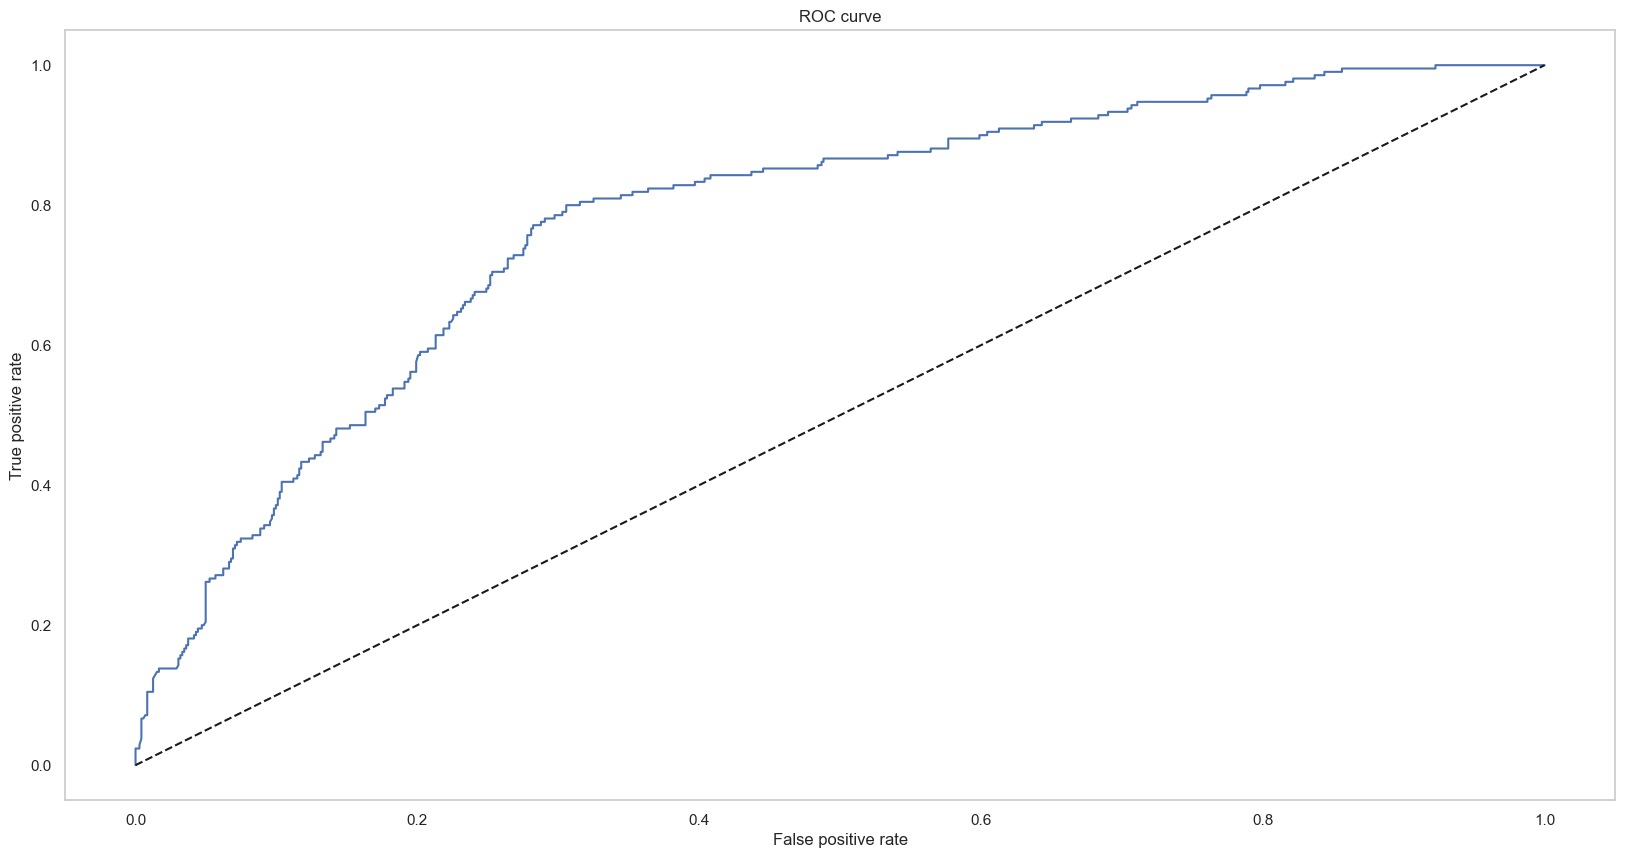

In [1128]:
#Plotting the ROC curve

y_hat_test_proba = cvlr.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba), pd.DataFrame(y_pred)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba.index = X_test.index
y_test_proba.head()

fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

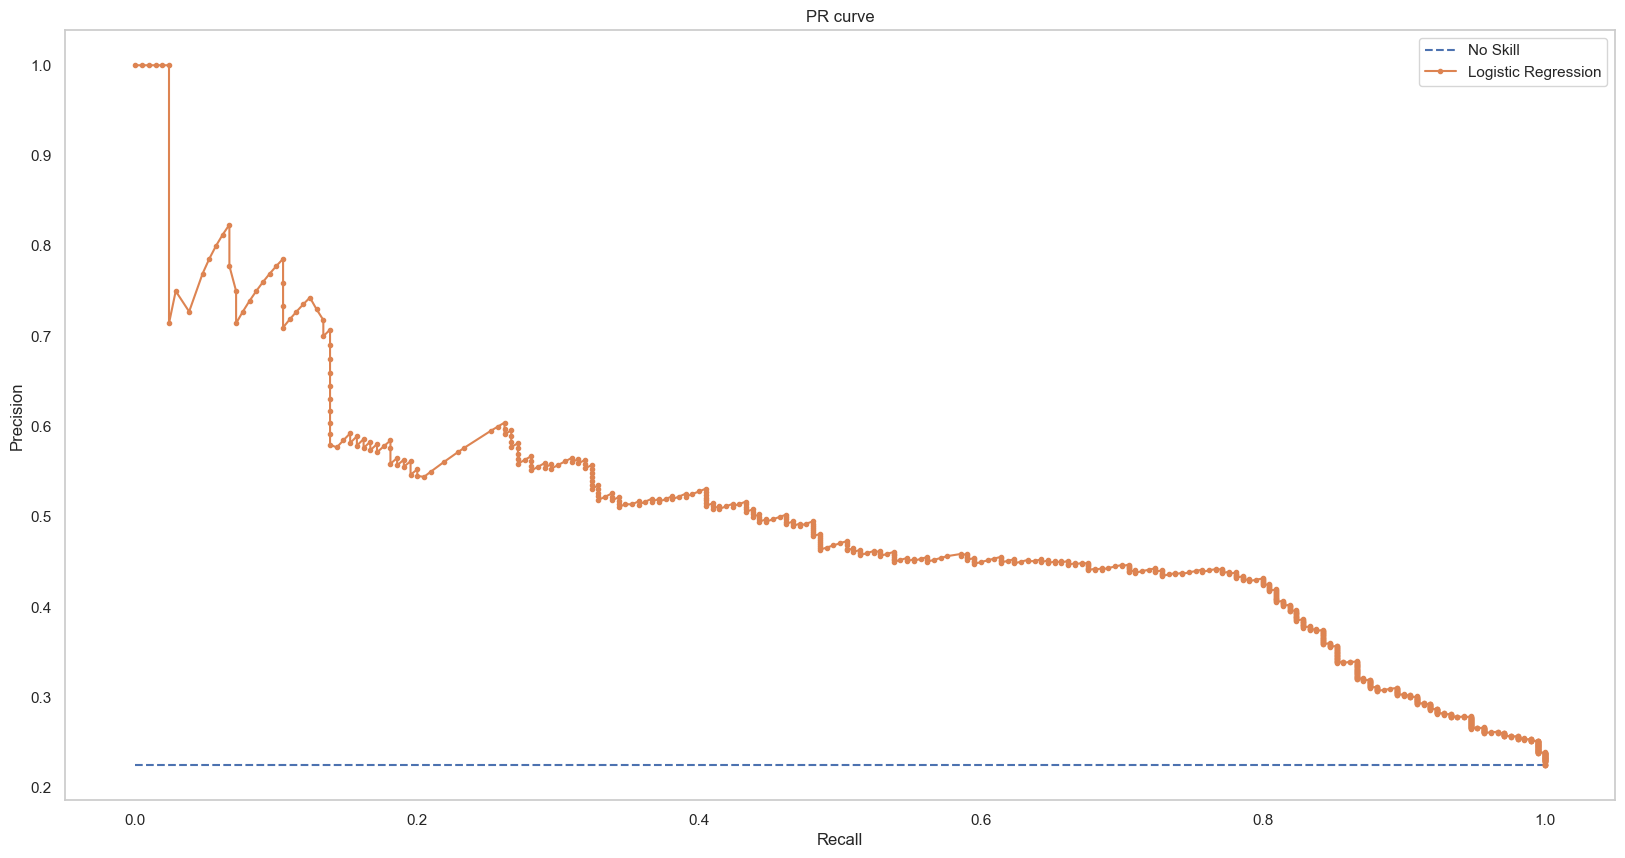

In [1110]:
# draw the PR curve

no_skill = len(y_test[y_test == 1]) / len(y_test)
# plot the no skill precision-recall curve
plt.figure(figsize=(20,10))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [1129]:
def decision_threshold(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

In [1130]:
decision_threshold_lr=decision_threshold(fpr,tpr,thresholds)
print("The optimal decision threshold is %f" %decision_threshold_lr)

The optimal decision threshold is 0.470235


<b>We have plotted the ROC and Precision-Recall curve above and found the optimal decision threshold to be 0.47. So, according to this model, we will treat any data point with probability of default more than 0.48 as a predicted default. The F2 score will be calculated using this decision threshold</b>

In [1131]:
y_pred_adjusted=y_pred_proba.apply(lambda x: 0 if x[1]<decision_threshold_lr else 1, axis=1)
F2=fbeta_score(y_test, y_pred_adjusted, beta=2)
AUCROC=roc_auc_score(y_test, y_pred)
print('Test-set AUCROC for Logistic Regression model: %.4f' % (AUCROC))
print('Test-set Gini coefficient for Logistic Regression model: %.4f' % (2*AUCROC-1))
print('Test-set F2 for Logistic Regression model: %.4f' % (F2))

Test-set AUCROC for Logistic Regression model: 0.7348
Test-set Gini coefficient for Logistic Regression model: 0.4696
Test-set F2 for Logistic Regression model: 0.6835


<b>We chose AUCROC, Gini and F2 metrics to evaluate our model.</b> 

<b>AUCROC and Gini were chosen because we wanted to assess the discriminative capability of our model across all thresholds. F2 was chosen to get a balanced evaluation using both precision and recall, but with more weightage to recall because although, we want to avoid false positives (incorrectly predicted defaulter), false negatives (actual defaulters who are not detected) would be much costlier to the business.</b>

<b>We observed AUCROC OF 0.73, Gini of 0.47 and F2 score of 0.68. All of these scores are acceptable, but could possibly be improved if the data is explored further in order to perorm more feature engineering and find other ways to improve the model. </b>

# Alternative approach using Random Forest model

Upto this point in this notebook, we have employed the traditional method of tackling a default prediction problem - Using Weight-of-Evidence based feature binning and encoding and then applying a Logistic Regression model.

Now let us try an alternative approach - We will use select relevant features using permutation importances and then fit a final Random Forest model for the predictions. Random Forest model was chosen because while plotting the WoE values for the Logistic Regression model, a lot of features with non-linear relationship with the target variable was observed, which a Random Forest model would be able to easily capture.

<b>We will create a pipeline for all the importances plot, feature selection and data processing for this model. The following steps will be followed:</b><br>
<ul><li>First, we will perform all the feature engineering steps followed in the previous model for the 'gms_version' column and also fill the missing values with -1 so that any information that the missing values might contain is picked up by the model</li>
    <li>Then, we will introduce a new feature containing only random values in the feature set called 'random_Col'. This will act as a benchmark feature and any feature with mean feature importance score less than the maximum score for the random feature will be deemed to have an insignificant effect on the target and we will drop them. This idea is borrowed from the Boruta technique and applied here in a simpler manner.</li>
    <li>We will fit a preliminary Random Forest model using which, we will generate and plot the permutation feature importances and select the relevant features using it.</li></ul>

### Data preprocessing and feature engineering pipelines

In [944]:
#This class will be used for the pipeline that fits the preliminary Random Forest model to be used for feature selection.

class WoE_RF_Feature_Selection(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or *kargs
        pass
    
    def fit(self, X, y):
        rf_FI_X=X
#         rf_FI_X=rf_FI_X.fillna(-1)
        rf_FI_X['random_Col']=np.random.randint(1, 50, rf_FI_X.shape[0])
        rf_FI_y=y
        rf_FI=RandomForestClassifier(n_estimators=2, max_depth=15, max_features=8, min_samples_split=50, min_samples_leaf=7, random_state=47, n_jobs=-1, class_weight='balanced')
        rf_FI.fit(rf_FI_X, rf_FI_y)
        
        #Calculating and plotting the permutation importances
        PI_result = permutation_importance(rf_FI, rf_FI_X, rf_FI_y, n_repeats=10, random_state=47, n_jobs=-1, scoring='roc_auc')

        sorted_importances_idx = PI_result.importances_mean.argsort()
        importances = pd.DataFrame(PI_result.importances[sorted_importances_idx].T, columns=rf_FI_X.columns[sorted_importances_idx],)
        self.importances=importances
        ax = importances.plot.box(vert=False, whis=10, figsize=(16,24))
        ax.set_title("Permutation Importances (test set)")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in accuracy score")
        ax.figure.tight_layout()
        
        return self
    def transform(self, X):
        PI_threshold=self.importances['random_Col'].max()
        columnMask=self.importances.apply(lambda x: x.mean()>PI_threshold, axis=0)
        cols_RF=columnMask.reset_index()
        cols_RF=cols_RF[cols_RF[0]]['index'].tolist()
        return(X.loc[:,cols_RF])

In [973]:
#Feature engineering transformer to create the final 'gms_version' and 'gms_sub_version' features

class RF_Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or *kargs
        pass
    def process_gms_sub_version(gms: str):
    #     print(gms)
        if(gms!=gms):
            return gms
        else:
            return(float((gms.split()[1][1:]).split('-')[0]))
    def process_gms_version(self, gms: str):
#     print(gms)
        if(gms!=gms):
            return gms
        else:
            split=re.split(',|\.', gms.split(' ')[0])
            res=''
            for i in split:
                if(len(i)==1):
                    res=res+'0'+i
                else:
                    res=res+i
            return(float(res))

    def fit(self, X, y=None):
        
        return self
    def transform(self, X):
        X['gms_sub_version']= X['gms_version'].apply(process_gms_sub_version)
        X['gms_version'] = X['gms_version'].apply(self.process_gms_version)
        X=X.fillna(-1)
        return X

AVG. DAILY DEBIT TRANSACTIONS COUNT LIFETIME  \
1019                                          0.99   
3005                                          0.87   
2081                                          0.69   
1231                                          0.20   
4514                                          0.61   
...                                            ...   
387                                           1.31   
3127                                          0.41   
3213                                          0.01   
3121                                          3.08   
3888                                          0.13   

      AVG. DAILY DEBIT TRANSACTIONS AMOUNT LAST 180 DAYS  \
1019                                            2475.28    
3005                                            2866.06    
2081                                             890.63    
1231                                            1282.15    
4514                                            1606.25    
...                                                 ...    
387                                             4129.13    
3127                                            1026.97    
3213                                              86.61    
3121                                             959.75    
3888                                             425.35    

      AVG. OF MINIMUM BALANCE PER MONTH LAST 360 DAYS  \
1019                                         13718.16   
3005                                         13416.68   
2081                                          1056.73   
1231                                          6561.86   
4514                                         11188.46   
...                                               ...   
387                                         106884.41   
3127                                         20684.29   
3213                                         13588.78   
3121                                            37.36   
3888                                          2314.90   

      count_debit_transactions_last_360_days  \
1019                                    94.0   
3005                                    86.0   
2081                                    35.0   
1231                                    34.0   
4514                                   227.0   
...                                      ...   
387                                    101.0   
3127                                    87.0   
3213                                     1.0   
3121                                    80.0   
3888                                    19.0   

      AVG. CREDIT PER TRANSACTION LAST 30 DAYS  \
1019                                   4779.38   
3005                                  21764.65   
2081                                   7662.89   
1231                                  15173.00   
4514                                   6825.00   
...                                        ...   
387                                   24455.00   
3127                                   1645.64   
3213                                  16000.00   
3121                                   3369.96   
3888                                  15000.00   

      AVG. MONTHLY DEBIT CARD TRANSACTIONS AMOUNT LAST 180 DAYS  \
1019                                           40815.00           
3005                                           28862.88           
2081                                              29.63           
1231                                           13830.00           
4514                                           14085.00           
...                                                 ...           
387                                             8290.65           
3127                                           28312.83           
3213                                               0.00           
3121                                               0.00           
3888                                

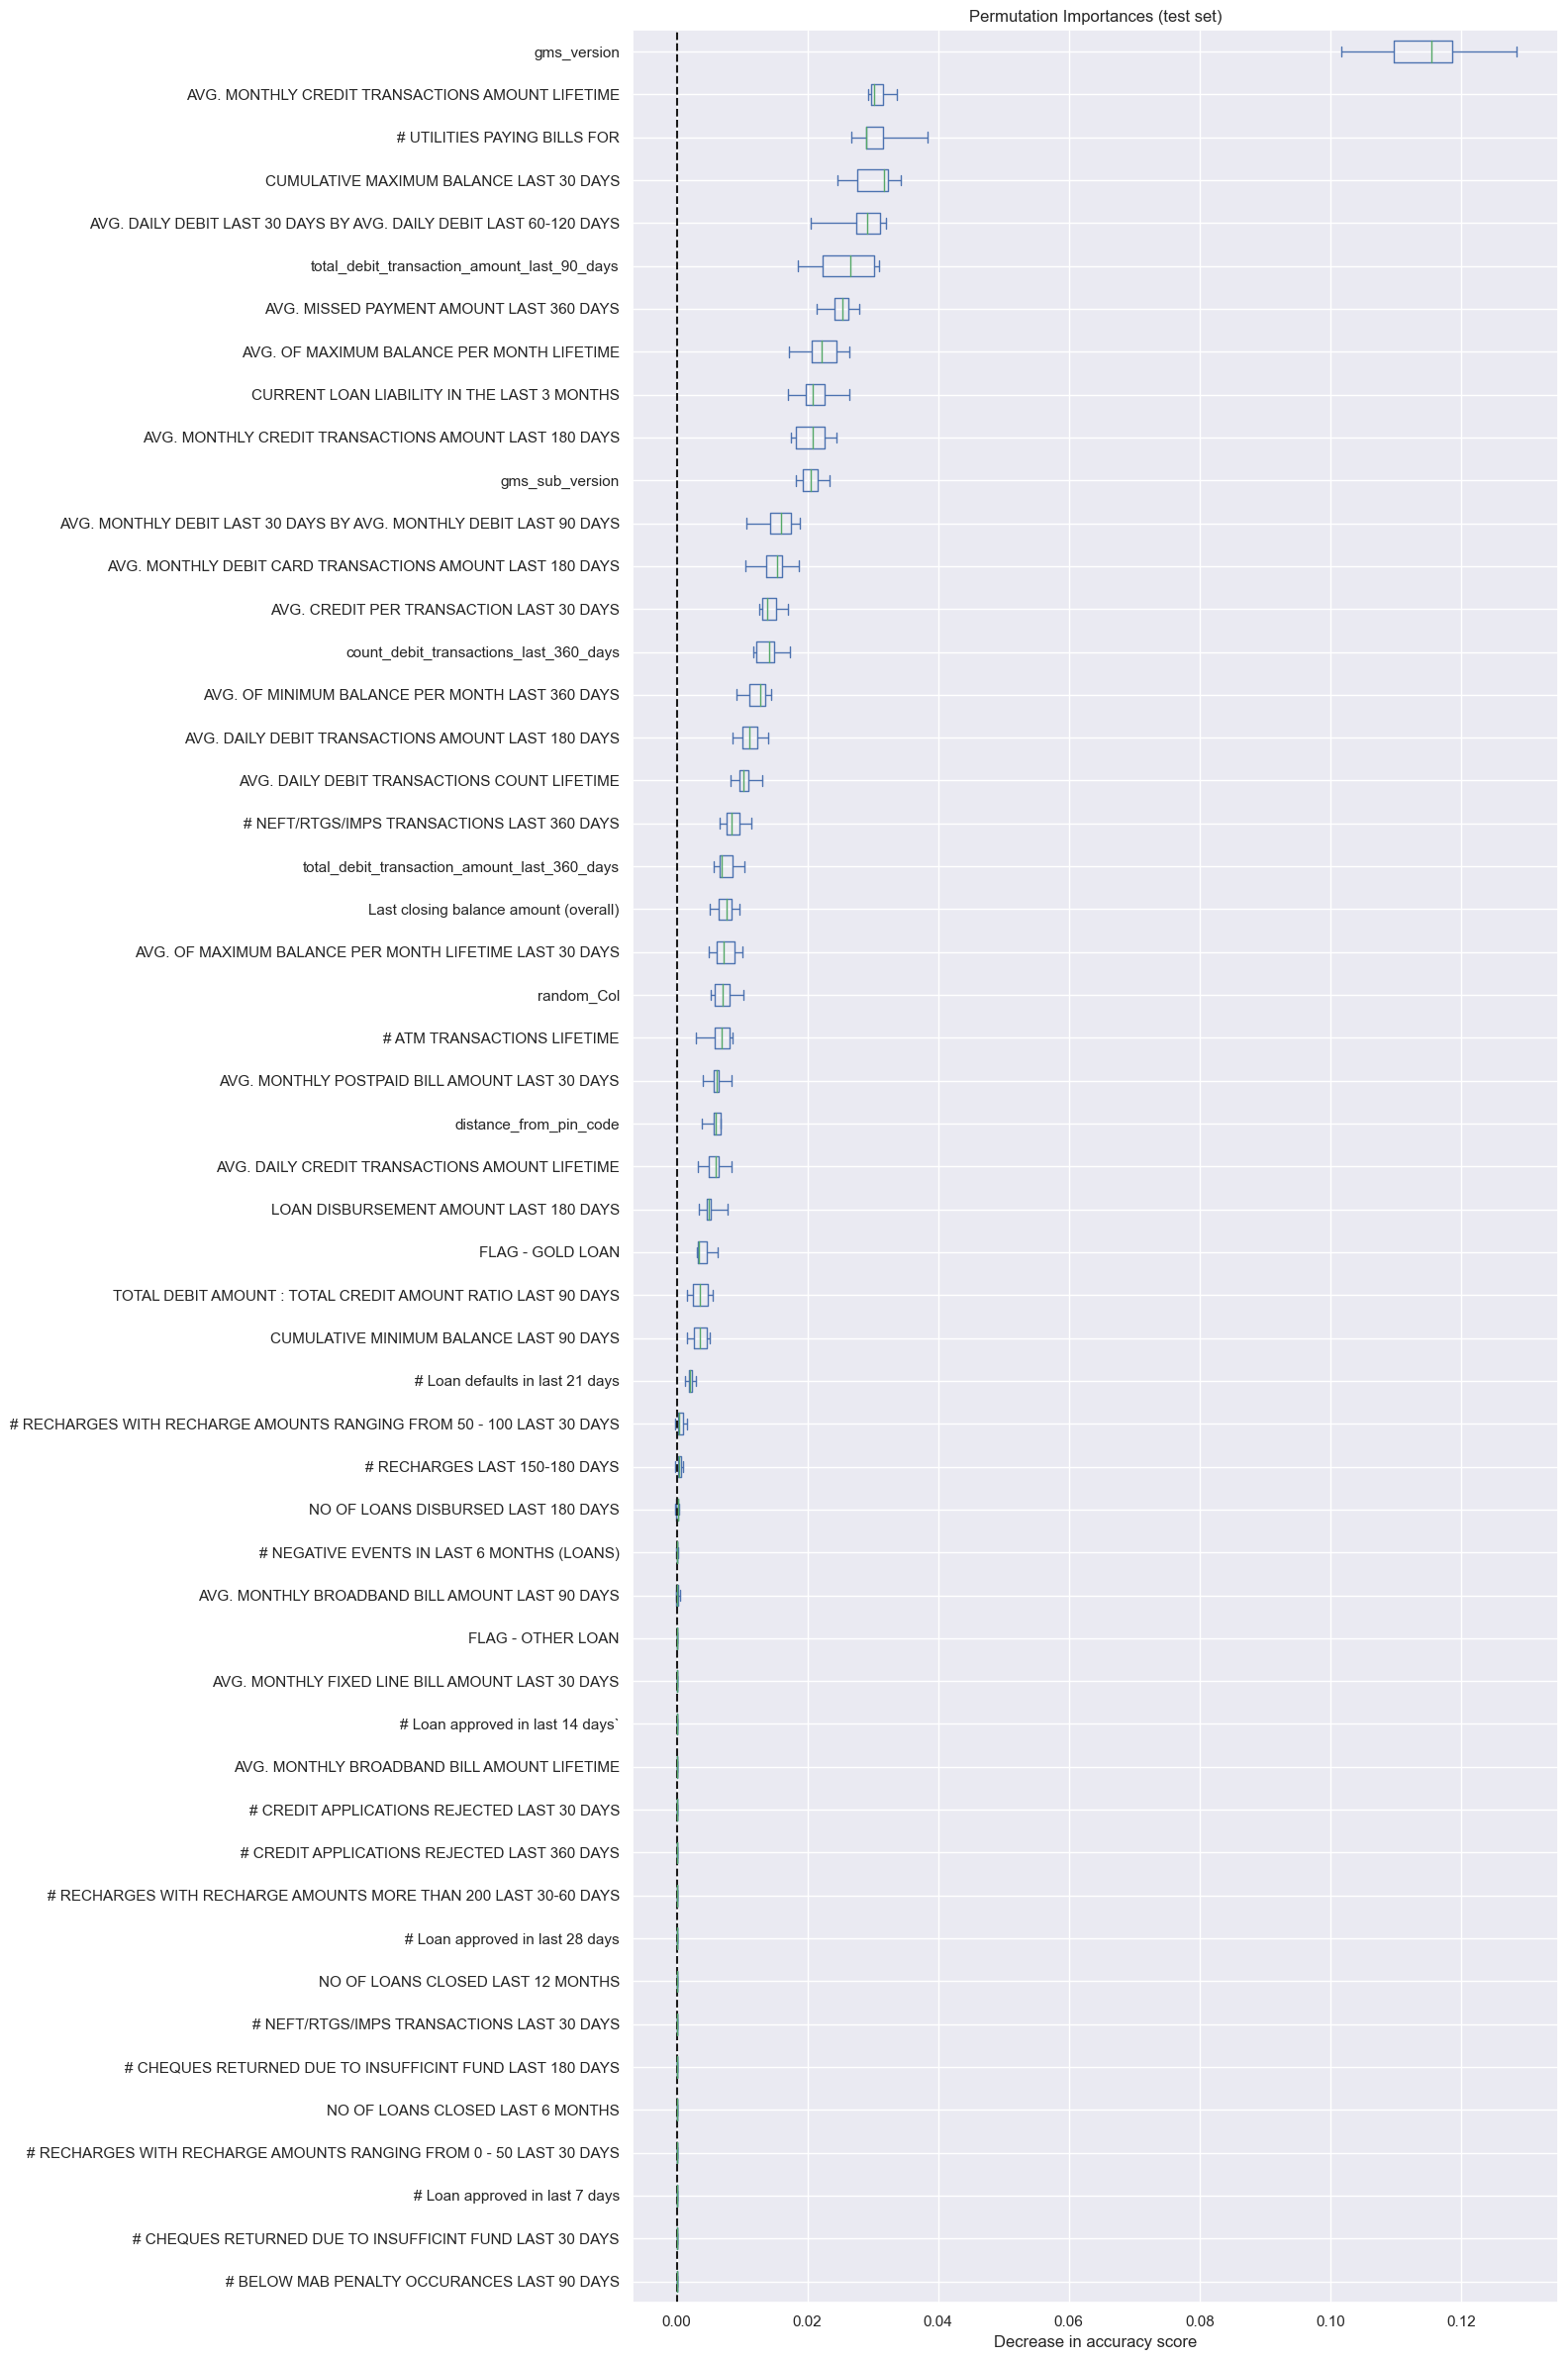

In [516]:
rf_preprocessor=RF_Preprocessing()
rf_feature_selector=WoE_RF_Feature_Selection()
rf_feature_selection_pipeline = Pipeline(steps=[('preprocessing', rf_preprocessor), ('feature_selection', rf_feature_selector)])
X_train_RF=rf_feature_selection_pipeline.fit_transform(data_copy.copy().drop(columns=['default']), data_copy.copy()['default'])
y_train_RF=data_copy['default']
display(X_train_RF)

### Hyperparameter tuning and model building for the Random Forest model

In [581]:
parameters={'n_estimators':[70], 'n_jobs':[-1], 'max_features':[math.ceil(np.sqrt(len(X_train_RF.iloc[0])))], 'max_depth':[7, 8, 10, 12, 15, 20, 25, 30], 'random_state': [180], 'class_weight': ['balanced'], 'min_samples_split': [15, 20, 50, 100, 200, 500, 700]}

#The actual training process involved a wide array of hyperparameters for hyperparameter tuning, 
#but only the best selected parameter s have been included here for the sake of reducing the runtime of this notebook.

cvrf = GridSearchCV(RandomForestClassifier(), parameters, scoring='roc_auc', n_jobs=-1, verbose=3, cv=9)
cvrf.fit(X_train_RF,y_train_RF)

Fitting 9 folds for each of 56 candidates, totalling 504 fits


GridSearchCV(cv=9, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [7, 8, 10, 12, 15, 20, 25, 30],
                         'max_features': [5],
                         'min_samples_split': [15, 20, 50, 100, 200, 500, 700],
                         'n_estimators': [70], 'n_jobs': [-1],
                         'random_state': [180]},
             scoring='roc_auc', verbose=3)

<b>After the data was transformed using the above pipeline, GridSearchCV was used to perform hyperparameter tuning and fit the model using the optimal set of hyperparameters. </b>

In [582]:
print(cvrf.best_params_)
print('Training set AUCROC for Random Forest model: %.4f' % cvrf.best_score_)

{'class_weight': 'balanced', 'max_depth': 8, 'max_features': 5, 'min_samples_split': 50, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 180}
Training set AUCROC for Random Forest model: 0.7794


In [583]:
print('Training set AUCROC for Random Forest model: %.4f' % roc_auc_score(y_train_RF, cvrf.predict(X_train_RF)))

Training set AUCROC for Random Forest model: 0.7694


<b>A cross-validation AUCROC score and training AUCROC score of 0.72 and 0.79 were observed respectively</b>

### Model evaluation for the Random Forest model

The following steps will be followed here:
<ul>
    <li>Create a separate pipeline for the test data.</li>
    <li>Plot the ROC and Precision-Recall curves</li>
    <li>Calculate the optimal decision function</li>
    <li>Evaluate the model on various evaluation metrics.</li>

In [953]:
#Creating a pipeline to process the test data and applying it to prepare the test data for evaluation

testRFPipeline=Pipeline([('preprocessing', rf_preprocessor)])
y_test_RF=data_test['default']
X_test_RF=testRFPipeline.fit_transform(data_test.copy().drop(columns=['default']))
X_test_RF=X_test_RF.loc[:,X_train_RF.columns.tolist()]
y_pred_RF=cvrf.predict(X_test_RF)
y_pred_proba_RF=pd.DataFrame(cvrf.predict_proba(X_test_RF))

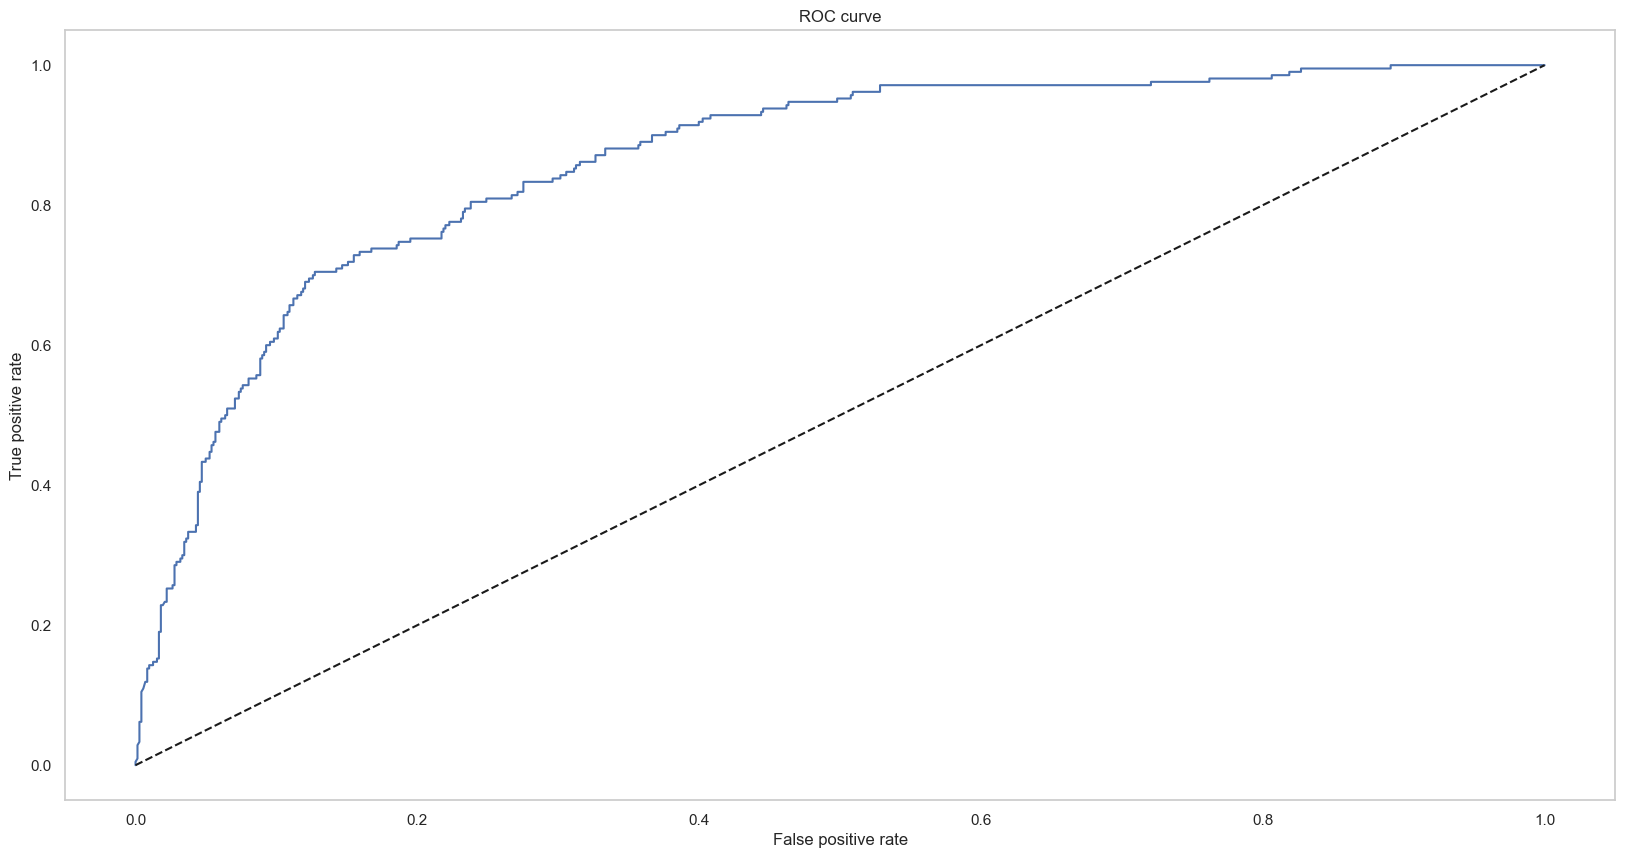

In [951]:
y_hat_test_proba_rf = cvrf.predict_proba(X_test_RF)
y_hat_test_proba_rf = y_hat_test_proba_rf[:][: , 1]
y_test_temp_rf = y_test_RF.copy()
y_test_temp_rf.reset_index(drop = True, inplace = True)
y_test_proba_rf = pd.concat([y_test_temp_rf, pd.DataFrame(y_hat_test_proba_rf), pd.DataFrame(y_pred_RF)], axis = 1)
y_test_proba_rf.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba_rf.index = X_test_RF.index
y_test_proba_rf.head()

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_proba_rf['y_test_class_actual'], y_test_proba_rf['y_hat_test_proba'])
plt.figure(figsize=(20,10))
# plot the ROC curve
plt.plot(fpr_rf, tpr_rf)
# plot a secondary diagonal line, to plot randomness of model
plt.plot(fpr_rf, fpr_rf, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

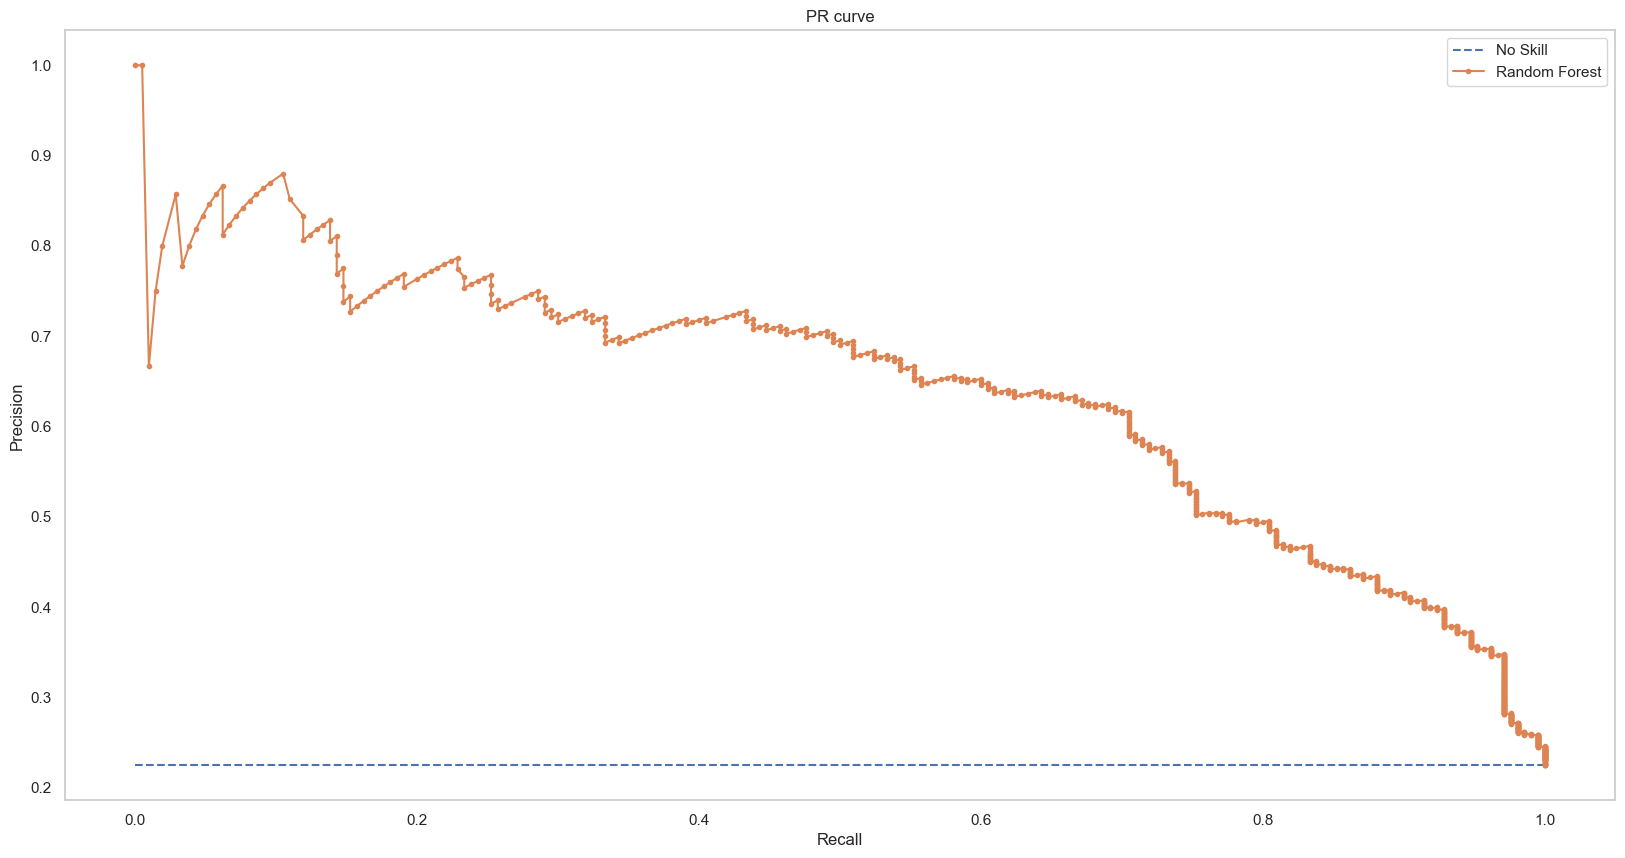

In [991]:
# draw the PR curve

no_skill_RF = len(y_test_RF[y_test_RF == 1]) / len(y_test_RF)
# plot the no skill precision-recall curve
plt.figure(figsize=(20,10))
plt.plot([0, 1], [no_skill_RF, no_skill_RF], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba_rf['y_test_class_actual'], y_test_proba_rf['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [952]:
decision_threshold_rf=decision_threshold(fpr_rf,tpr_rf,thresholds_rf)
print("The optimal decision threshold is %f" %decision_threshold_rf)

The optimal decision threshold is 0.571695


<b>We have plotted the ROC and Precision-Recall curves above and found the optimal decision threshold to be 0.57. So, according to this model, we will treat any data point with probability of default more than 0.57 as a predicted default</b>

In [950]:
y_pred_adjusted_RF=y_pred_proba_RF.apply(lambda x: 0 if x[1]<decision_threshold_rf else 1, axis=1)
F2_RF=fbeta_score(y_test_RF, y_pred_adjusted_RF, beta=2)
AUCROC_RF=roc_auc_score(y_test_RF, y_pred_RF)
print('Test-set AUROC for Random Forest model: %.4f' % (AUCROC_RF))
print('Test-set Gini co-efficient for Random Forest model: %.4f' % (2*AUCROC_RF-1))
print('Test-set F2 score for Random Forest model: %.4f' % (F2_RF))

Test-set AUROC for Random Forest model: 0.7697
Test-set Gini co-efficient for Random Forest model: 0.5394
Test-set F2 score for Random Forest model: 0.7070


<b>The test data was transformed using the preprocessing steps and then the model was evaluated using the same metrics as in the previous model</b>

<b>The performance of the Random Forest model was decent with an AUCROC score of 0.77, Gini of 0.54 and an F2 score of 0.71. </b>
    
<b>It performed better than the Logistic Regression model! Hence our alternative approach was successful.</b>

# Predicting on the oot data using both the models

In [1148]:
decision_ids=data_oot.copy()['decision_id']

#Logistic Regression model
transformed_oot_Data_LR=pipeline_test_lr.fit_transform(data_oot.copy().drop(columns=['decision_id']))
X_oot_LR=transformed_oot_Data_LR.drop(columns=['default'])
y_pred_proba_LR_oot=pd.DataFrame(cvlr.predict_proba(X_oot_LR), index=decision_ids.index)
y_pred_adjusted_LR_oot=y_pred_proba_LR_oot.apply(lambda x: 0 if x[1]<decision_threshold_lr else 1, axis=1)
y_pred_adjusted_LR_oot=pd.concat([decision_ids, y_pred_adjusted_LR_oot], axis=1).rename(columns={0: 'default'})
y_pred_adjusted_LR_oot.to_csv('Default_Predictions_LR.csv', index=False)

#Random Forest model
transformed_oot_Data_RF=testRFPipeline.fit_transform(data_oot.copy().drop(columns=['default', 'decision_id']))
X_oot_RF=transformed_oot_Data_RF
X_oot_RF=X_oot_RF.loc[:,X_train_RF.columns.tolist()]
y_pred_proba_RF_oot=pd.DataFrame(cvrf.predict_proba(X_oot_RF), index=decision_ids.index)
y_pred_adjusted_RF_oot=y_pred_proba_RF_oot.apply(lambda x: 0 if x[1]<decision_threshold_rf else 1, axis=1)
y_pred_adjusted_RF_oot=pd.concat([decision_ids, y_pred_adjusted_RF_oot], axis=1).rename(columns={0: 'default'})
y_pred_adjusted_RF_oot.to_csv('Default_Predictions_RF.csv', index=False)

In [1139]:
#Comparing the outputs of the model. We will check the percentage of rows for which our models disagree with each other.

count=0
total=0
for i,j in zip(y_pred_adjusted_LR_oot['default'], y_pred_adjusted_RF_oot['default']):
    if(i!=j):
        count+=1
    total+=1
percentage_diff=str(round(count*100/total, 2))
print(percentage_diff+"% predictions differ between the models") 

17.48% predictions differ between the models


# Saving both the models

In [957]:
#Logistic Regression model
filename_LR = 'Default_Predict_LR_model.sav'
pickle.dump(cvlr.best_estimator_, open(filename_LR, 'wb'))


#Random Forest model
filename_RF = 'Default_Predict_RF_model.sav'
pickle.dump(cvrf.best_estimator_, open(filename_RF, 'wb'))